In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from collections import defaultdict
from pylab import *
import random

from synchrotron_simulator_gpu_Dataset_4D import SimulationRunner
from automate_dataset_collection import DataAutomation, SimulationDataset



In [2]:

# -------------------------------
# Set random seeds for reproducibility
# random.seed(42)
# np.random.seed(42)
# torch.manual_seed(42)

# -------------------------------
# Define base simulation configurations and common parameters
# -------------------------------

# Define base simulation configurations with embedded quadrupole errors
base_configurations = [
    {
        'config_name': 'Configuration 1',
        'design_radius': 20.0,    # meters
        'n_FODO': 8,
        'f': 15,                 # meters
        'L_quad': 1,             # meters
        'L_straight': 1,         # meters
        # 'total_dipole_bending_angle': (2 * np.pi),#(3 / 3) * np.pi,
        # 'quad_errors': None,

        'quad_errors': [
            # {
            #     'FODO_index': 0,
            #     'quad_type': 'defocusing',
            #     'delta': 1e-5,
            #     'plane': 'vertical'  # 'horizontal' or 'vertical'
            # },
            {
                'FODO_index': 1,
                'quad_type': 'defocusing',
                'delta': 1e-6,
                'plane': 'vertical'  # 'horizontal' or 'vertical'
            },
            {
                'FODO_index': 2,
                'quad_type': 'defocusing',
                'delta': 1e-7,
                'plane': 'vertical'  # 'horizontal' or 'vertical'
            },
            {
                'FODO_index': 3,
                'quad_type': 'defocusing',
                'delta': 1e-7,
                'plane': 'vertical'  # 'horizontal' or 'vertical'
            },
            {
                'FODO_index': 4,
                'quad_type': 'defocusing',
                'delta': 1e-7,
                'plane': 'vertical'  # 'horizontal' or 'vertical'
            },
            {
                'FODO_index': 5,
                'quad_type': 'defocusing',
                'delta': 1e-7,
                'plane': 'vertical'  # 'horizontal' or 'vertical'
            },
            # {
            #     'FODO_index': 6,
            #     'quad_type': 'defocusing',
            #     'delta': 1e-7,
            #     'plane': 'vertical'  # 'horizontal' or 'vertical'
            # },
            {
                'FODO_index': 7,
                'quad_type': 'defocusing',
                'delta': 1e-7,
                'plane': 'vertical'  # 'horizontal' or 'vertical'
            },
        ],

        # "quad_tilt_errors": None,
        'quad_tilt_errors': [
            {
                'FODO_index': 1,
                'quad_type': 'defocusing',
                'tilt_angle': 0.0005
            },
            {
                'FODO_index': 2,
                'quad_type': 'defocusing',
                'tilt_angle': 0.0005
            },
            {
                'FODO_index': 6,
                'quad_type': 'defocusing',
                'tilt_angle': 0.0005
            },
            
        ],

        # 'dipole_tilt_errors': None,
        'dipole_tilt_errors': [
            {
                'FODO_index': 0,
                'dipole_index': 0,
                'tilt_angle': 0.005
            },
            {
                'FODO_index': 1,
                'dipole_index': 1,
                'tilt_angle': 0.005
            },
            {
                'FODO_index': 7,
                'dipole_index': 1,
                'tilt_angle': 0.005
            }
        ],

    },
]

common_parameters = {
    'n_field_index': np.sqrt(0.2),    # Field index
    'p': 5.344286e-19,                # Momentum in kg m/s (p_GeV_c=0.7)
    'G': 1.0,                         # Tesla/meter
    'q': 1.602e-19,                   # Proton charge in Coulombs
    'n_turns': 2000,                   # Number of revolutions to simulate
    'num_particles': 2,             # Number of particles to simulate
    'window_size': 10,                # Average window size for moving averages
    'use_thin_lens': True,
    # Uniform - Initial conditions ranges as tuples
    'x0_mean_std': (0.0, 0.05),      # meters
    'xp0_mean_std': (0.0, 0.00),  # radians
    'y0_mean_std': (0.0, 0.05),      # meters
    'yp0_mean_std': (0.0, 0.00),  # radians
    'particles_sampling_method': 'from_twiss_params', # from_twiss_params | circle_with_radius | normal
    'sampling_circle_radius': 0.01, #meters,
    # Acceptable ranges config params
    'mag_field_range': [0.1, 2.0],           # Tesla
    'dipole_length_range': [0.2, 14.0],       # meters
    'horizontal_tune_range': [0.1, 0.8],     # Tune
    'vertical_tune_range': [0.1, 0.8],        # Tune
    'total_dipole_bending_angle_range': (1.5 * np.pi, 2 * np.pi),
    # Use cuda GPU kernels to accelerate simulation
    'use_gpu': True,
    # Log
    'verbose': True,
    # BPM readings log criterion
    # record_full_revolution. By default records for cell_idx=0
    # 'record_full_revolution': False,
    # enable storing BPM readings for all BPMs after each full revolution relative to each BPM
    # requires to set record_full_revolution to `True`
    # 'record_full_revolution_per_bpm': False,
    
    # Parameters for generate_data
    'target_data': 'quad_misalign_deltas',  # ['quad_misalign_deltas', 'quad_tilt_angles', 'dipole_tilt_angles']
    'reject_multiple_error_types': False,
    'start_rev': 50,
    'end_rev': 200, # should be same as <= n_turns
    'apply_avg': True,
    'fodo_cell_indices': [0, 1, 2, 3, 4, 5, 6, 7],  # Indices of BPMs to consider
    'planes': ['x', 'y'],
    'random_criterion': 'normal', # uniform | normal
    # if 'random_criterion' is 'uniform'
        # then >> _range is (low, high)
    # if 'random_criterion' is 'normal'
        # then >> _range is (mean, std)
    'delta_range': (0, 5e-5),
    'quad_tilt_angle_range': (-0.10, 0.10), # 100 mrad (1e-3 = 1 mrad)
    'dipole_tilt_angle_range': (0, 0.05), # 50 mrad
    'com_delta_range': (-50e-6, 50e-6),
}


    


In [3]:
# merged_config = {**common_parameters, **base_configurations[0]}

In [4]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


### Generate new data

In [5]:
# -------------------------------
# Data Generation using DataAutomation
# -------------------------------

GENERATE_DATA = False

if GENERATE_DATA:
    n_simulations = 0
    
    fodo_indices_with_error = [err['FODO_index'] for err in base_configurations[0]['quad_errors']]
    fodo_indices_with_error_str = "".join(str(ei) for ei in fodo_indices_with_error)
    
    fodo_indices_with_quad_tilt_error = [err['FODO_index'] for err in base_configurations[0]['quad_tilt_errors']]
    fodo_indices_with_quad_tilt_error_str = "".join(str(ei) for ei in fodo_indices_with_quad_tilt_error)
    
    fodo_indices_with_dipole_tilt_error = [err['FODO_index'] for err in base_configurations[0]['dipole_tilt_errors']]
    fodo_indices_with_dipole_tilt_error_str = "".join(str(ei) for ei in fodo_indices_with_dipole_tilt_error)
    
    # For readability, label each section: 
    tag = (
        f"Sim{n_simulations}_"                     # number of total samples
        f"{common_parameters['n_turns']}turns_"    # turns per simulation
        f"{common_parameters['num_particles']}parts_"  # number of particles
        f"FODOErr({fodo_indices_with_error_str}|"
        f"{fodo_indices_with_quad_tilt_error_str}|"
        f"{fodo_indices_with_dipole_tilt_error_str})_"  # which FODOs had errors
        f"avg{common_parameters['apply_avg']}_"    # whether averaging is applied
        f"tgt{common_parameters['target_data']}"   # which target variable is used
    )
    
    print("Using tag:", tag)
    # Define the number of simulations and delta range

    # Create an instance of DataAutomation with delta_range
    data_automation = DataAutomation(base_configurations, common_parameters, n_simulations)
    dataset_scalers = data_automation.get_data_scalers()
    
    # Run the data automation process and get the data tensors
    input_tensors, target_tensors, input_tensors_scaled, target_tensors_scaled = data_automation.run(
        include_no_error_data=False, 
        skip_data_on_delta_ranges=False)

In [6]:
# dataset_scalers

### Or load from file saved tensors

In [32]:
# #TODO(aribra): properly save and load to/from disk

# data_postfix = "l"
# data_postfix = "_Mix_2000sample_1500revs_10particles_error-fodo-123457-Quad_Dipole_tilt-target-MisAlign"

# data_postfix = '_Mix_2000sample_2000revs_10particles_tilt-error-fodo-123457-apply_avg_True-target_quad_misalign_deltas'

# data_postfix = '_Mix_0sample_2000revs_10particles_tilt-error-fodo-123457_126_017-apply_avg_True-target_quad_misalign_deltas'
data_dir = '/home/aribra/jnps/thesis/lattice_error_net/data/Sim3000_2000turns_10parts_FODOErr-123457-126-017_avgTrue_tgtquad_misalign_deltas_2'

postfix = 'final'

all_error_values_dipole_tilt =   torch.load(f'{data_dir}/all_error_values_dipole_tilt-{postfix}.pt')
all_error_values_quad_misalign = torch.load(f'{data_dir}/all_error_values_quad_misalign-{postfix}.pt')
all_error_values_quad_tilt =     torch.load(f'{data_dir}/all_error_values_quad_tilt-{postfix}.pt')
data_automation =                torch.load(f'{data_dir}/data_automation-{postfix}.pt')
dataset_scalers =                torch.load(f'{data_dir}/dataset_scalers-{postfix}.pt')
input_tensors =                  torch.load(f'{data_dir}/input_tensors-{postfix}.pt')
input_tensors_scaled =           torch.load(f'{data_dir}/input_tensors_scaled-{postfix}.pt')
merged_config =                  torch.load(f'{data_dir}/merged_config-{postfix}.pt')
target_tensors =                 torch.load(f'{data_dir}/target_tensors-{postfix}.pt')
target_tensors_scaled =          torch.load(f'{data_dir}/target_tensors_scaled-{postfix}.pt')

/tmp/ipykernel_1489325/1292646687.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_error_values_dipole_tilt =   torch.load(f'{data_dir}/all_error_values_dipole_tilt-

In [11]:
tag = "_s_1000sample_1500revs_10particles_erroro-fodo-123457"


# all_error_values_dipole_tilt =   torch.load(f'{data_dir}/all_error_values_dipole_tilt-{postfix}.pt')
# all_error_values_quad_misalign = torch.load(f'{data_dir}/all_error_values_quad_misalign-{postfix}.pt')
# all_error_values_quad_tilt =     torch.load(f'{data_dir}/all_error_values_quad_tilt-{postfix}.pt')
data_automation =                torch.load(f'old_data/data_automation{tag}.pt')
dataset_scalers =                torch.load(f'old_data/dataset_scalers{tag}.pt')
input_tensors =                  torch.load(f'old_data/input_tensors{tag}.pt')
input_tensors_scaled =           torch.load(f'old_data/input_tensors_scaled{tag}.pt')
# merged_config =                  torch.load(f'old_data/merged_config{tag}.pt')
target_tensors =                 torch.load(f'old_data/target_tensors{tag}.pt')
target_tensors_scaled =          torch.load(f'old_data/target_tensors_scaled{tag}.pt')

/tmp/ipykernel_1507000/622172983.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_automation =                torch.load(f'old_data/data_automation{tag}.pt')
/tmp/ip

In [14]:
data_automation.data_scalers

{'input_scaler': MinMaxScaler(feature_range=(-1, 1)),
 'target_scaler': MinMaxScaler(feature_range=(-1, 1))}

In [15]:
merged data_automation.common_parameters

{'n_field_index': 0.4472135954999579,
 'p': 5.344286e-19,
 'G': 1.0,
 'q': 1.602e-19,
 'n_turns': 1500,
 'num_particles': 10,
 'window_size': 10,
 'use_thin_lens': True,
 'x0_mean_std': (0.0, 0.05),
 'xp0_mean_std': (0.0, 0.0),
 'y0_mean_std': (0.0, 0.05),
 'yp0_mean_std': (0.0, 0.0),
 'particles_sampling_method': 'from_twiss_params',
 'sampling_circle_radius': 0.01,
 'mag_field_range': [0.1, 2.0],
 'dipole_length_range': [0.2, 14.0],
 'horizontal_tune_range': [0.1, 0.8],
 'vertical_tune_range': [0.1, 0.8],
 'total_dipole_bending_angle_range': (4.71238898038469, 6.283185307179586),
 'use_gpu': True,
 'verbose': True,
 'record_full_revolution': False,
 'record_full_revolution_per_bpm': False,
 'start_rev': 1000,
 'end_rev': 1500,
 'fodo_cell_indices': [0, 1, 2, 3, 4, 5, 6, 7],
 'planes': ['x', 'y'],
 'delta_range': (-5e-05, 5e-05),
 'com_delta_range': (-5e-05, 5e-05)}

In [16]:
data_automation.base_configurations

[{'config_name': 'Configuration 1',
  'design_radius': 20.0,
  'n_FODO': 8,
  'f': 15,
  'L_quad': 1,
  'L_straight': 1,
  'quad_errors': [{'FODO_index': 1,
    'quad_type': 'defocusing',
    'delta': 2.598154635878888e-06,
    'plane': 'vertical'},
   {'FODO_index': 2,
    'quad_type': 'defocusing',
    'delta': -8.954110871478053e-05,
    'plane': 'vertical'},
   {'FODO_index': 3,
    'quad_type': 'defocusing',
    'delta': -8.509333299614716e-05,
    'plane': 'vertical'},
   {'FODO_index': 4,
    'quad_type': 'defocusing',
    'delta': -4.867257768400947e-05,
    'plane': 'vertical'},
   {'FODO_index': 5,
    'quad_type': 'defocusing',
    'delta': -9.465236532795341e-05,
    'plane': 'vertical'},
   {'FODO_index': 7,
    'quad_type': 'defocusing',
    'delta': -0.00011564744899552303,
    'plane': 'vertical'}]}]

In [17]:
data_automation.overridden_base_config

{'config_name': 'Configuration 1',
 'design_radius': 20.0,
 'n_FODO': 8,
 'f': 3.336008739076155,
 'L_quad': 1,
 'L_straight': 3.9269908169872423,
 'quad_errors': [{'FODO_index': 1,
   'quad_type': 'defocusing',
   'delta': 2.598154635878888e-06,
   'plane': 'vertical'},
  {'FODO_index': 2,
   'quad_type': 'defocusing',
   'delta': -8.954110871478053e-05,
   'plane': 'vertical'},
  {'FODO_index': 3,
   'quad_type': 'defocusing',
   'delta': -8.509333299614716e-05,
   'plane': 'vertical'},
  {'FODO_index': 4,
   'quad_type': 'defocusing',
   'delta': -4.867257768400947e-05,
   'plane': 'vertical'},
  {'FODO_index': 5,
   'quad_type': 'defocusing',
   'delta': -9.465236532795341e-05,
   'plane': 'vertical'},
  {'FODO_index': 7,
   'quad_type': 'defocusing',
   'delta': -0.00011564744899552303,
   'plane': 'vertical'}],
 'L_dipole': 5.890486225480862,
 'n_Dipoles': 16,
 'L_drift': 0.48174770424681057,
 'Qx': 0.2812969049561037,
 'Qy': 0.28129690495610365,
 'B': 0.16680043695380775,
 'B_rh

### Optional: select plane

In [12]:
# planes: x:0, y:1
# planes = [0, 1]
# input_tensors = input_tensors[..., planes]
# input_tensors_scaled = input_tensors_scaled[..., planes]

# print(input_tensors.shape)

# plot(input_tensors[2, :, 0, 1]);
# plot(input_tensors[1010, :, 0, 1]);

In [18]:
quad_errors = base_configurations[0]['quad_errors']
quad_tilt_errors = base_configurations[0]['quad_tilt_errors']
dipole_tilt_errors = base_configurations[0]['dipole_tilt_errors']

if quad_errors:
    fodo_indices_with_error = [err['FODO_index'] for err in quad_errors]
    fodo_indices_with_error_str = "".join(str(ei) for ei in fodo_indices_with_error)
else:
    fodo_indices_with_error = []
    fodo_indices_with_error_str = ""

if quad_tilt_errors:
    fodo_indices_with_quad_tilt_error = [err['FODO_index'] for err in quad_tilt_errors]
    fodo_indices_with_quad_tilt_error_str = "".join(str(ei) for ei in fodo_indices_with_quad_tilt_error)
else:
    fodo_indices_with_quad_tilt_error = []
    fodo_indices_with_quad_tilt_error_str = ""

if dipole_tilt_errors:
    fodo_indices_with_dipole_tilt_error = [err['FODO_index'] for err in dipole_tilt_errors]
    fodo_indices_with_dipole_tilt_error_str = "".join(str(ei) for ei in fodo_indices_with_dipole_tilt_error)
else:
    fodo_indices_with_dipole_tilt_error = []
    fodo_indices_with_dipole_tilt_error_str = ""

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


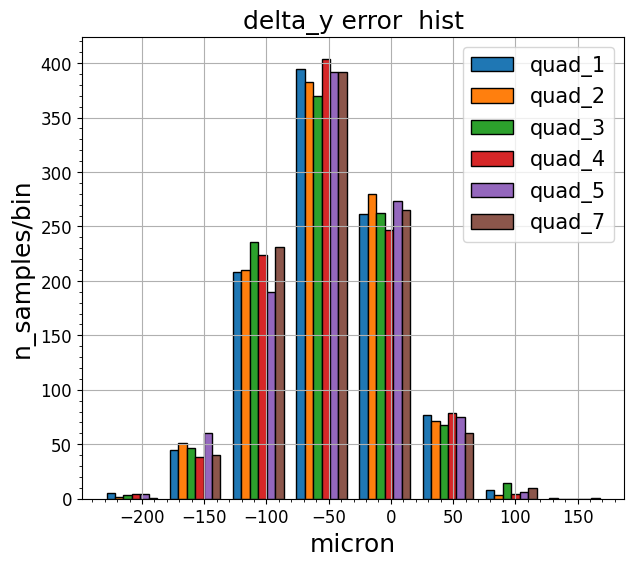

NameError: name 'all_error_values_dipole_tilt' is not defined

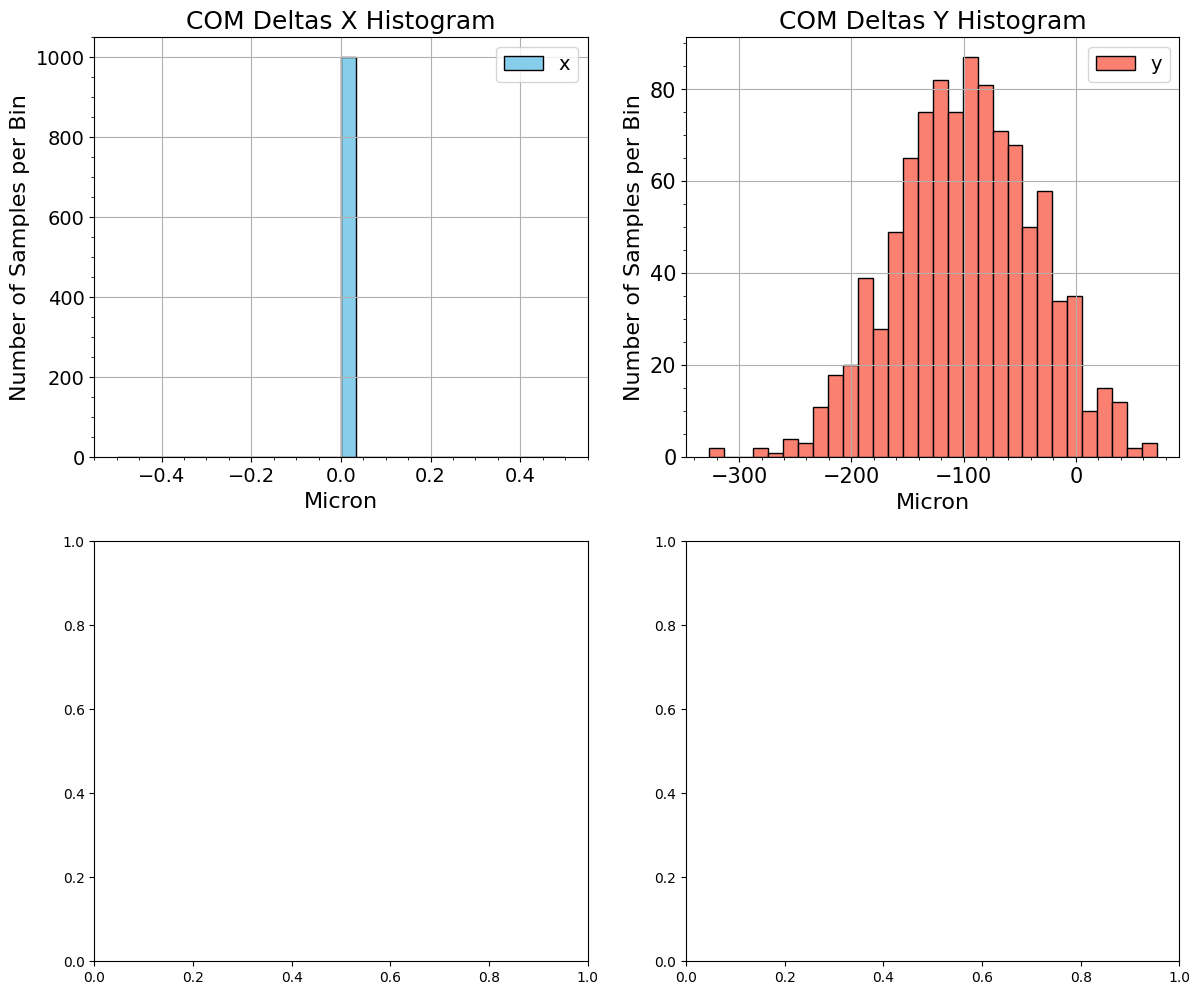

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- Add Conversion Functions ---
def mrad_to_deg(x):
    """Convert milliradians to degrees."""
    return x * (180 / np.pi) / 1000  # mrad to degrees

def deg_to_mrad(x):
    """Convert degrees to milliradians."""
    return x * (np.pi / 180) * 1000  # degrees to mrad

# --- Existing Single Histogram Plot ---
figure(figsize=(7, 6))
plt.hist(target_tensors  * 1e6, bins = 8, edgecolor='black')

title('delta_y error  hist', fontsize=18)
xlabel('micron', fontsize=18)
ylabel('n_samples/bin', fontsize=18)
tick_params(axis='both', labelsize=14)  # Set font size for ticks
tick_params(axis='both', labelsize=12)  # Optional: Set size for minor ticks

fodo_indices_with_error = [err['FODO_index'] for err in base_configurations[0]['quad_errors']]

legend_quad_offset = [f"quad_{qix}" for qix in fodo_indices_with_error]
plt.legend(legend_quad_offset, fontsize=15)
plt.minorticks_on()
grid()
# legend()
plt.savefig(f"./figs/delta_y_error_hist.eps", bbox_inches = 'tight', format='eps')
show()

# --- Existing 2x2 Subplots ---
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))  # Adjust figsize as needed

# com_deltas_x hist
axes[0][0].hist(np.array(data_automation.com_deltas_x) * 1e6, bins=30, edgecolor='black', color='skyblue')
axes[0][0].set_title('COM Deltas X Histogram', fontsize=18)
axes[0][0].set_xlabel('Micron', fontsize=16)
axes[0][0].set_ylabel('Number of Samples per Bin', fontsize=16)
axes[0][0].legend(['x'], fontsize=14)
axes[0][0].tick_params(axis='both', labelsize=14)
axes[0][0].minorticks_on()
axes[0][0].grid()

# com_deltas_y hist
axes[0][1].hist(np.array(data_automation.com_deltas_y) * 1e6, bins=30, edgecolor='black', color='salmon')
axes[0][1].set_title('COM Deltas Y Histogram', fontsize=18)
axes[0][1].set_xlabel('Micron', fontsize=16)
axes[0][1].set_ylabel('Number of Samples per Bin', fontsize=16)
axes[0][1].legend(['y'], fontsize=14)
axes[0][1].tick_params(axis='both', labelsize=15)
axes[0][1].minorticks_on()
axes[0][1].grid()

# all_error_values_dipole_tilt
axes[1][0].hist(all_error_values_dipole_tilt * 1e3, bins=20, edgecolor='black')
axes[1][0].set_title('Dipoles Tilt Error Histogram', fontsize=18)
axes[1][0].set_xlabel('Tilt Angle (mrad)', fontsize=16)
axes[1][0].set_ylabel('Number of Samples per Bin', fontsize=18)
legend_dipole_tilt = [f"dipole_{qix}" for qix in fodo_indices_with_dipole_tilt_error]
axes[1][0].legend(legend_dipole_tilt, fontsize=15)
axes[1][0].tick_params(axis='both', labelsize=15)
axes[1][0].minorticks_on()
axes[1][0].grid()

# --- **Add Secondary X-Axis for Dipoles Tilt Error Histogram** ---
secax_dipole = axes[1][0].secondary_xaxis('top', functions=(mrad_to_deg, deg_to_mrad))
secax_dipole.set_xlabel('Tilt Angle (degrees)', fontsize=16)
secax_dipole.tick_params(axis='x', labelsize=15)

# all_error_values_quad_tilt
axes[1][1].hist(all_error_values_quad_tilt * 1e3, bins=20, edgecolor='black')
axes[1][1].set_title('Quadrupoles Tilt Error Histogram', fontsize=18)
axes[1][1].set_xlabel('Tilt Angle (mrad)', fontsize=16)
axes[1][1].set_ylabel('Number of Samples per Bin', fontsize=18)
legend_quad_tilt = [f"quad_{qix}" for qix in fodo_indices_with_quad_tilt_error]
axes[1][1].legend(legend_quad_tilt, fontsize=15)
axes[1][1].tick_params(axis='both', labelsize=15)
axes[1][1].minorticks_on()
axes[1][1].grid()

# --- **Add Secondary X-Axis for Quadrupoles Tilt Error Histogram** ---
secax_quad = axes[1][1].secondary_xaxis('top', functions=(mrad_to_deg, deg_to_mrad))
secax_quad.set_xlabel('Tilt Angle (degrees)', fontsize=16)
secax_quad.tick_params(axis='x', labelsize=15)

plt.tight_layout()
plt.savefig("./figs/com_deltas_error_hist.eps", bbox_inches='tight', format='eps')
plt.show()


In [343]:
all_error_values_quad_tilt * 1e3

tensor([[ 0.0057, -0.1960, -0.1606],
        [-0.1406,  0.0192,  0.0101],
        [-0.2624, -0.2863,  0.0483],
        ...,
        [-0.0564, -0.0807, -0.0985],
        [-0.0167, -0.0834, -0.1112],
        [-0.0620, -0.2418, -0.0352]])

In [56]:
# input_tensors_scaled.shape

In [57]:
input_tensors.shape

torch.Size([3000, 101, 8, 2])

In [58]:
target_tensors.shape

torch.Size([3000, 6])

In [59]:
input_tensors[0].shape

torch.Size([101, 8, 2])

In [205]:
rev_ix = 0
bpm_ix = 0
ix = np.random.randint(input_tensors.shape[0])

2743


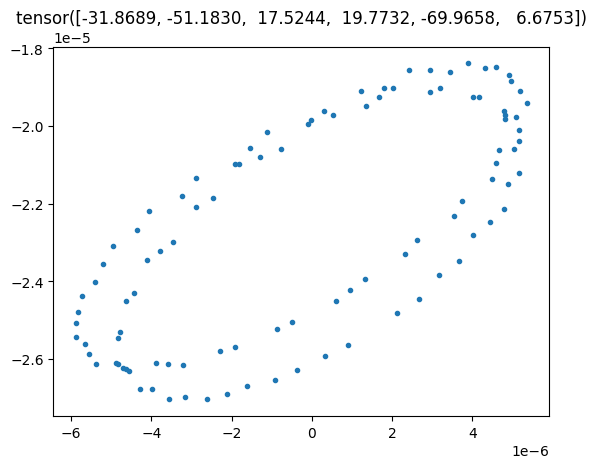

In [206]:
print(ix)
plot(input_tensors[ix][:, bpm_ix, 0], input_tensors[ix][:, bpm_ix, 1], '.');
title(target_tensors[ix] * 1e6)
bpm_ix += 1

In [61]:
input_tensors[ix].shape

torch.Size([101, 8, 2])

In [244]:
base_configurations = [data_automation.overridden_base_config]

# Check if data was collected
if input_tensors_scaled is not None and target_tensors_scaled is not None:
    print(f"All Input Tensors Shape: {input_tensors_scaled.shape}")
    print(f"All Target Tensors Shape: {target_tensors_scaled.shape}")
else:
    print("No simulations within the specified delta range.")
    exit(1)  # Exit if no data was collected

# -------------------------------
# Prepare data for training
# -------------------------------

# Reshape input data

raw_input_tensors = input_tensors_scaled # input_tensors_scaled | input_tensors
raw_target_tensors = target_tensors_scaled # target_tensors_scaled | target_tensors

n_samples, n_turns, n_BPMs, n_planes = raw_input_tensors.shape
input_size = n_BPMs * n_planes
input_data = raw_input_tensors.reshape(n_samples, n_turns, input_size)

# Convert target data to appropriate shape
target_data = raw_target_tensors  # Shape: (n_samples, n_errors), where n_errors = 1

# Split data into training and validation sets
input_data_np = input_data.numpy()
target_data_np = target_data.numpy()

train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    input_data_np, target_data_np, test_size=0.10, shuffle=True) #random_state=42

# Convert back to tensors
train_inputs = torch.tensor(train_inputs, dtype=torch.float32)
val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)
val_targets = torch.tensor(val_targets, dtype=torch.float32)

# Create datasets and data loaders
train_dataset = TensorDataset(train_inputs, train_targets)
val_dataset = TensorDataset(val_inputs, val_targets)


All Input Tensors Shape: torch.Size([3000, 101, 8, 2])
All Target Tensors Shape: torch.Size([3000, 6])


In [163]:
train_inputs.shape

torch.Size([2700, 101, 16])

In [164]:
train_targets.shape

torch.Size([2700, 6])

In [243]:
# -------------------------------
# Define Cross-Validation Parameters and Functionality (Task 1)
# -------------------------------



def perform_cross_validation(model_arch, X, y, k_folds=5, num_epochs=100, batch_size=16, learning_rate=0.001, device='cpu'):
    """
    Performs K-Fold Cross-Validation to determine the best model.

    Parameters:
    - model_arch: 'ffn' or 'lstm'
    - X: Input features (numpy array)
    - y: Targets (numpy array)
    - k_folds: Number of cross-validation folds
    - num_epochs: Number of training epochs per fold
    - batch_size: Batch size for training
    - learning_rate: Learning rate for optimizer
    - device: 'cpu' or 'cuda'

    Returns:
    - best_model: The model with the best average validation performance
    - cv_results: Dictionary containing validation accuracies per fold
    """
    shuffle = False
    kf = KFold(n_splits=k_folds, shuffle=shuffle)
    plot_cv_splits(kf, train_inputs.numpy(), train_targets.numpy(), n_splits=5)
    
    fold = 1
    cv_results = {}
    fold_accuracies = []
    
    for train_index, val_index in kf.split(X):
        print(f'Fold {fold}')
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]
        
        # Convert to tensors
        train_cv = TensorDataset(torch.tensor(X_train_cv, dtype=torch.float32),
                                 torch.tensor(y_train_cv, dtype=torch.float32))
        val_cv = TensorDataset(torch.tensor(X_val_cv, dtype=torch.float32),
                               torch.tensor(y_val_cv, dtype=torch.float32))
        
        train_loader_cv = DataLoader(train_cv, batch_size=batch_size, shuffle=True)
        val_loader_cv = DataLoader(val_cv, batch_size=batch_size, shuffle=False)
        
        # Instantiate a new model for each fold
        if model_arch == 'ffn':
            fnn_hidden_size = 64
            nb_heads = None # output_size
            n_layers = 1
            add_dropout = False
            add_batch_norm = False
            model_cv = SimpleFullyConnectedNetwork(n_turns * input_size, 
                               fnn_hidden_size, 
                               output_size, 
                               n_layers=n_layers , 
                               nb_heads=nb_heads,
                              add_batch_norm=add_batch_norm,
                              add_dropout=add_dropout)
        elif model_arch == 'lstm':
            lstm_hidden_size = 128
            num_layers = 6
            is_bidirectional=False
            model_cv = QuadErrorCorrectionLSTM(
                input_size=input_size,
                hidden_size=lstm_hidden_size,
                num_layers=num_layers,
                output_size=output_size,
                is_bidirectional=is_bidirectional)
        else:
            raise ValueError("Invalid model architecture. Choose 'ffn' or 'lstm'.")
        
        model_cv.to(device)
        
        # Define loss function and optimizer
        criterion_cv = nn.MSELoss()
        optimizer_cv = optim.Adam(model_cv.parameters(), lr=learning_rate)
        scheduler_cv = optim.lr_scheduler.CosineAnnealingLR(optimizer_cv, T_max=num_epochs, eta_min=5e-10)
        
        # Train the model
        train_losses_cv, val_losses_cv, train_maes_cv, val_maes_cv = train_model(
            model=model_cv,
            train_loader=train_loader_cv,
            val_loader=val_loader_cv,
            criterion=criterion_cv,
            optimizer=optimizer_cv,
            scheduler=scheduler_cv,
            device=device,
            num_epochs=num_epochs,
            nb_epoch_log=20  # Adjust as needed
        )
        
        # Evaluate the model on validation set
        model_cv.eval()
        with torch.no_grad():
            total_mae = 0.0
            for batch_inputs_cv, batch_targets_cv in val_loader_cv:
                batch_inputs_cv = batch_inputs_cv.to(device)
                batch_targets_cv = batch_targets_cv.to(device)
                
                outputs_cv = model_cv(batch_inputs_cv)
                mae = compute_mae(outputs_cv, batch_targets_cv)
                total_mae += mae.item() * batch_inputs_cv.size(0)
        
        avg_mae = total_mae / len(val_loader_cv.dataset)
        print(f'Fold {fold} Validation MAE: {avg_mae:.6f}')
        cv_results[fold] = avg_mae
        fold_accuracies.append(avg_mae)
        fold += 1
    
    # Determine the best fold
    best_fold = np.argmin(fold_accuracies) + 1
    print(f'\nBest Fold: {best_fold} with Validation MAE: {cv_results[best_fold]:.6f}')
    
    # Retrain the best model on the entire training set of the best fold
    # Here, for simplicity, we'll assume the first fold is the best.
    # In practice, you might want to save models per fold and load the best one.
    
    # Alternatively, retrain on the entire training data using the best hyperparameters
    
    # For this implementation, we'll return the average MAE and not the model itself
    return best_fold, cv_results

def train_accumulated_datasets(X_train, y_train, X_val, y_val, number_of_accumulated_datasets=10, model_arch='ffn', device='cpu', learning_rate=0.0001, num_epochs=400, batch_size=32):
    """
    Splits the training data into accumulated datasets and trains the model on each subset.

    Parameters:
    - X_train: Training input features (numpy array)
    - y_train: Training targets (numpy array)
    - X_val: Validation input features (numpy array)
    - y_val: Validation targets (numpy array)
    - number_of_accumulated_datasets: Number of accumulated datasets
    - model_arch: 'ffn' or 'lstm'
    - device: 'cpu' or 'cuda'

    Returns:
    - sample_sizes: List of sample sizes used for training
    - accuracies: List of validation MAEs corresponding to each sample size
    """
    total_samples = X_train.shape[0]
    increment = total_samples // number_of_accumulated_datasets
    sample_sizes = []
    accuracies = []
    
    for i in range(1, number_of_accumulated_datasets + 1):
        current_size = increment * i
        if i == number_of_accumulated_datasets:
            current_size = total_samples  # Ensure all samples are used in the last dataset
        X_subset = X_train[:current_size]
        y_subset = y_train[:current_size]
        
        print(f'\nTraining on dataset {i}/{number_of_accumulated_datasets} with {current_size} samples')
        
        # Create TensorDataset and DataLoader
        subset_dataset = TensorDataset(torch.tensor(X_subset, dtype=torch.float32),
                                      torch.tensor(y_subset, dtype=torch.float32))
        subset_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
        
        # Create validation DataLoader
        val_subset_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                          torch.tensor(y_val, dtype=torch.float32))
        val_subset_loader = DataLoader(val_subset_dataset, batch_size=batch_size, shuffle=False)
        
        # Instantiate a new model
        if model_arch == 'ffn':
            fnn_hidden_size = 64
            nb_heads = None # output_size
            n_layers = 1
            add_dropout = False
            add_batch_norm = False
            model_acc = SimpleFullyConnectedNetwork(n_turns * input_size, 
                               fnn_hidden_size, 
                               output_size, 
                               n_layers=n_layers , 
                               nb_heads=nb_heads,
                              add_batch_norm=add_batch_norm,
                              add_dropout=add_dropout)
        elif model_arch == 'lstm':
            lstm_hidden_size = 128
            num_layers = 6
            is_bidirectional=False
            model_acc = QuadErrorCorrectionLSTM(
                input_size=input_size,
                hidden_size=lstm_hidden_size,
                num_layers=num_layers,
                output_size=output_size,
                is_bidirectional=is_bidirectional)
        else:
            raise ValueError("Invalid model architecture. Choose 'ffn' or 'lstm'.")
        
        model_acc.to(device)
        
        # Define loss function and optimizer
        criterion_acc = nn.MSELoss()
        optimizer_acc = optim.Adam(model_acc.parameters(), lr=learning_rate)
        scheduler_acc = optim.lr_scheduler.CosineAnnealingLR(optimizer_acc, T_max=num_epochs, eta_min=5e-10)

        # Train the model
        train_losses_acc, val_losses_acc, train_maes_acc, val_maes_acc = train_model(
            model=model_acc,
            train_loader=subset_loader,
            val_loader=val_subset_loader,
            criterion=criterion_acc,
            optimizer=optimizer_acc,
            scheduler=scheduler_acc,
            device=device,
            num_epochs=num_epochs,       # Adjust as needed
            nb_epoch_log=20       # Adjust as needed
        )
        
        # Evaluate the model on validation set
        model_acc.eval()
        with torch.no_grad():
            total_mae_acc = 0.0
            for batch_inputs_acc, batch_targets_acc in val_subset_loader:
                batch_inputs_acc = batch_inputs_acc.to(device)
                batch_targets_acc = batch_targets_acc.to(device)
                
                outputs_acc = model_acc(batch_inputs_acc)
                mae_acc = compute_mae(outputs_acc, batch_targets_acc)
                total_mae_acc += mae_acc.item() * batch_inputs_acc.size(0)
        
        avg_mae_acc = total_mae_acc / len(val_subset_loader.dataset)
        print(f'Dataset {i} Validation MAE: {avg_mae_acc:.6f}')
        
        # Record the results
        sample_sizes.append(current_size)
        accuracies.append(avg_mae_acc)
    
    return sample_sizes, accuracies



# -------------------------------
# Task 2: Training with Accumulated Datasets Implementation
# -------------------------------

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs, nb_epoch_log):
    """
    Trains the model and evaluates on the validation set.
    
    Parameters:
    - model: The neural network model.
    - train_loader: DataLoader for training data.
    - val_loader: DataLoader for validation data.
    - criterion: Loss function.
    - optimizer: Optimizer.
    - scheduler: Learning rate scheduler.
    - device: Device to train on.
    - num_epochs: Number of epochs.
    - nb_epoch_log: Frequency of logging.
    
    Returns:
    - train_losses, val_losses, train_maes, val_maes: Lists of training and validation losses and MAEs.
    """
    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_mae = 0.0
        for batch_inputs, batch_targets in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)
    
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item() * batch_inputs.size(0)
            train_mae += compute_mae(outputs, batch_targets).item() * batch_inputs.size(0)
    
        train_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader.dataset)
    
        # Evaluation
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        with torch.no_grad():
            for batch_inputs, batch_targets in val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_targets = batch_targets.to(device)
    
                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_targets)
    
                val_loss += loss.item() * batch_inputs.size(0)
                val_mae += compute_mae(outputs, batch_targets).item() * batch_inputs.size(0)
    
        val_loss /= len(val_loader.dataset)
        val_mae /= len(val_loader.dataset)
    
        if scheduler:
            scheduler.step()  # Adjust learning rate based on scheduler
    
        # Record losses for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_maes.append(train_mae)
        val_maes.append(val_mae)
    
        # Print losses and MAE every nb_epoch_log epochs
        if (epoch + 1) % nb_epoch_log == 0:
            msg_str = f"Epoch [{epoch+1}/{num_epochs}], " \
                      f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, " \
                      f"Train MAE: {train_mae:.6f}, Val MAE: {val_mae:.6f}, "
    
            if scheduler:
                msg_str += f"lr: {scheduler.get_last_lr()}"
            print(msg_str)
    
    return train_losses, val_losses, train_maes, val_maes

def compute_mae(outputs, targets):
    """
    Computes the Mean Absolute Error between outputs and targets.
    """
    return torch.mean(torch.abs(outputs - targets))

In [126]:
train_targets.shape[1]

6

In [156]:
n_samples, n_turns, input_size = train_inputs.shape
output_size = train_targets.shape[1]


batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 'lstm' | 'ffn'
MODEL_ARCH = 'ffn'


Starting Task 1: Cross-Validation to Determine the Best Model



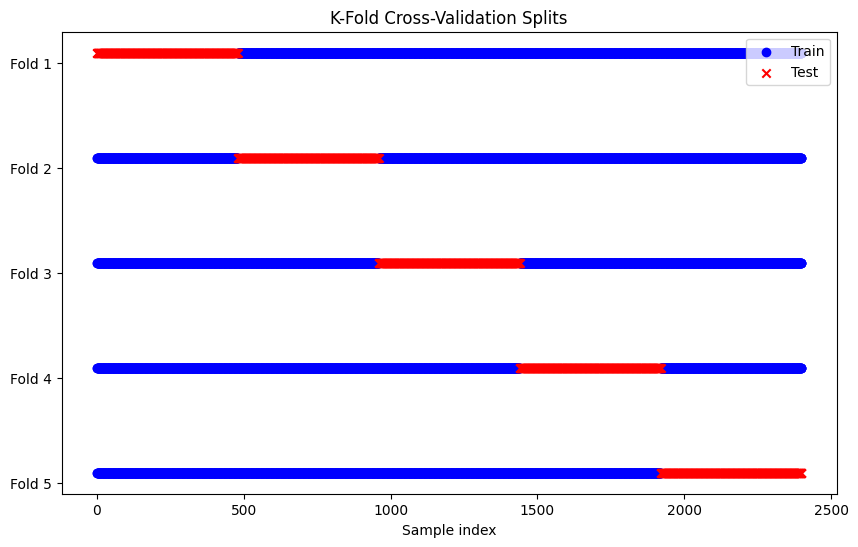

Fold 1
Epoch [20/2500], Train Loss: 0.046464, Val Loss: 0.046135, Train MAE: 0.168395, Val MAE: 0.168833, lr: [4.99921055216093e-06]
Epoch [40/2500], Train Loss: 0.037322, Val Loss: 0.037464, Train MAE: 0.150414, Val MAE: 0.152251, lr: [4.996842707275893e-06]
Epoch [60/2500], Train Loss: 0.031178, Val Loss: 0.031492, Train MAE: 0.135989, Val MAE: 0.138393, lr: [4.992897960926468e-06]
Epoch [80/2500], Train Loss: 0.025742, Val Loss: 0.026140, Train MAE: 0.121497, Val MAE: 0.124108, lr: [4.987378804699003e-06]
Epoch [100/2500], Train Loss: 0.021339, Val Loss: 0.021773, Train MAE: 0.108646, Val MAE: 0.111247, lr: [4.980288724610862e-06]
Epoch [120/2500], Train Loss: 0.017985, Val Loss: 0.018353, Train MAE: 0.098643, Val MAE: 0.101142, lr: [4.971632198908595e-06]
Epoch [140/2500], Train Loss: 0.015480, Val Loss: 0.015832, Train MAE: 0.091155, Val MAE: 0.093366, lr: [4.961414695239377e-06]
Epoch [160/2500], Train Loss: 0.013693, Val Loss: 0.013981, Train MAE: 0.085476, Val MAE: 0.087389, lr

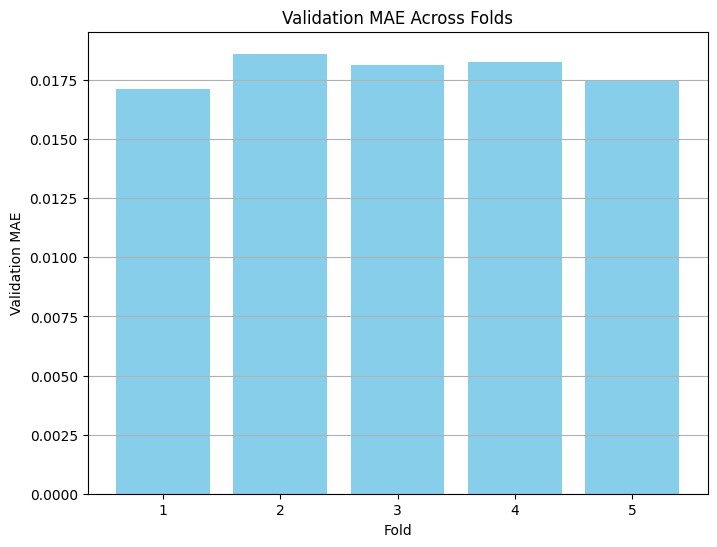

In [25]:
# -------------------------------
# Task 1: Perform Cross-Validation
# -------------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("\nStarting Task 1: Cross-Validation to Determine the Best Model\n")

# Choose the model architecture for cross-validation ('ffn' or 'lstm')
model_arch = 'ffn'  # Change to 'lstm' if you want to cross-validate the LSTM model

# Perform cross-validation
best_fold, cv_results = perform_cross_validation(
    model_arch=model_arch,
    X=train_inputs.numpy(),
    y=train_targets.numpy(),
    k_folds=5,
    num_epochs=2500,
    batch_size=16,
    learning_rate=5e-06,
    device=device
)



In [33]:
cv_results

{1: 0.01710710081582268,
 2: 0.018617051281034948,
 3: 0.018145754809180896,
 4: 0.018286030863722165,
 5: 0.01747021855165561}

In [42]:
device

device(type='cuda')

In [48]:

accumulated_training_results = {}
for s, a in zip(sample_sizes, accuracies):
    accumulated_training_results[s] = a

In [49]:
accumulated_training_results

{240: 0.09015081425507863,
 480: 0.056203951140244804,
 720: 0.02389122104893128,
 960: 0.02158922962844372,
 1200: 0.019084627218544484,
 1440: 0.017974030300974844,
 1680: 0.017680832309027512,
 1920: 0.01724910341203213,
 2160: 0.01712548963725567,
 2400: 0.016438440618415675}

In [50]:
cv_results

{1: 0.01710710081582268,
 2: 0.018617051281034948,
 3: 0.018145754809180896,
 4: 0.018286030863722165,
 5: 0.01747021855165561}


Training on dataset 1/10 with 240 samples
Epoch [20/2500], Train Loss: 0.086457, Val Loss: 0.079597, Train MAE: 0.236550, Val MAE: 0.225302, lr: [4.99921055216093e-06]
Epoch [40/2500], Train Loss: 0.071917, Val Loss: 0.067085, Train MAE: 0.215195, Val MAE: 0.206643, lr: [4.996842707275893e-06]
Epoch [60/2500], Train Loss: 0.062893, Val Loss: 0.059313, Train MAE: 0.200946, Val MAE: 0.194069, lr: [4.992897960926468e-06]
Epoch [80/2500], Train Loss: 0.055680, Val Loss: 0.053362, Train MAE: 0.188464, Val MAE: 0.183893, lr: [4.987378804699003e-06]
Epoch [100/2500], Train Loss: 0.051057, Val Loss: 0.049702, Train MAE: 0.179947, Val MAE: 0.177187, lr: [4.980288724610862e-06]
Epoch [120/2500], Train Loss: 0.047804, Val Loss: 0.047144, Train MAE: 0.173420, Val MAE: 0.172282, lr: [4.971632198908595e-06]
Epoch [140/2500], Train Loss: 0.045479, Val Loss: 0.045313, Train MAE: 0.168762, Val MAE: 0.168709, lr: [4.961414695239377e-06]
Epoch [160/2500], Train Loss: 0.043679, Val Loss: 0.043906, Train 

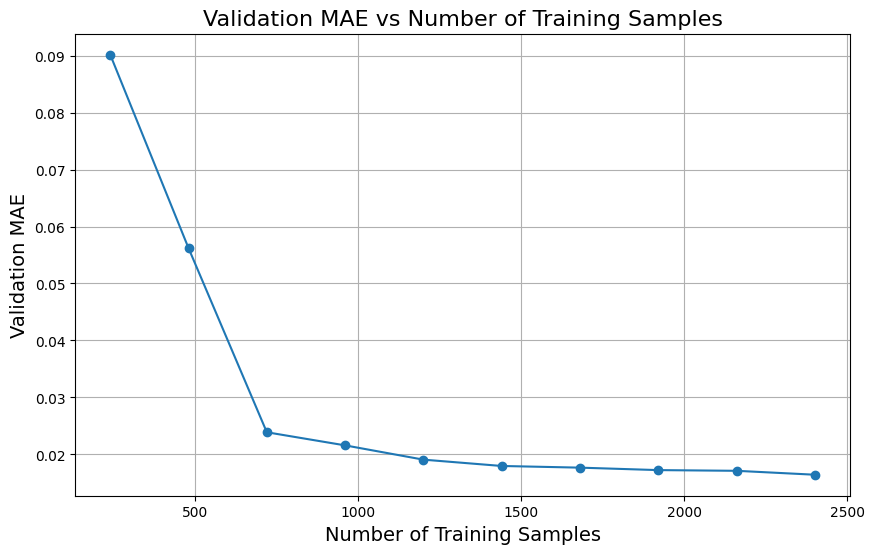

In [43]:
# Prepare data for Task 2 (Using the entire training set from Task 1)
# Assuming that after cross-validation, you decide to use the entire training set

# Note: Depending on your cross-validation strategy, you might want to retrain the model on the entire training set.
# Here, we proceed with splitting the existing train_inputs and train_targets.

number_of_accumulated_datasets = 10
sample_sizes, accuracies = train_accumulated_datasets(
    X_train=train_inputs.numpy(),
    y_train=train_targets.numpy(),
    X_val=val_inputs.numpy(),
    y_val=val_targets.numpy(),
    number_of_accumulated_datasets=number_of_accumulated_datasets,
    model_arch=model_arch,
    device=device,
    num_epochs=2500,
    batch_size=16,
    learning_rate=5e-06,
)

# Plot Accuracy vs Number of Samples
plt.figure(figsize=(10,6))
plt.plot(sample_sizes, accuracies, marker='o', linestyle='-')
plt.xlabel('Number of Training Samples', fontsize=14)
plt.ylabel('Validation MAE', fontsize=14)
plt.title('Validation MAE vs Number of Training Samples', fontsize=16)
plt.grid(True)
plt.show()


In [59]:
benchmark_results = {
    "cross_validation": {
        "k_folds": 5,
        "results": cv_results
    },
    "accumulated_datasets": {
        "nb_datasets": 10,
        "results_val_mae": accumulated_training_results_val,
        "results_train_mae": accumulated_training_results_train
    }
}


In [56]:
accumulated_training_results_val = accumulated_training_results

In [57]:
accumulated_training_results_train = { 240: 0.079548,
480: 0.044727,
720: 0.019575,
960: 0.018508,
1200: 0.017327,
1440: 0.016291,
1680: 0.015791,
1920: 0.015558,
2160: 0.015464,
2400: 0.014501 }


In [60]:
# benchmark_results
# torch.save(benchmark_results, "benchmark_results.pt")

In [54]:
benchmark_results

{'cross_validation': {'k_folds': 5,
  'results': {1: 0.01710710081582268,
   2: 0.018617051281034948,
   3: 0.018145754809180896,
   4: 0.018286030863722165,
   5: 0.01747021855165561}},
 'accumulated_datasets': {'nb_datasets': 10,
  'results': {240: 0.09015081425507863,
   480: 0.056203951140244804,
   720: 0.02389122104893128,
   960: 0.02158922962844372,
   1200: 0.019084627218544484,
   1440: 0.017974030300974844,
   1680: 0.017680832309027512,
   1920: 0.01724910341203213,
   2160: 0.01712548963725567,
   2400: 0.016438440618415675}}}

In [100]:
Line2D.markers

{'.': 'point',
 ',': 'pixel',
 'o': 'circle',
 'v': 'triangle_down',
 '^': 'triangle_up',
 '<': 'triangle_left',
 '>': 'triangle_right',
 '1': 'tri_down',
 '2': 'tri_up',
 '3': 'tri_left',
 '4': 'tri_right',
 '8': 'octagon',
 's': 'square',
 'p': 'pentagon',
 '*': 'star',
 'h': 'hexagon1',
 'H': 'hexagon2',
 '+': 'plus',
 'x': 'x',
 'D': 'diamond',
 'd': 'thin_diamond',
 '|': 'vline',
 '_': 'hline',
 'P': 'plus_filled',
 'X': 'x_filled',
 0: 'tickleft',
 1: 'tickright',
 2: 'tickup',
 3: 'tickdown',
 4: 'caretleft',
 5: 'caretright',
 6: 'caretup',
 7: 'caretdown',
 8: 'caretleftbase',
 9: 'caretrightbase',
 10: 'caretupbase',
 11: 'caretdownbase',
 'None': 'nothing',
 'none': 'nothing',
 ' ': 'nothing',
 '': 'nothing'}


Generating Validation MAE Across Folds Plot



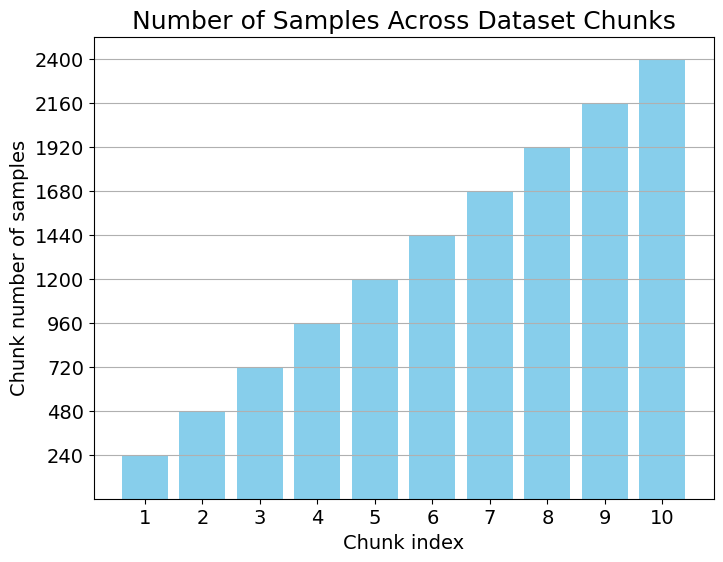

In [347]:
all_dataset_chunks_sizes = list(benchmark_results['accumulated_datasets']['results_val_mae'].keys())
chunk_indices = np.arange(len(all_dataset_chunks_sizes)) + 1

# Plot Validation MAE Across Folds
print("\nGenerating Validation MAE Across Folds Plot\n")
plt.figure(figsize=(8,6))
plt.bar(chunk_indices, all_dataset_chunks_sizes, color='skyblue')
plt.xlabel('Chunk index', fontsize=14)
plt.ylabel('Chunk number of samples', fontsize=14)
plt.title('Number of Samples Across Dataset Chunks', fontsize=18)
plt.xticks(chunk_indices, fontsize=14)
plt.yticks(all_dataset_chunks_sizes, fontsize=14)
plt.grid(axis='y')

plt.savefig(f"./figs/plot_benchmark_accumulated_training_chunk_sizes.eps", bbox_inches = 'tight', format='eps')

plt.show()

In [449]:
benchmark_results

{'cross_validation': {'k_folds': 5,
  'results': {1: 0.01710710081582268,
   2: 0.018617051281034948,
   3: 0.018145754809180896,
   4: 0.018286030863722165,
   5: 0.01747021855165561},
  'results_unscaled': {1: 5.950235893644204e-06,
   2: 6.475430755851411e-06,
   3: 6.3115032024006195e-06,
   4: 6.360294381206221e-06,
   5: 6.076536440337276e-06}},
 'accumulated_datasets': {'nb_datasets': 10,
  'results_val_mae': {240: 0.09015081425507863,
   480: 0.056203951140244804,
   720: 0.02389122104893128,
   960: 0.02158922962844372,
   1200: 0.019084627218544484,
   1440: 0.017974030300974844,
   1680: 0.017680832309027512,
   1920: 0.01724910341203213,
   2160: 0.01712548963725567,
   2400: 0.016438440618415675},
  'results_train_mae': {240: 0.079548,
   480: 0.044727,
   720: 0.019575,
   960: 0.018508,
   1200: 0.017327,
   1440: 0.016291,
   1680: 0.015791,
   1920: 0.015558,
   2160: 0.015464,
   2400: 0.014501},
  'results_val_mae_unscaled': {240: 3.135648854805817e-05,
   480: 1.954

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


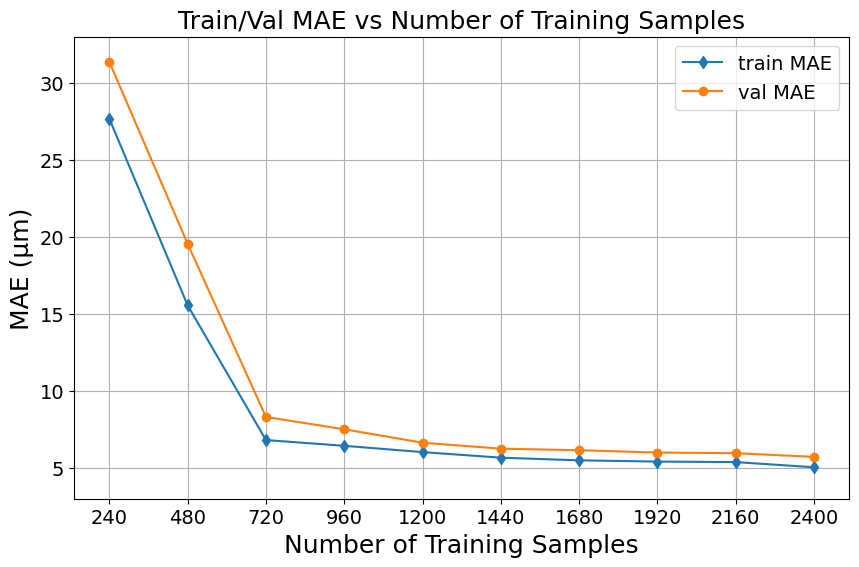

In [483]:
# Plot Accuracy vs Number of Samples
plt.figure(figsize=(10,6))
markers = ['d', 'o']
for ix, acc_result in enumerate([benchmark_results['accumulated_datasets']['results_train_mae_unscaled'], benchmark_results['accumulated_datasets']['results_val_mae_unscaled']]):
    sample_sizes = acc_result.keys()
    accuracies = list(acc_result.values())
    accuracies = np.array(accuracies) * 1e6
    marker = markers[ix]
    plt.plot(sample_sizes, accuracies, marker=marker, linestyle='-')
    plt.xticks(list(sample_sizes), fontsize=14)
    plt.yticks(fontsize=14)
plt.ylim([3, 33])
plt.xlabel('Number of Training Samples', fontsize=18)
plt.ylabel('MAE (µm)', fontsize=18)
plt.title('Train/Val MAE vs Number of Training Samples', fontsize=18)
plt.legend(['train MAE', 'val MAE'], fontsize=14)
plt.grid(True)
plt.minorticks_off()
plt.savefig(f"./figs/plot_bechmark_accumuluated_datasets_Mixed-data.eps", bbox_inches = 'tight', format='eps')
plt.show()

In [117]:
benchmark_results['cross_validation']

{'k_folds': 5,
 'results': {1: 0.01710710081582268,
  2: 0.018617051281034948,
  3: 0.018145754809180896,
  4: 0.018286030863722165,
  5: 0.01747021855165561}}

In [406]:
accumulated_training_results_val

{240: 0.09015081425507863,
 480: 0.056203951140244804,
 720: 0.02389122104893128,
 960: 0.02158922962844372,
 1200: 0.019084627218544484,
 1440: 0.017974030300974844,
 1680: 0.017680832309027512,
 1920: 0.01724910341203213,
 2160: 0.01712548963725567,
 2400: 0.016438440618415675}

In [407]:
dataset_scalers['target_scaler'].data_range_

array([0.00034573, 0.00041267, 0.00031658, 0.00035579, 0.00031761,
       0.00033856])

In [408]:
for minf, maxf in zip(dataset_scalers['target_scaler'].data_min_, dataset_scalers['target_scaler'].data_max_):
    print(minf, maxf, maxf - minf)

-0.0001699429121799767 0.00017578680126462132 0.000345729713444598
-0.0002492835046723485 0.00016338664863724262 0.0004126701533095911
-0.0001636710367165506 0.00015290679584722966 0.00031657783256378025
-0.00018059663125313818 0.00017518975073471665 0.00035578638198785484
-0.0001619960821699351 0.0001556106290081516 0.0003176067111780867
-0.00015079036529641598 0.00018777430523186922 0.0003385646705282852


In [116]:
mean_min, mean_max = dataset_scalers['target_scaler'].data_min_.mean(), dataset_scalers['target_scaler'].data_max_.mean()
mean_scaler = mean_max - mean_min
mean_scaler

0.00034782257716869935

In [117]:
mean_scaler

0.00034782257716869935

In [440]:
benchmark_results['accumulated_datasets']['results_val_mae_unscaled'] = {}
benchmark_results['accumulated_datasets']['results_train_mae_unscaled'] = {}

In [445]:
benchmark_results['cross_validation']['results_unscaled'] = {}

In [ ]:
for ii, accc in accumulated_training_results_val.items():
    mean_unscaled = accc * mean_scaler
    print(f"{mean_unscaled:.7f}", f"{mean_unscaled * 1e6:.2f}")
    benchmark_results['accumulated_datasets']['results_val_mae_unscaled'][ii] = mean_unscaled

In [442]:
for ii, accc in accumulated_training_results_train.items():
    mean_unscaled = accc * mean_scaler
    print(f"{mean_unscaled:.7f}", f"{mean_unscaled * 1e6:.2f}")
    benchmark_results['accumulated_datasets']['results_train_mae_unscaled'][ii] = mean_unscaled

0.0000277 27.67
0.0000156 15.56
0.0000068 6.81
0.0000064 6.44
0.0000060 6.03
0.0000057 5.67
0.0000055 5.49
0.0000054 5.41
0.0000054 5.38
0.0000050 5.04


In [446]:
benchmark_results['cross_validation']['results']

{1: 0.01710710081582268,
 2: 0.018617051281034948,
 3: 0.018145754809180896,
 4: 0.018286030863722165,
 5: 0.01747021855165561}

In [447]:
for ii, accc in benchmark_results['cross_validation']['results'].items():
    mean_unscaled = accc * mean_scaler
    print(f"{mean_unscaled:.7f}", f"{mean_unscaled * 1e6:.2f}")
    benchmark_results['cross_validation']['results_unscaled'][ii] = mean_unscaled

0.0000060 5.95
0.0000065 6.48
0.0000063 6.31
0.0000064 6.36
0.0000061 6.08


In [448]:

torch.save(benchmark_results, "benchmark_results.pt")

In [420]:
5.7e-6 * 1e6

5.699999999999999

In [390]:
single_value_reshaped

array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5]])

In [369]:
# dataset_scalers['target_scaler'].inverse_transform()

# .reshape(-1, 1, axis=0)

np.array(list(accumulated_training_results_val.values()))

array([0.09015081, 0.05620395, 0.02389122, 0.02158923, 0.01908463,
       0.01797403, 0.01768083, 0.0172491 , 0.01712549, 0.01643844])

In [355]:
def plot_cv_indices(cv, X, y, n_splits, ax, lw=10):
    nb_samples = train_inputs.numpy().shape[0]
    cmap_data = plt.cm.Paired
    """Create a sample plot for indices of a cross-validation object."""
    
    # Generate the training/testing visualizations for each CV split
    splits = list(cv.split(X=X, y=y))
    splits_indices = np.arange(len(splits))[::-1]
    
    for ii in splits_indices:
        (tr, tt) = splits[ii]
        # Fill in indices with the training/test 
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [len(splits) - ii - 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        xlim=[0, nb_samples]
    )
    ax.set_title("{} Cross-validation".format(type(cv).__name__), fontsize=18)
    # plt.rc('font', size=10)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    
    return ax

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


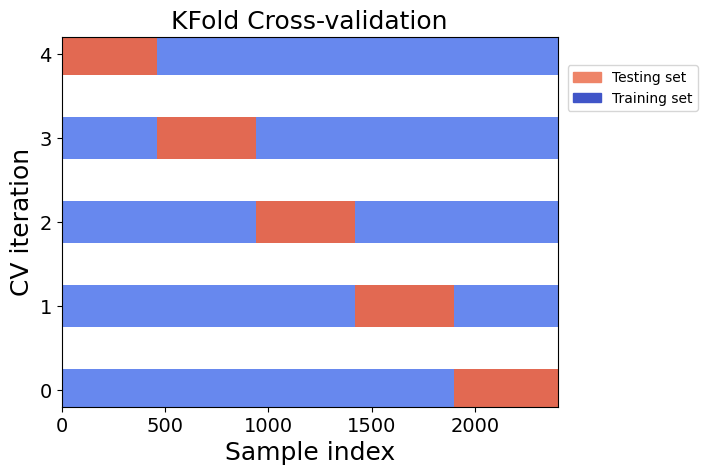

In [356]:
cmap_cv = plt.cm.coolwarm
cmap_data = plt.cm.Paired
kf = KFold(n_splits=5, shuffle=False)

fig, ax = plt.subplots()
plot_cv_indices(kf, train_inputs.numpy(), train_targets.numpy(), n_splits=5, ax=ax, lw=30)
plt.savefig("./figs/plot_cross_validation_train_test_folds.eps", bbox_inches = 'tight', format='eps')
show()

array([0.0171071 , 0.01861705, 0.01814575, 0.01828603, 0.01747022])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


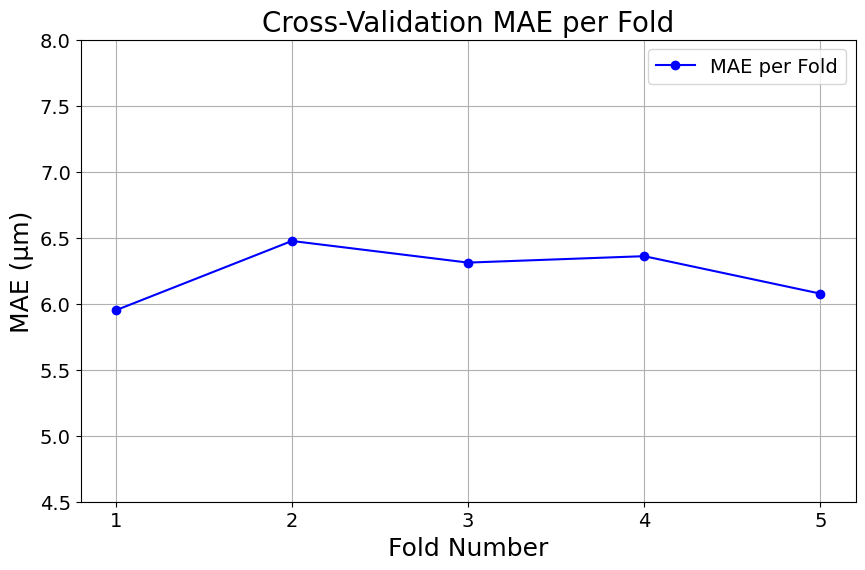

In [475]:

# Extract fold numbers and their corresponding accuracies
all_cv_mae_values = np.array(list(benchmark_results['cross_validation']['results_unscaled'].values()))
fold_numbers = list(benchmark_results['cross_validation']['results_unscaled'].keys())
accuracies = list(benchmark_results['cross_validation']['results_unscaled'].values())
accuracies = np.array(accuracies) * 1e6

# Plot Accuracy per Fold
plt.figure(figsize=(10, 6))
plt.plot(fold_numbers, accuracies, marker='o', linestyle='-', color='b', label='MAE per Fold')

# Customize the plot
plt.xticks(fold_numbers, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Fold Number', fontsize=18)
plt.ylabel('MAE (µm)', fontsize=18)
plt.title('Cross-Validation MAE per Fold', fontsize=20)
plt.legend(fontsize=14)
plt.grid(True)
plt.minorticks_off()
plt.ylim([4.5, 8])

plt.savefig("./figs/cross_validation_accuracy_folds.eps", bbox_inches='tight', format='eps')

plt.show()


In [23]:
# train_inputs

### Train model

In [245]:
n_samples, n_turns, input_size = train_inputs.shape
output_size = train_targets.shape[1]


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 'lstm' | 'ffn'
MODEL_ARCH = 'ffn'

In [246]:
input_tensors_scaled.shape
n_sample, n_revs, N_FODO, n_planes = input_tensors_scaled.shape

__main__.QuadErrorCorrectionLSTM

QuadErrorCorrectionLSTM(
  (lstm): LSTM(16, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=6, bias=True)
)
Epoch [10/600], Train Loss: 0.0146079, Val Loss: 0.0136282, Train MAE: 0.0884429, Val MAE: 0.0847004, lr: [0.00014285722857142853]
Epoch [20/600], Train Loss: 0.013126, Val Loss: 0.0122398, Train MAE: 0.0841738, Val MAE: 0.0815906, lr: [0.000285714357142857]
Epoch [30/600], Train Loss: 0.00268393, Val Loss: 0.002901, Train MAE: 0.0374313, Val MAE: 0.0391419, lr: [0.0004285714857142855]
Epoch [40/600], Train Loss: 0.00244643, Val Loss: 0.00308789, Train MAE: 0.0357488, Val MAE: 0.0415596, lr: [0.0005714286142857141]
Epoch [50/600], Train Loss: 0.00219387, Val Loss: 0.00214174, Train MAE: 0.0341329, Val MAE: 0.0328181, lr: [0.000714285742857143]
Epoch [60/600], Train Loss: 0.00156397, Val Loss: 0.00307633, Train MAE: 0.028414, Val MAE: 0.0427129, lr: [0.0008571428714285715]
Epoch [70/600], Train Loss: 0.00168, Val Loss: 0.00255853, Train MAE:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Epoch [600/600], Train Loss: 0.000104383, Val Loss: 0.000315218, Train MAE: 0.0072163, Val MAE: 0.0112907, lr: [3.571438214285713e-05]


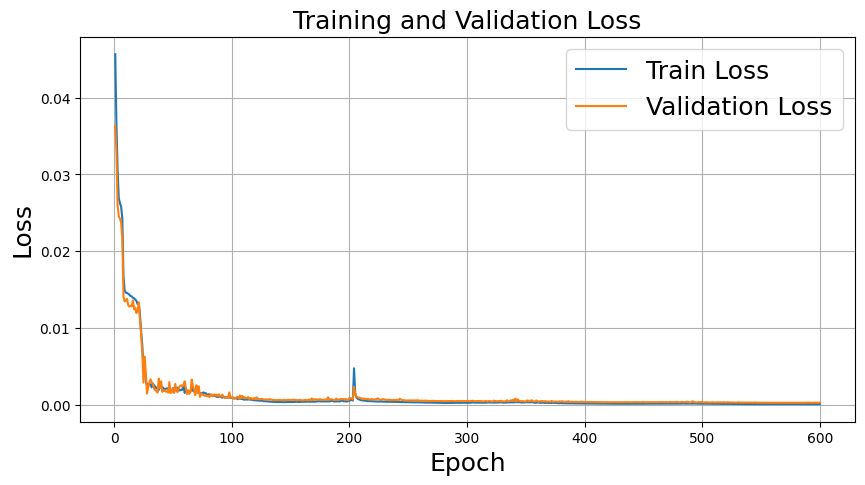

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


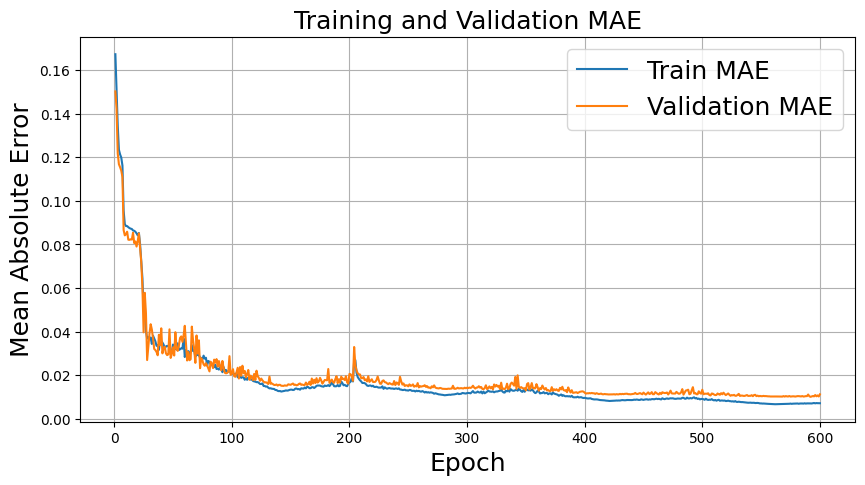

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


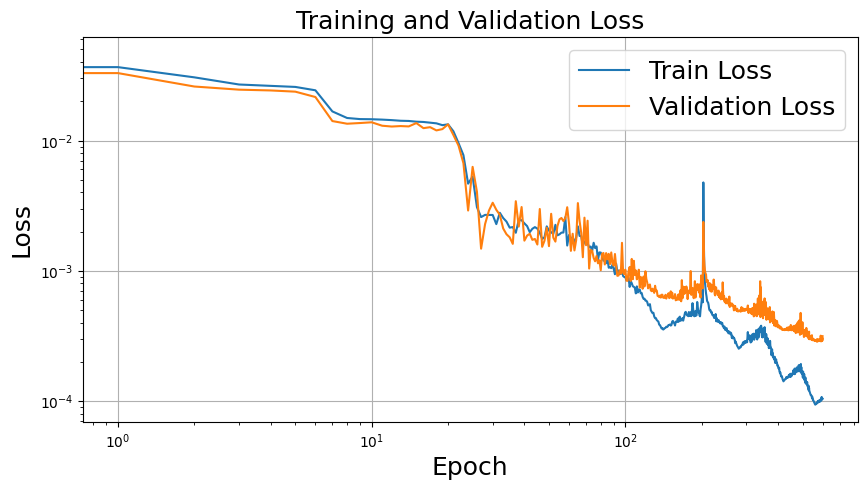

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


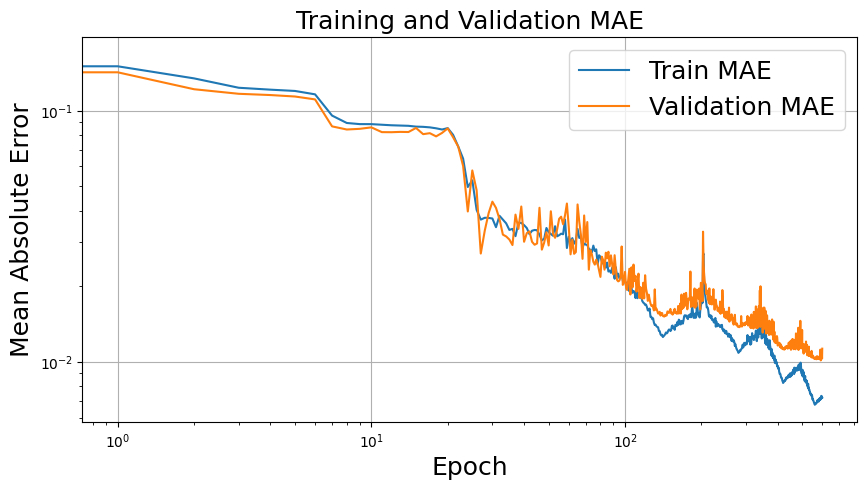

In [248]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MODEL_ARCH = 'lstm'

if MODEL_ARCH == 'ffn':

    #--------
    # FFN
    #--------
    fnn_hidden_size = 32
    nb_heads = None #output_size
    n_layers = 1
    add_dropout = False
    add_batch_norm = False
    model = SimpleFullyConnectedNetwork(n_turns * input_size, 
                       fnn_hidden_size, 
                       output_size, 
                       n_layers=n_layers , 
                       nb_heads=nb_heads,
                      add_batch_norm=add_batch_norm,
                      add_dropout=add_dropout)


elif MODEL_ARCH == 'lstm':

    #--------
    # LSTM
    #--------
    lstm_hidden_size = 256
    num_layers = 1
    is_bidirectional=True
    model = QuadErrorCorrectionLSTM(
        input_size=input_size,
        hidden_size=lstm_hidden_size,
        num_layers=num_layers,
        output_size=output_size,
        is_bidirectional=is_bidirectional)

model.to(device)

print(model)

# Load checkpoint state_dict
load_checkpoint = False

if load_checkpoint:
    # Quads MisAligh only
    # MODEL_LOAD_PATH = f'checkpoints/quad_error_correction_{MODEL_ARCH}.pth'
    
    # (agumented) Mixed with Quads and Dipoles tilt errors
    MODEL_LOAD_PATH = f'checkpoints/mix_quad_error_correction_{MODEL_ARCH}.pth'
    chkpnt_state_dict = torch.load(MODEL_LOAD_PATH)
    model.load_state_dict(chkpnt_state_dict)
    print("Checkpoint Loaded.")

else:
        
    
    # model.double()
    
    
    # -------------------------------
    # Define loss function, optimizer, and scheduler
    # -------------------------------

    if MODEL_ARCH == 'ffn':
        lr = 0.001
    elif MODEL_ARCH == 'lstm':
        lr = 0.001
    # lr = 5e-06
    num_epochs = 600  # Adjust as needed
    nb_epoch_log = 10  # Print logs every nb_epoch_log epochs
    
    
    # MSELoss | L1Loss
    
    criterion = nn.MSELoss(reduction='mean')
    
    # Adam | AdamW
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    scheduler = None
    
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=5e-10
    # )
    
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500, eta_min=0)

    for group in optimizer.param_groups:
        group['initial_lr'] = lr

    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs * 2, eta_min=5e-10, last_epoch=num_epochs)

    # gamma = 0.1
    # milestones = [100, 200, 300, 400]
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    scheduler = torch.optim.lr_scheduler.CyclicLR(
        optimizer,
        base_lr=1e-10,          # Lower bound of learning rate
        max_lr=0.001,           # Upper bound of learning rate
        step_size_up=70,      # Number of training iterations in the increasing half of a cycle
        mode='triangular2',     # 'triangular' CLR policy
        cycle_momentum=True,    # Whether to cyclically vary momentum
        base_momentum=0.8,      # Lower bound for momentum
        max_momentum=0.9        # Upper bound for momentum
    )

    
    # -------------------------------
    # Training loop with evaluation
    # -------------------------------
    
    
    # def compute_mae(outputs, targets):
    #     return torch.mean(torch.abs(outputs - targets))

    def compute_mae(outputs, targets, aggregate='mean'):
        absolute_errors = torch.abs(outputs - targets)  # Shape: (BATCH_SIZE, 6)
        
        # MAE for each output dimension
        mae_per_output = torch.mean(absolute_errors, dim=0)  # Shape: (nb_outputs,)
        
        if aggregate == 'sum':
            return mae_per_output.sum()
        elif aggregate == 'mean':
            return mae_per_output.mean()
        elif aggregate == 'none':
            return mae_per_output
        else:
            raise ValueError("Invalid aggregation method. Choose 'sum', 'mean', or 'none'.")
    
    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_mae = 0.0
        for batch_inputs, batch_targets in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)
    
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_inputs.size(0)
            train_mae += compute_mae(outputs, batch_targets).item() * batch_inputs.size(0)
    
        train_loss /= len(train_loader.dataset)
        train_mae /= len(train_loader.dataset)
    
        # Evaluation
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        with torch.no_grad():
            for batch_inputs, batch_targets in val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_targets = batch_targets.to(device)
    
                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_targets)
    
                val_loss += loss.item() * batch_inputs.size(0)
                val_mae += compute_mae(outputs, batch_targets).item() * batch_inputs.size(0)
    
        val_loss /= len(val_loader.dataset)
        val_mae /= len(val_loader.dataset)
    
        if scheduler:
            # Step the scheduler
            if type(scheduler) == torch.optim.lr_scheduler.ReduceLROnPlateau:
                scheduler.step(val_loss)
            else:
                scheduler.step() # Cosine
    
        # Record losses for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_maes.append(train_mae)
        val_maes.append(val_mae)
    
        # Print losses and MAE every nb_epoch_log epochs
        if (epoch + 1) % nb_epoch_log == 0:
            msg_str = f"Epoch [{epoch+1}/{num_epochs}], " \
                  f"Train Loss: {train_loss:.6}, Val Loss: {val_loss:.6}, " \
                  f"Train MAE: {train_mae:.6}, Val MAE: {val_mae:.6}, "
    
            if scheduler:
                # current_lr = optimizer.param_groups[0]['lr']
                msg_str += f"lr: {scheduler.get_last_lr()}"
            print(msg_str)
    
    # Plot training and validation loss
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch', fontsize=18 )
    plt.ylabel('Loss', fontsize=18)
    plt.title('Training and Validation Loss', fontsize=18)
    plt.legend(fontsize=18)
    plt.grid(True)
    plt.savefig("./figs/train_loss.eps", bbox_inches = 'tight', format='eps')
    plt.show()
    
    # Plot training and validation MAE
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_maes, label='Train MAE')
    plt.plot(range(1, num_epochs+1), val_maes, label='Validation MAE')
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Mean Absolute Error', fontsize=18)
    plt.title('Training and Validation MAE', fontsize=18)
    plt.legend(fontsize=18)
    plt.grid(True)
    plt.savefig("./figs/acc.eps", bbox_inches = 'tight', format='eps')
    plt.show()
    
    
    # Plot training and validation loss
    plt.figure(figsize=(10,5))
    loglog(train_losses, label='Train Loss')
    loglog(val_losses, label='Validation Loss')
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.title('Training and Validation Loss', fontsize=18)
    plt.legend(fontsize=18)
    plt.grid(True)
    plt.savefig("./figs/train_loss_loglog.eps", bbox_inches = 'tight', format='eps')
    plt.show()
    
    # Plot training and validation MAE
    plt.figure(figsize=(10,5))
    loglog(train_maes, label='Train MAE')
    loglog(val_maes, label='Validation MAE')
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Mean Absolute Error', fontsize=18)
    plt.title('Training and Validation MAE', fontsize=18)
    plt.legend(fontsize=18)
    plt.grid(True)
    plt.savefig("./figs/acc_loglog.eps", bbox_inches = 'tight', format='eps')
    plt.show()

In [296]:
cont_num_epochs = 100

In [297]:

for epoch in range(cont_num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    for batch_inputs, batch_targets in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_inputs.size(0)
        train_mae += compute_mae(outputs, batch_targets).item() * batch_inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_mae /= len(train_loader.dataset)

    # Evaluation
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in val_loader:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)

            val_loss += loss.item() * batch_inputs.size(0)
            val_mae += compute_mae(outputs, batch_targets).item() * batch_inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_mae /= len(val_loader.dataset)

    if scheduler:
        # Step the scheduler
        if type(scheduler) == torch.optim.lr_scheduler.ReduceLROnPlateau:
            scheduler.step(val_loss)
        else:
            scheduler.step() # Cosine

    # Record losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_maes.append(train_mae)
    val_maes.append(val_mae)

    # Print losses and MAE every nb_epoch_log epochs
    if (epoch + 1) % nb_epoch_log == 0:
        msg_str = f"Epoch [{epoch+1}/{num_epochs}], " \
              f"Train Loss: {train_loss:.6}, Val Loss: {val_loss:.6}, " \
              f"Train MAE: {train_mae:.6}, Val MAE: {val_mae:.6}, "

        if scheduler:
            # current_lr = optimizer.param_groups[0]['lr']
            msg_str += f"lr: {scheduler.get_last_lr()}"
        print(msg_str)

Epoch [10/600], Train Loss: 5.80127e-05, Val Loss: 0.000252909, Train MAE: 0.00541341, Val MAE: 0.00935499, lr: [6.80813503348216e-06]
Epoch [20/600], Train Loss: 5.77424e-05, Val Loss: 0.000250588, Train MAE: 0.00540389, Val MAE: 0.00930807, lr: [7.700992087053585e-06]
Epoch [30/600], Train Loss: 5.64531e-05, Val Loss: 0.00024796, Train MAE: 0.00533234, Val MAE: 0.00922323, lr: [6.5849207700892764e-06]
Epoch [40/600], Train Loss: 5.55809e-05, Val Loss: 0.000249482, Train MAE: 0.00528907, Val MAE: 0.00932022, lr: [5.468849453124995e-06]
Epoch [50/600], Train Loss: 5.56687e-05, Val Loss: 0.000249048, Train MAE: 0.00531407, Val MAE: 0.00926243, lr: [4.352778136160713e-06]
Epoch [60/600], Train Loss: 5.44619e-05, Val Loss: 0.000248869, Train MAE: 0.00523677, Val MAE: 0.00924108, lr: [3.236706819196431e-06]
Epoch [70/600], Train Loss: 5.38583e-05, Val Loss: 0.000248323, Train MAE: 0.00519424, Val MAE: 0.00921078, lr: [2.1206355022321488e-06]
Epoch [80/600], Train Loss: 5.32494e-05, Val Los

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


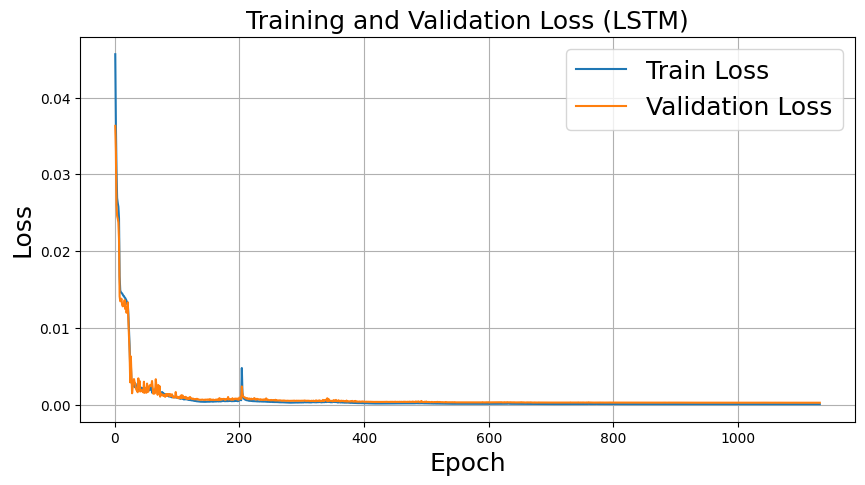

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


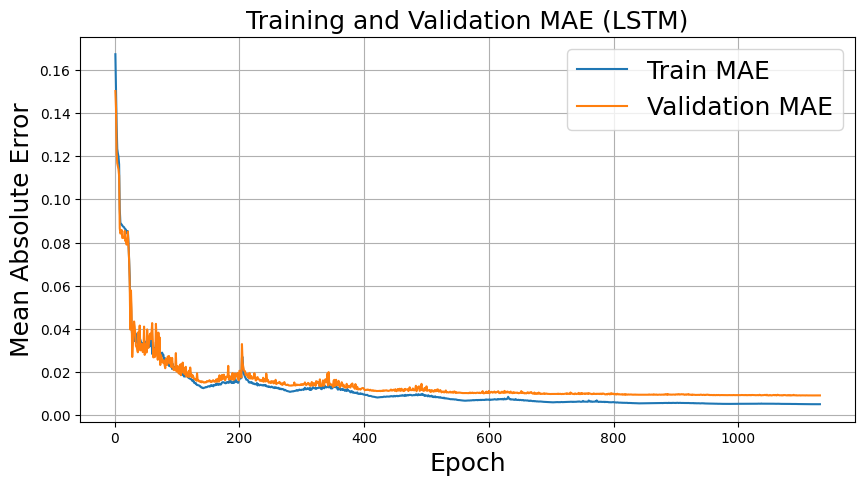

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


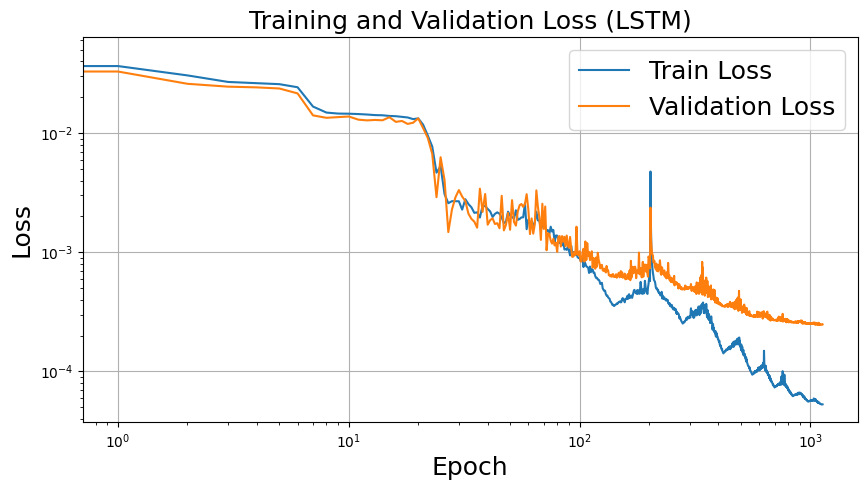

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


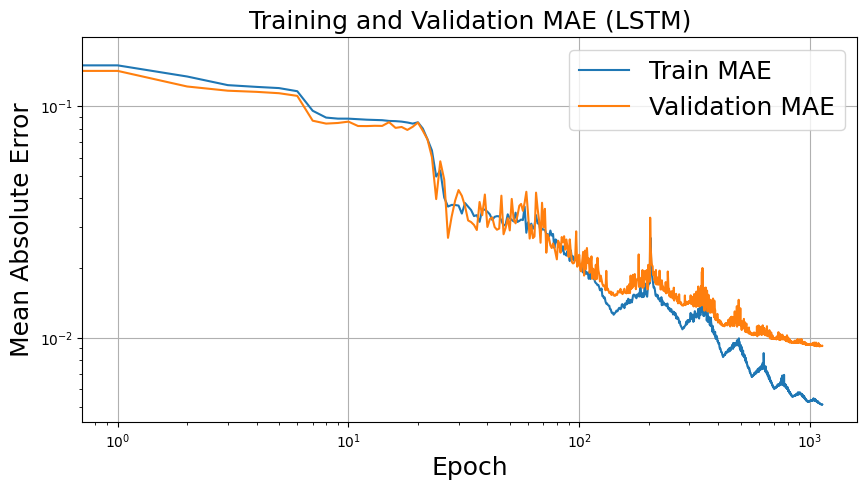

In [299]:
# Plot training and validation loss
plt.figure(figsize=(10,5))
plt.plot(range(1, 1131+1), train_losses, label='Train Loss')
plt.plot(range(1, 1131+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch', fontsize=18 )
plt.ylabel('Loss', fontsize=18)
plt.title(f'Training and Validation Loss ({MODEL_ARCH.upper()})', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.savefig(f"./figs/train_loss_{MODEL_ARCH.upper()}.eps", bbox_inches = 'tight', format='eps')
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(10,5))
plt.plot(range(1, 1131+1), train_maes, label='Train MAE')
plt.plot(range(1, 1131+1), val_maes, label='Validation MAE')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Mean Absolute Error', fontsize=18)
plt.title(f'Training and Validation MAE ({MODEL_ARCH.upper()})', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.savefig(f"./figs/acc_{MODEL_ARCH.upper()}.eps", bbox_inches = 'tight', format='eps')
plt.show()


# Plot training and validation loss
plt.figure(figsize=(10,5))
loglog(train_losses, label='Train Loss')
loglog(val_losses, label='Validation Loss')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.title(f'Training and Validation Loss ({MODEL_ARCH.upper()})', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.savefig(f"./figs/train_loss_loglog_{MODEL_ARCH.upper()}.eps", bbox_inches = 'tight', format='eps')
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(10,5))
loglog(train_maes, label='Train MAE')
loglog(val_maes, label='Validation MAE')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Mean Absolute Error', fontsize=18)
plt.title(f'Training and Validation MAE ({MODEL_ARCH.upper()})', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.savefig(f"./figs/acc_loglog_{MODEL_ARCH.upper()}.eps", bbox_inches = 'tight', format='eps')
plt.show()

In [ ]:


# Function to scale tensor from [-1,1] to [0,1]
def scale_tensor(tensor):
    return (tensor + 1) / 2

# Function to prepare RGB image by combining two channels
def prepare_rgb_image(tensor1, tensor2):
    tensor1 = scale_tensor(tensor1)
    tensor2 = scale_tensor(tensor2)
    
    # Initialize RGB image with zeros
    rgb_image = np.zeros((tensor1.shape[0], tensor1.shape[1], 3))
    
    # Assign channels
    rgb_image[:, :, 0] = tensor1  # Red
    rgb_image[:, :, 1] = tensor2  # Green
    # Blue channel remains zero
    
    return rgb_image

# Function to visualize a single sample's channels
def visualize_sample_channels(sample, sample_idx):
    # Separate channels
    channel_1 = scale_tensor(sample[0]).cpu().numpy()
    channel_2 = scale_tensor(sample[1]).cpu().numpy()
    
    # Plot channels side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(channel_1, cmap='gray', aspect='auto')
    axes[0].set_title(f'Sample {sample_idx} - Channel 1')
    axes[0].axis('off')
    
    axes[1].imshow(channel_2, cmap='gray', aspect='auto')
    axes[1].set_title(f'Sample {sample_idx} - Channel 2')
    axes[1].axis('off')
    
    plt.show()

# Function to visualize a single sample as RGB
def visualize_sample_rgb(sample, sample_idx):
    # Prepare RGB image
    rgb_image = prepare_rgb_image(sample[0], sample[1])
    
    # Plot RGB image
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_image, aspect='auto')
    plt.title(f'Sample {sample_idx} - Combined Channels (RGB)')
    plt.axis('off')
    plt.show()

# Function to visualize a grid of samples' channels
def visualize_grid_channels(samples, start_idx=1):
    num_samples = samples.shape[0]
    num_cols = 2  # Two channels per sample
    num_rows = num_samples
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))
    
    for i in range(num_samples):
        sample = samples[i]
        channel_1 = scale_tensor(sample[0]).cpu().numpy()
        channel_2 = scale_tensor(sample[1]).cpu().numpy()
        
        # Plot Channel 1
        axes[i, 0].imshow(channel_1, cmap='gray', aspect='auto')
        axes[i, 0].set_title(f'Sample {start_idx + i} - Channel 1')
        axes[i, 0].axis('off')
        
        # Plot Channel 2
        axes[i, 1].imshow(channel_2, cmap='gray', aspect='auto')
        axes[i, 1].set_title(f'Sample {start_idx + i} - Channel 2')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Function to visualize a grid of samples as RGB
def visualize_grid_rgb(samples, start_idx=1):
    num_samples = samples.shape[0]
    fig, axes = plt.subplots(1, num_samples, figsize=(6 * num_samples, 6))
    
    for i in range(num_samples):
        sample = samples[i]
        rgb_image = prepare_rgb_image(sample[0], sample[1])
        
        axes[i].imshow(rgb_image, aspect='auto')
        axes[i].set_title(f'Sample {start_idx + i} - RGB')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example Usage:

# Select samples to visualize
start_ix_viz = np.random.randint(input_data_cnn.shape[0])
num_samples_to_visualize = 1
samples = input_data_cnn[start_ix_viz:start_ix_viz+num_samples_to_visualize]

for i in range(num_samples_to_visualize):
    sample = samples[i]
    visualize_sample_channels(sample, i+1)
    visualize_sample_rgb(sample, i+1)

# Visualize a grid of samples' channels
# visualize_grid_channels(samples)

# Visualize a grid of samples as RGB
# visualize_grid_rgb(samples)


In [94]:
train_targets.shape[1]

6

In [163]:
target_tensors_unscaled = data_automation.data_scalers['target_scaler'].inverse_transform(target_tensors_scaled)
target_tensors_unscaled = torch.from_numpy(target_tensors_unscaled)
target_tensors_unscaled_sigmoid = 1 / (target_tensors_unscaled.sigmoid() - 1)
# target_tensors_unscaled = 1 / (target_tensors_scaled.sigmoid() - 1)

In [168]:
target_tensors_unscaled_sigmoid.min()

tensor(-2.0002, dtype=torch.float64)

In [167]:
target_tensors_unscaled.min()

tensor(-0.0002, dtype=torch.float64)

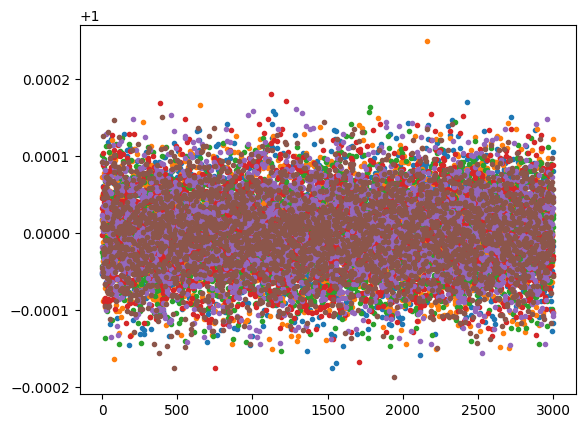

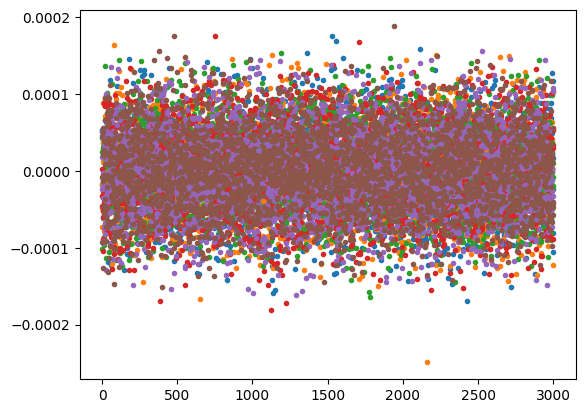

In [211]:
plot(1 / target_tensors_unscaled.sigmoid() - 1, '.')
show()
plot(target_tensors_unscaled, '.')

In [217]:
input_tensors_scaled.shape

torch.Size([3000, 101, 8, 2])

In [241]:


# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define compute_mae as per your original code
def compute_mae(outputs, targets, aggregate='mean'):
    """
    Compute Mean Absolute Error (MAE).

    Args:
        outputs (torch.Tensor): Model predictions.
        targets (torch.Tensor): Ground truth targets.
        aggregate (str): How to aggregate MAE ('mean', 'sum', 'none').

    Returns:
        torch.Tensor: MAE value.
    """
    absolute_errors = torch.abs(outputs - targets)  # Shape: (batch_size, output_size)
    
    if outputs.shape[1] > targets.shape[1]:
        # Multiple heads
        num_heads = outputs.shape[1] // targets.shape[1]
        absolute_errors = absolute_errors.view(-1, num_heads, targets.shape[1])
        mae_per_head = torch.mean(absolute_errors, dim=2)  # Shape: (batch_size, num_heads)
    else:
        # Single head
        mae_per_head = torch.mean(absolute_errors, dim=1)  # Shape: (batch_size,)
    
    if aggregate == 'sum':
        return mae_per_head.sum()
    elif aggregate == 'mean':
        return mae_per_head.mean()
    elif aggregate == 'none':
        return mae_per_head
    else:
        raise ValueError("Invalid aggregation method. Choose 'sum', 'mean', or 'none'.")

# --------------------------- 1. Data Preparation ---------------------------

# For demonstration purposes, we'll create dummy data.
# Replace this with your actual data loading mechanism.

output_size = train_targets.shape[1]

# Reshape input data for CNN
input_data = input_tensors_scaled  # Shape: (n_samples, 101, N_FODO, 2)
input_data_cnn = input_data.permute(0, 3, 1, 2)  # Shape: (n_samples, 2, 101, N_FODO)

print(f"CNN Input Data Shape: {input_data_cnn.shape}")  # Verify the shape

# Convert to numpy for train_test_split
input_data_cnn_np = input_data_cnn.numpy()

# target_tensors_unscaled = data_automation.data_scalers['target_scaler'].inverse_transform(target_tensors_scaled)
# target_tensors_unscaled = torch.from_numpy(target_tensors_unscaled)
# target_tensors_unscaled_sigmoid = 1 / target_tensors_unscaled.sigmoid() - 1

# target_tensors_scaled_sigmoid = 1 / target_tensors_scaled.sigmoid() - 1
# target_data_np = target_tensors_scaled_sigmoid.numpy()

target_data_np = target_tensors_scaled.numpy()

# Split data into training and validation sets
train_inputs_cnn, val_inputs_cnn, train_targets, val_targets = train_test_split(
    input_data_cnn_np, target_data_np, test_size=0.10, shuffle=True, random_state=42
)

# Convert back to tensors
train_inputs_cnn = torch.tensor(train_inputs_cnn, dtype=torch.float32)
val_inputs_cnn = torch.tensor(val_inputs_cnn, dtype=torch.float32)
train_targets = torch.tensor(train_targets, dtype=torch.float32)
val_targets = torch.tensor(val_targets, dtype=torch.float32)

# Create datasets and data loaders
train_dataset_cnn = TensorDataset(train_inputs_cnn, train_targets)
val_dataset_cnn = TensorDataset(val_inputs_cnn, val_targets)

batch_size = 32
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=batch_size, shuffle=True)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=batch_size, shuffle=False)

# --------------------------- 2. Define SimpleCNN ----------------------------


# ------------------------ 3. Model Initialization --------------------------

# Initialize the SimpleCNN
MODEL_ARCH = 'cnn'  # Options: 'ffn', 'lstm', 'cnn'

if MODEL_ARCH == 'cnn':
    N_FODO = input_data_cnn.shape[3]  # Number of FODO cells
    model = SimpleCNN(
        input_channels=n_planes,
        hidden_size=512,  # Example hidden size; adjust as needed
        output_size=train_targets.shape[1],  # Assuming n_errors=1
        n_layers=1,  # Example number of layers; adjust as needed
        nb_heads=None,#, output_size,  # Set to desired number of heads or None
        add_batch_norm=True,  # Example: disable batch norm
        add_dropout=False,  # Example: disable dropout
        down_s_factor=1,  # Example downsampling factor
        act='relu',  # or 'elu'
        target_height=24,  # Adjust based on requirements
        target_width=8     # Adjust based on requirements
    )
else:
    # Define other architectures (FFN, LSTM) here
    raise ValueError(f"Unsupported MODEL_ARCH: {MODEL_ARCH}")

model.to(device)
print(model)

# --------------------- 4. Define Loss, Optimizer, Scheduler -----------------

# Define loss function
criterion = nn.MSELoss(reduction='mean')

lr = 0.001

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# Define scheduler
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-7,          
    max_lr=lr,           
    step_size_up=70,
    mode='triangular2',
    cycle_momentum=False
)

# Note: Adam optimizer does not use momentum in the same way SGD does.
# Hence, cycle_momentum is set to False.

# --------------------------- 5. Training Loop ------------------------------

# Training configuration
num_epochs = 600
nb_epoch_log = 10  # Print logs every 10 epochs

train_losses = []
val_losses = []
train_maes = []
val_maes = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    for batch_inputs, batch_targets in train_loader_cnn:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_inputs.size(0)
        train_mae += compute_mae(outputs, batch_targets).item() * batch_inputs.size(0)

    train_loss /= len(train_loader_cnn.dataset)
    train_mae /= len(train_loader_cnn.dataset)

    # Evaluation Phase
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in val_loader_cnn:
            batch_inputs = batch_inputs.to(device)
            batch_targets = batch_targets.to(device)

            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)

            val_loss += loss.item() * batch_inputs.size(0)
            val_mae += compute_mae(outputs, batch_targets).item() * batch_inputs.size(0)

    val_loss /= len(val_loader_cnn.dataset)
    val_mae /= len(val_loader_cnn.dataset)

    # Scheduler Step
    if scheduler:
        scheduler.step()

    # Record losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_maes.append(train_mae)
    val_maes.append(val_mae)

    # Logging
    if (epoch + 1) % nb_epoch_log == 0:
        current_lr = scheduler.get_last_lr()[0]
        msg_str = (f"Epoch [{epoch+1}/{num_epochs}], "
                   f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, "
                   f"Train MAE: {train_mae:.6f}, Val MAE: {val_mae:.6f}, "
                   f"LR: {current_lr:.6f}")
        print(msg_str)

# --------------------------- 6. Plotting Results ---------------------------

# # Plot Training and Validation Loss
# plt.figure(figsize=(10,5))
# plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
# plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
# plt.xlabel('Epoch', fontsize=14)
# plt.ylabel('Loss', fontsize=14)
# plt.title('Training and Validation Loss', fontsize=16)
# plt.legend(fontsize=12)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Plot Training and Validation MAE
# plt.figure(figsize=(10,5))
# plt.plot(range(1, num_epochs+1), train_maes, label='Train MAE')
# plt.plot(range(1, num_epochs+1), val_maes, label='Validation MAE')
# plt.xlabel('Epoch', fontsize=14)
# plt.ylabel('Mean Absolute Error', fontsize=14)
# plt.title('Training and Validation MAE', fontsize=16)
# plt.legend(fontsize=12)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# Plot Training and Validation Loss (Log-Log)
plt.figure(figsize=(10,5))
plt.loglog(train_losses, label='Train Loss')
plt.loglog(val_losses, label='Validation Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss (Log-Log)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# Plot Training and Validation MAE (Log-Log)
plt.figure(figsize=(10,5))
plt.loglog(train_maes, label='Train MAE')
plt.loglog(val_maes, label='Validation MAE')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.title('Training and Validation MAE (Log-Log)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()



Using device: cuda
CNN Input Data Shape: torch.Size([3000, 2, 101, 8])
Flatten size after adaptive pooling: 98304 (Channels: 512, Height: 24, Width: 8)
SimpleCNN(
  (conv_layers): ModuleList(
    (0): Conv2d(2, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=True)
  )
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(24, 8))
  (fc): Sequential(
    (0): Linear(in_features=98304, out_features=256, bias=True)
    (1): ReLU()
    (bn_fc): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (output_layer): Linear(in_features=256, out_features=6, bias=True)
  )
)
Epoch [10/600], Train Loss: 0.017802, Val Loss: 0.019486, Train MAE: 0.102604, Val MAE: 0.106424, LR: 0.000143
Epoch [20/600], Train Loss: 0.013182, Val Loss: 0.009001, Train MAE: 0.087860, Val MAE: 0.069763, LR

KeyboardInterrupt: 

In [236]:
output_size

6

In [229]:
mean_min, mean_max = dataset_scalers['target_scaler'].data_min_.mean(), dataset_scalers['target_scaler'].data_max_.mean()
mean_scaler = mean_max - mean_min
mean_scaler

0.00034782257716869935

In [202]:
1 / torch.sigmoid(torch.tensor(1)) - 1

tensor(0.3679)

### Val MAE in microns

In [292]:
target_tensors_unscaled = data_automation.data_scalers['target_scaler'].inverse_transform(target_tensors_scaled)

val_maes_torch = torch.from_numpy(np.array(val_maes))

val_maes_microns = val_maes_torch * mean_scaler * 1e6


val_maes_microns[-200:]  

tensor([3.3157, 3.3428, 3.3217, 3.3453, 3.3162, 3.3271, 3.3179, 3.3172, 3.3162,
        3.3162, 3.3158, 3.3178, 3.3187, 3.3180, 3.3247, 3.3273, 3.3152, 3.3239,
        3.3148, 3.3250, 3.3216, 3.3268, 3.3203, 3.3138, 3.3177, 3.3715, 3.3302,
        3.3195, 3.3297, 3.3390, 3.3170, 3.3273, 3.3783, 3.3177, 3.3476, 3.3130,
        3.3398, 3.3519, 3.2992, 3.3016, 3.3186, 3.3385, 3.3408, 3.3236, 3.3039,
        3.3381, 3.3339, 3.3256, 3.3542, 3.3110, 3.3465, 3.4116, 3.3580, 3.3835,
        3.3030, 3.4236, 3.3374, 3.3589, 3.3487, 3.3233, 3.3540, 3.3252, 3.3203,
        3.3468, 3.3462, 3.3460, 3.3265, 3.3090, 3.3785, 3.3732, 3.3607, 3.3385,
        3.4173, 3.4012, 3.3298, 3.3590, 3.3850, 3.4074, 3.3669, 3.3858, 3.3987,
        3.3351, 3.2933, 3.3450, 3.3703, 3.3104, 3.3555, 3.3559, 3.4294, 3.3178,
        3.3278, 3.3308, 3.2990, 3.2861, 3.3494, 3.2832, 3.3141, 3.3169, 3.2962,
        3.2839, 3.2830, 3.2998, 3.2701, 3.2722, 3.2911, 3.2992, 3.2752, 3.3068,
        3.3379, 3.3007, 3.2806, 3.2765, 

In [303]:
target_tensors_unscaled = data_automation.data_scalers['target_scaler'].inverse_transform(target_tensors_scaled)

val_maes_torch = torch.from_numpy(np.array(val_maes))

val_maes_microns = val_maes_torch * mean_scaler * 1e6


val_maes_microns[-200:]  

tensor([3.2830, 3.2998, 3.2701, 3.2722, 3.2911, 3.2992, 3.2752, 3.3068, 3.3379,
        3.3007, 3.2806, 3.2765, 3.3125, 3.3060, 3.2640, 3.3004, 3.2766, 3.3025,
        3.3356, 3.3201, 3.2885, 3.3075, 3.2589, 3.2724, 3.2583, 3.2763, 3.2616,
        3.2487, 3.2464, 3.2846, 3.2618, 3.2384, 3.2507, 3.2778, 3.2531, 3.2602,
        3.2602, 3.2771, 3.2443, 3.2450, 3.2647, 3.2623, 3.2700, 3.2668, 3.2602,
        3.2478, 3.2529, 3.2540, 3.2479, 3.2479, 3.2497, 3.2476, 3.2548, 3.2521,
        3.2620, 3.2486, 3.2568, 3.2545, 3.2444, 3.2460, 3.2677, 3.2550, 3.2527,
        3.2466, 3.2541, 3.2565, 3.2480, 3.2502, 3.2545, 3.2543, 3.2551, 3.2477,
        3.2493, 3.2716, 3.2662, 3.2613, 3.2626, 3.2391, 3.2513, 3.2719, 3.2504,
        3.2672, 3.2327, 3.2547, 3.2480, 3.2688, 3.2672, 3.2364, 3.2686, 3.2416,
        3.2762, 3.2667, 3.2525, 3.2573, 3.2551, 3.2609, 3.2337, 3.2436, 3.2435,
        3.2611, 3.2394, 3.2443, 3.3058, 3.2380, 3.2653, 3.2195, 3.2240, 3.2526,
        3.2452, 3.2539, 3.2675, 3.2901, 

In [308]:
model

QuadErrorCorrectionLSTM(
  (lstm): LSTM(16, 256, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=6, bias=True)
)

In [307]:
nb_model_params = 0
for p in model.parameters():
    nb_model_params += p.numel()
print("nb_model_params = ", nb_model_params)

nb_model_params =  564230


In [175]:
np.array(val_maes).shape

(600,)

In [176]:
all_mean_scaler

array([0.00034573, 0.00041267, 0.00031658, 0.00035579, 0.00031761,
       0.00033856])

In [177]:
all_mean_scaler

array([0.00034573, 0.00041267, 0.00031658, 0.00035579, 0.00031761,
       0.00033856])

In [178]:
len(val_loader)

19

In [ ]:
data

[1, 2, 3, 4, 5, 7]
torch.Size([16, 101, 16])


/tmp/ipykernel_4910/3955372456.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


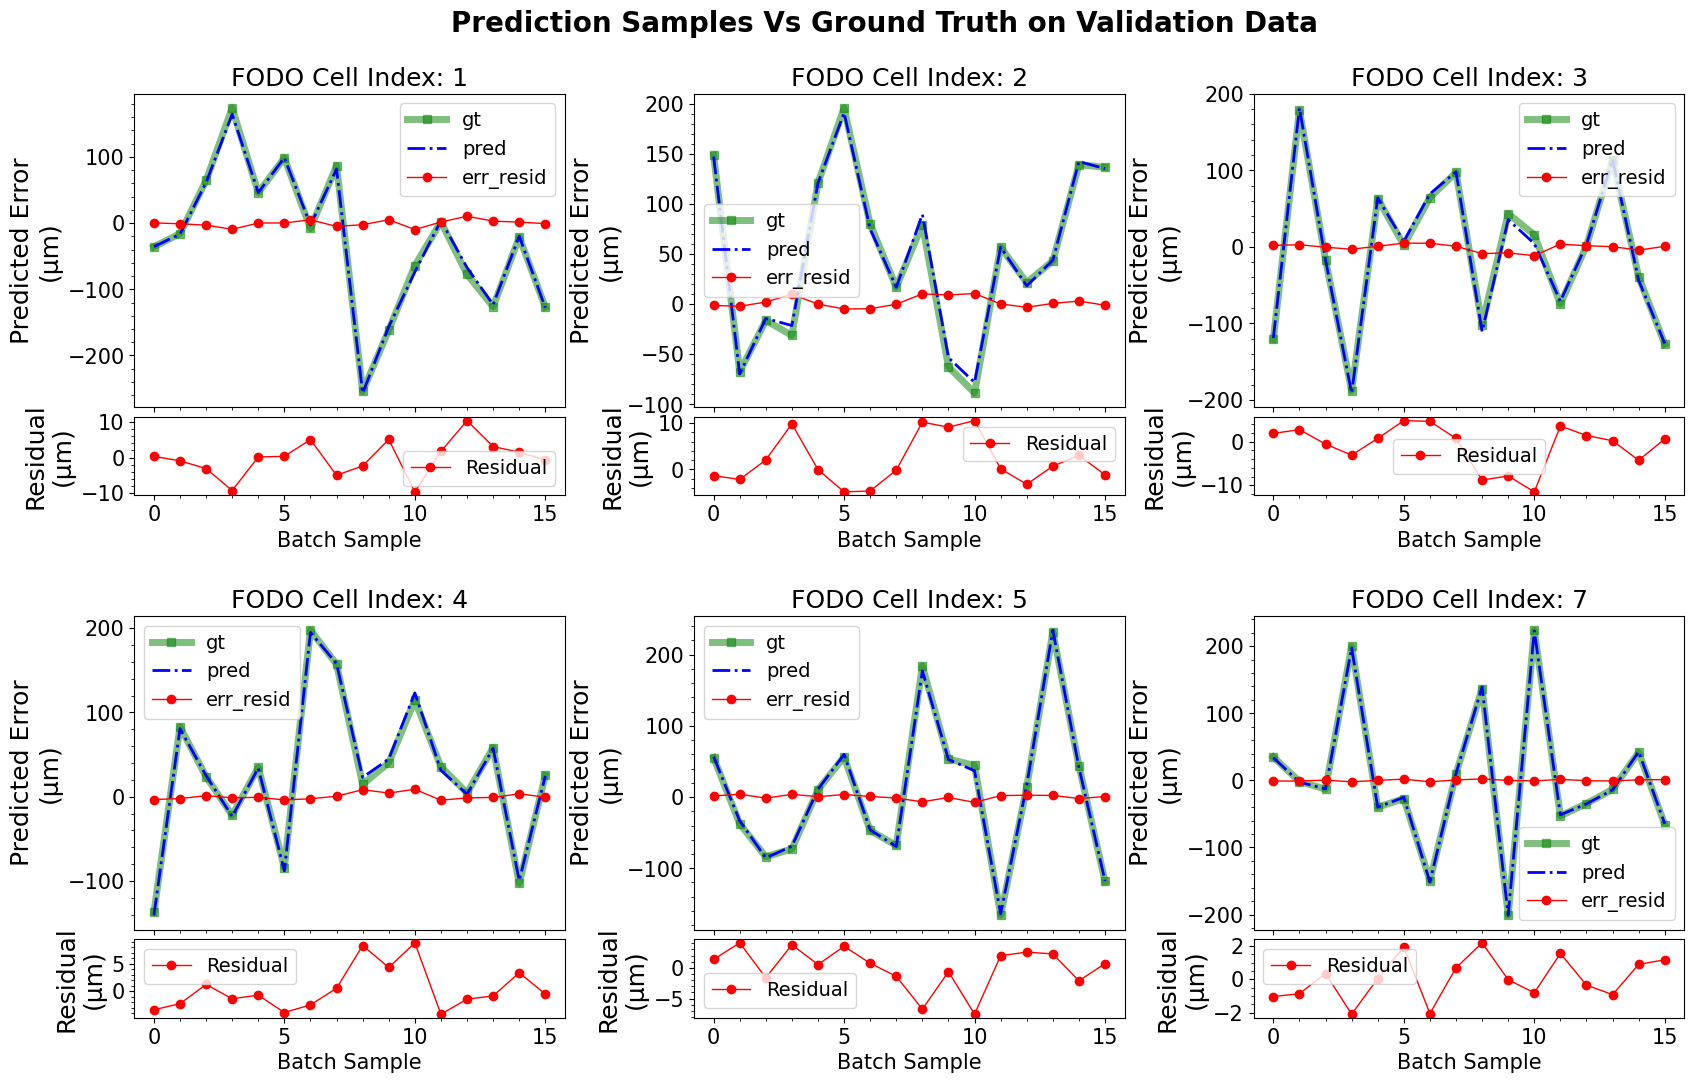

torch.Size([16, 101, 16])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


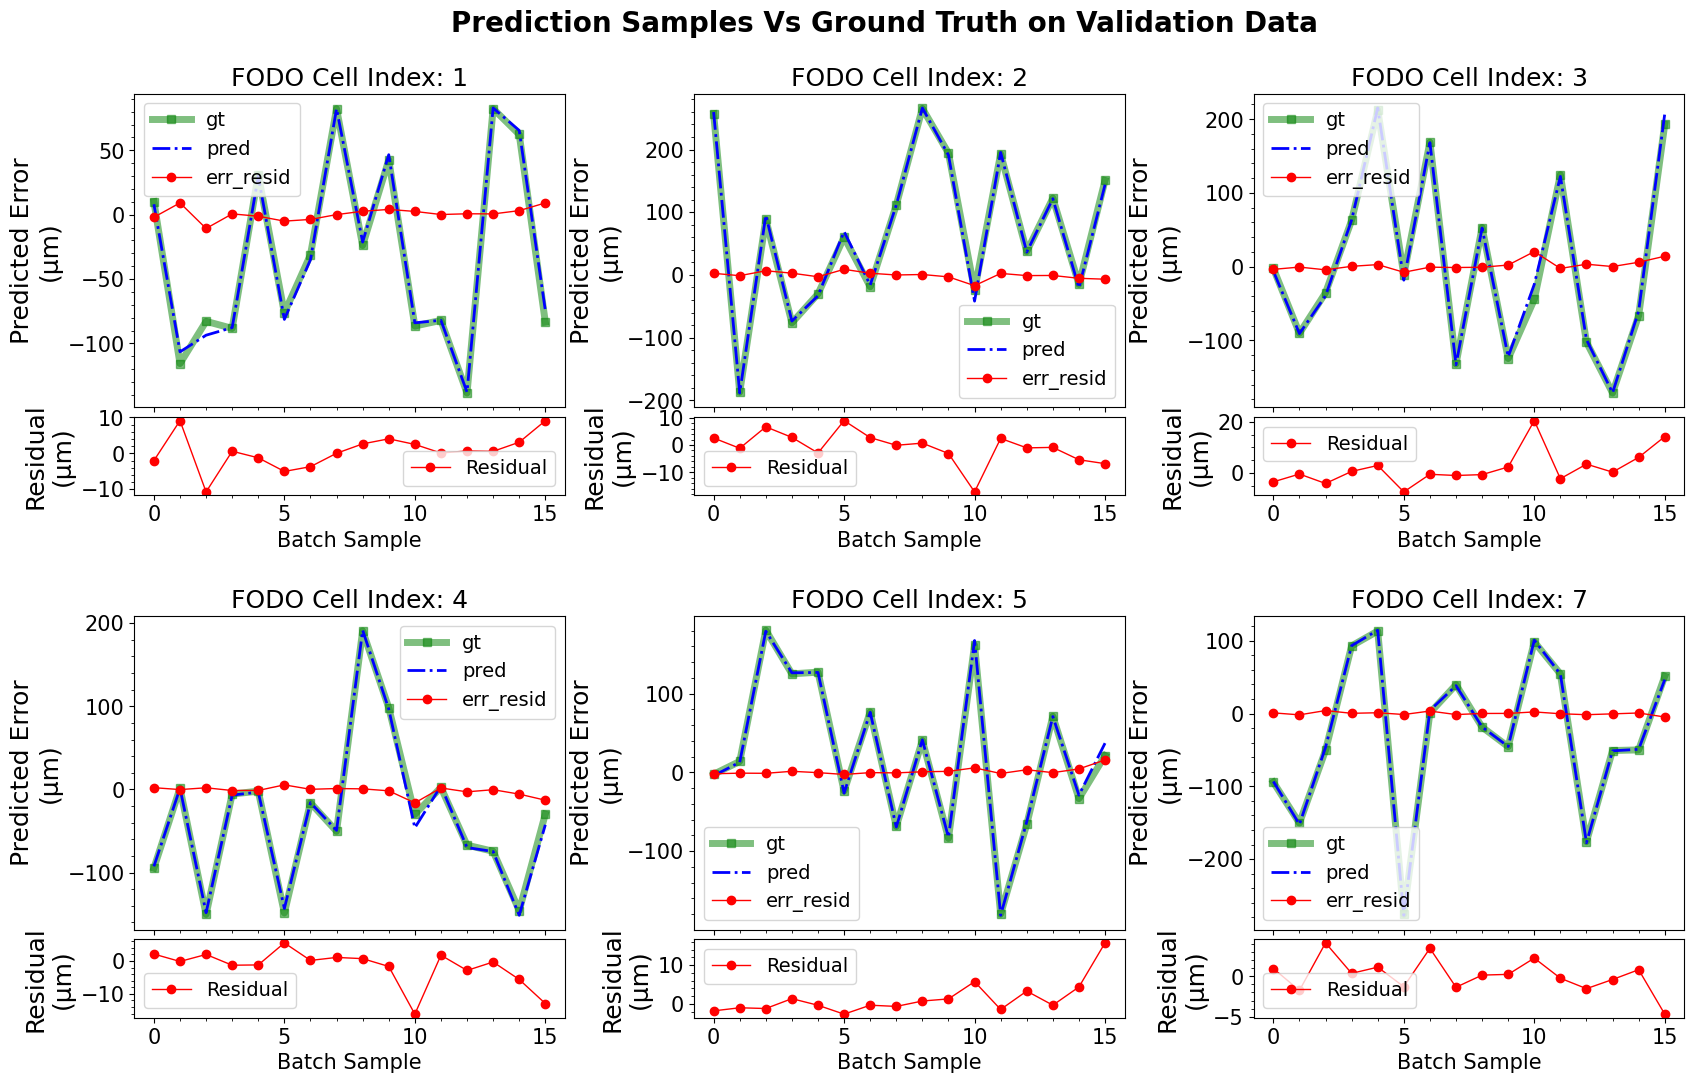

torch.Size([16, 101, 16])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


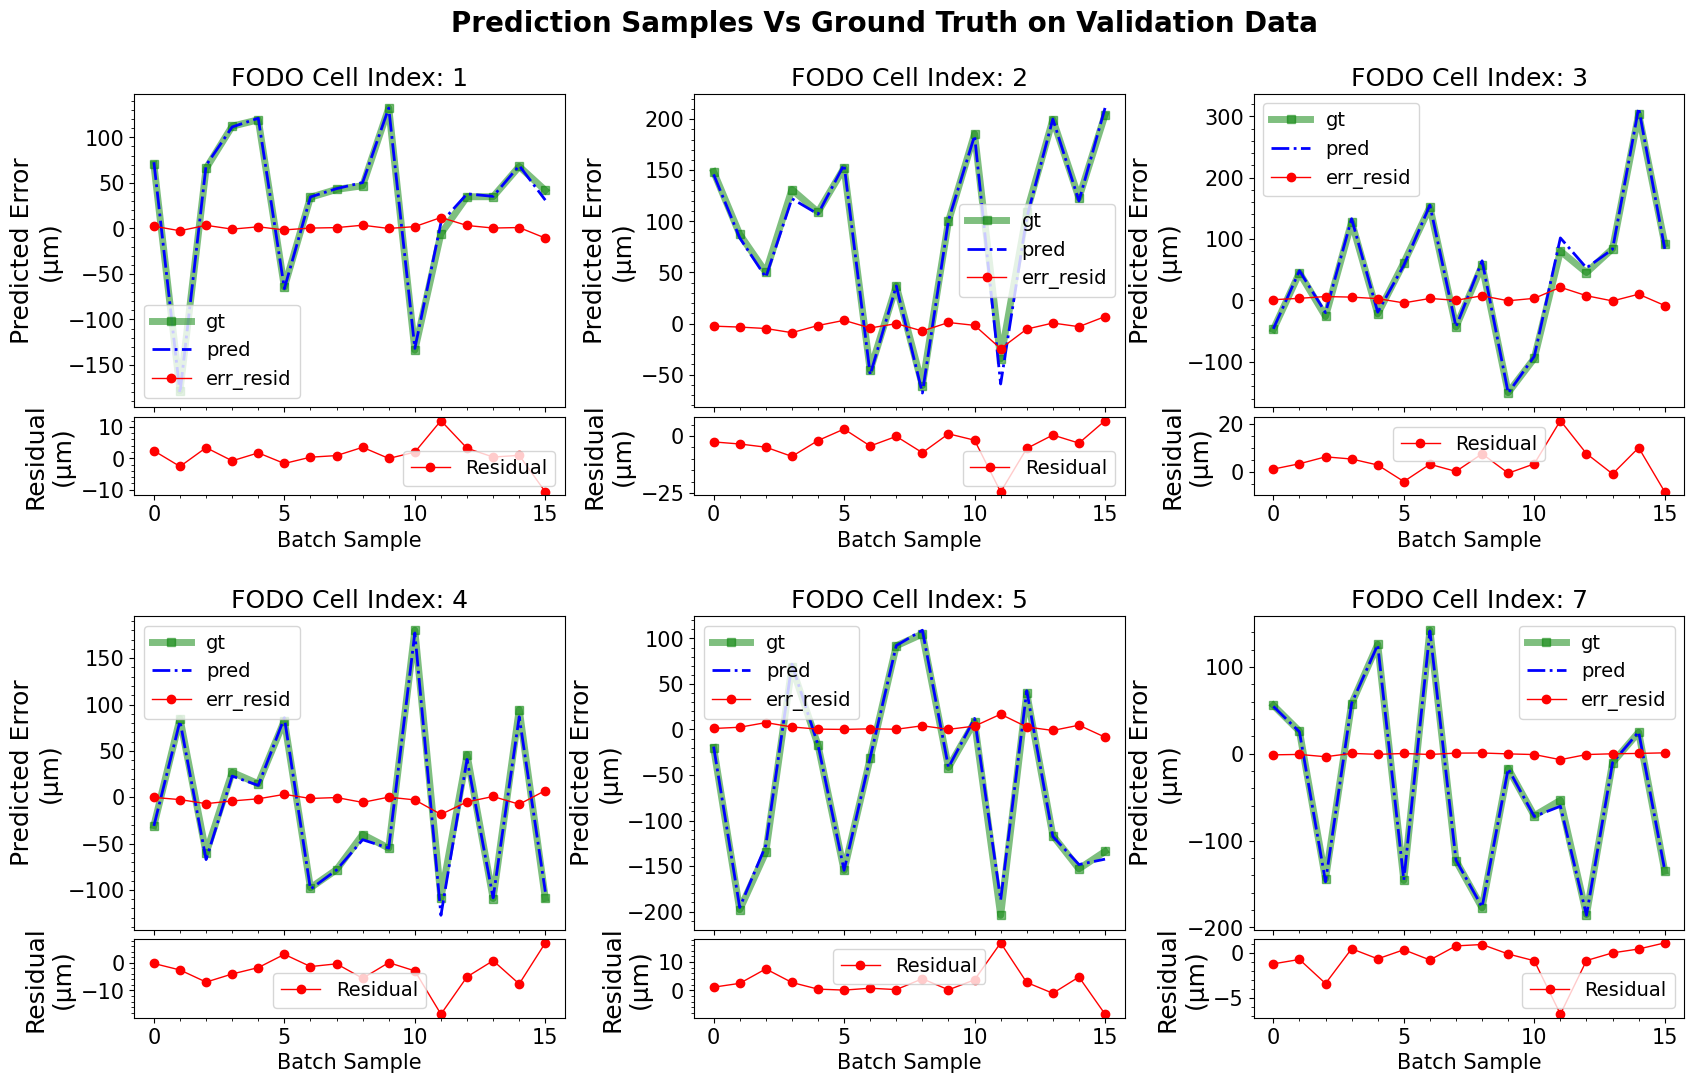

torch.Size([16, 101, 16])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


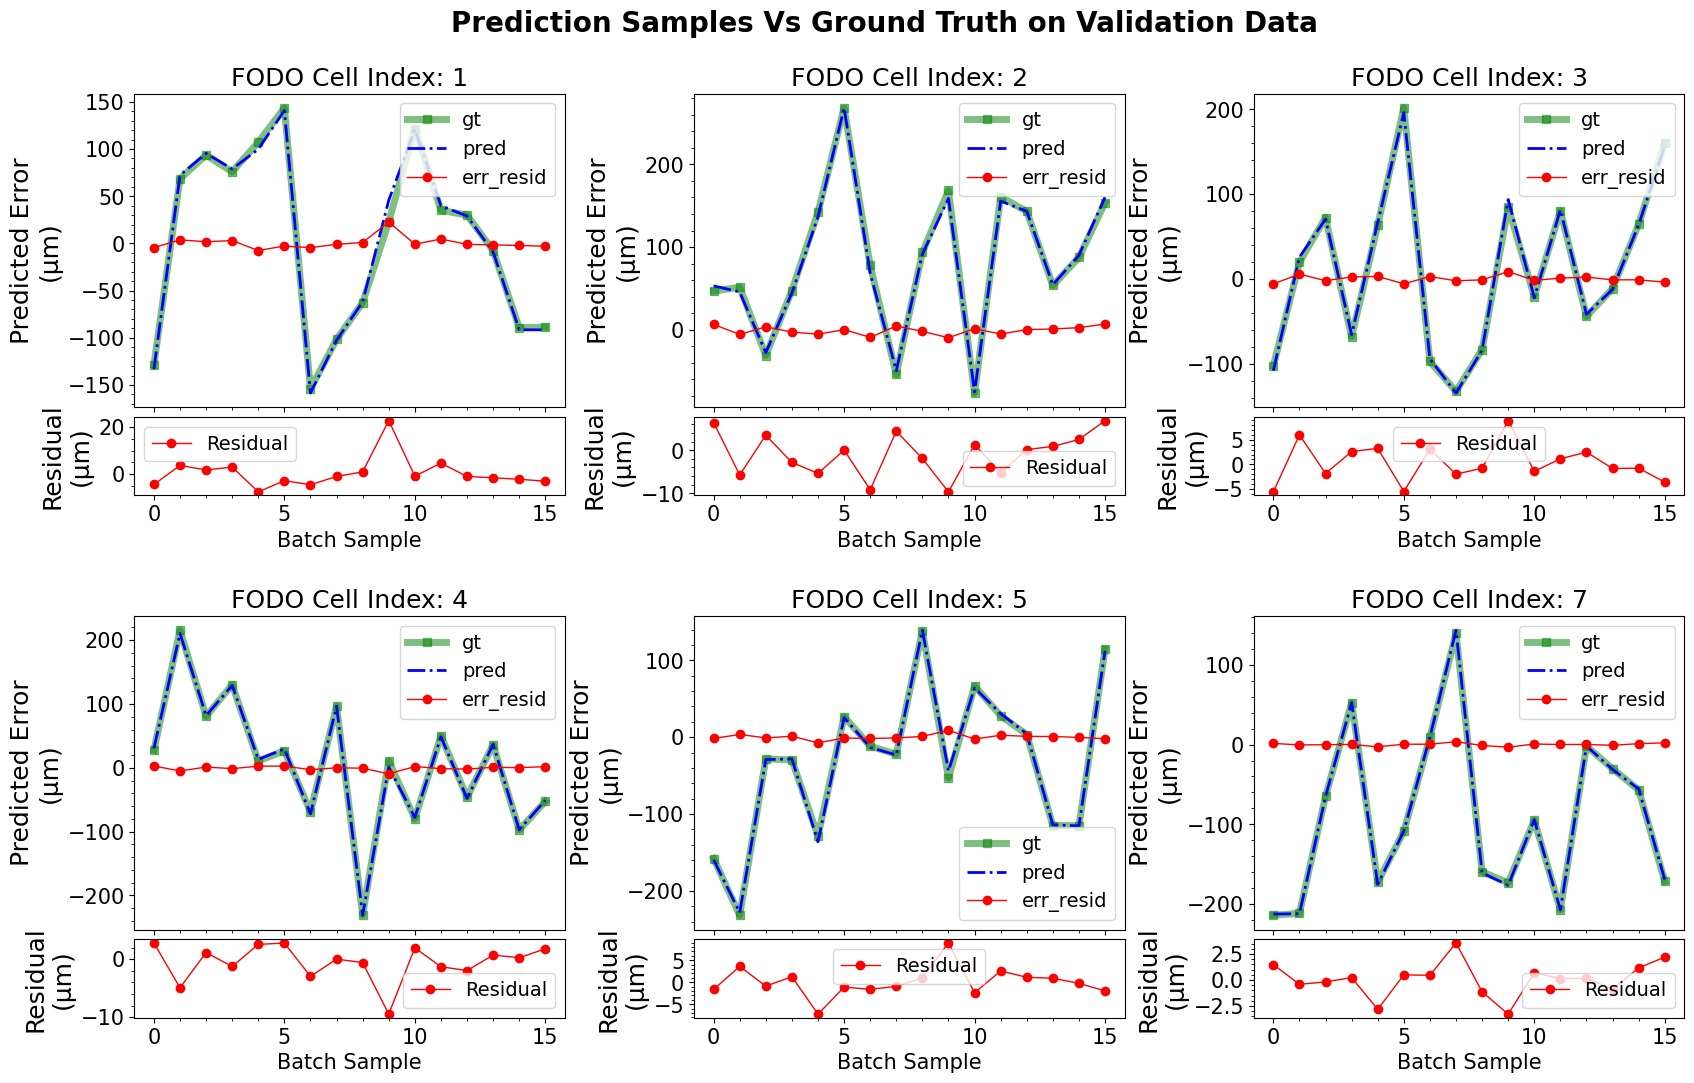

In [300]:




all_mean_min, all_mean_max = dataset_scalers['target_scaler'].data_min_, dataset_scalers['target_scaler'].data_max_
all_mean_scaler = all_mean_max - all_mean_min


# Extract FODO cell indices
fodo_cell_indices = [err['FODO_index'] for err in base_configurations['quad_errors']]
print(fodo_cell_indices)

# Batch parameters
batch_limit_s = 0
batch_limit_e = 32
nb_batches = 4
batch_counter = 0

# Number of columns for subplots
cols = 3
rows = math.ceil(len(fodo_cell_indices) / cols)  # Calculate the number of rows required

for batch_inputs, batch_targets in val_loader:  # train_loader

    if batch_counter == nb_batches:
        break

    batch_counter += 1

    print(batch_inputs.shape)
    with torch.no_grad():
        # Forward pass
        output = model(batch_inputs[batch_limit_s:batch_limit_e].cuda())

    output = output.cpu()

    # Scale the targets and outputs
    batch_targets_scaled = batch_targets * all_mean_scaler * 1e6
    output_scaled = output * all_mean_scaler * 1e6

    # Calculate residuals
    err_resid = output_scaled - batch_targets_scaled[batch_limit_s:batch_limit_e]

    # Create the main figure
    fig = plt.figure(figsize=(20, 6 * rows))  # Increased height for larger plots
    # Create a top-level GridSpec with reduced spacing
    main_gs = GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=0.3)

    # Supertitle
    fig.suptitle(
        "Prediction Samples Vs Ground Truth on Validation Data",
        fontsize=20,          # Adjust font size as needed
        y=0.95,                # Adjust y-position to prevent overlap
        fontweight='bold'      # Optional: Make the title bold
    )
    
    for idx, quad_idx_pred in enumerate(range(len(fodo_cell_indices))):
        # Determine the row and column for the current subplot
        row = idx // cols
        col = idx % cols

        # Access the specific GridSpec cell
        cell_gs = main_gs[row, col]
        # Create a nested GridSpec within the cell (2 rows: main and residual)
        nested_gs = cell_gs.subgridspec(2, 1, height_ratios=[4, 1], hspace=0.05)

        # Create the main plot axes
        main_ax = fig.add_subplot(nested_gs[0])
        # Create the residual plot axes
        resid_ax = fig.add_subplot(nested_gs[1], sharex=main_ax)

        # Plotting on the main axes
        main_ax.plot(
            batch_targets_scaled.cpu()[:, quad_idx_pred],
            '-gs',
            lw=5,  # Increased line width for better visibility
            alpha=0.5,
            label='Ground Truth'
        )
        main_ax.plot(
            output_scaled[:, quad_idx_pred].cpu(),
            '-.b',
            lw=2,
            label='Prediction'
        )
        main_ax.plot(
            err_resid.cpu()[:, quad_idx_pred],
            '-or',
            lw=1,
            label='Residual Error'
        )
        main_ax.legend(['gt', 'pred', 'err_resid'], fontsize=14)
        main_ax.set_title(
            f"FODO Cell Index: {fodo_cell_indices[quad_idx_pred]}",
            fontsize=18
        )
        main_ax.set_ylabel("Predicted Error\n(µm)", fontsize=18)
        main_ax.tick_params(axis='both', labelsize=15)  # Set font size for ticks
        main_ax.minorticks_on()

        # Plotting on the residual axes
        resid_ax.plot(
            err_resid.cpu()[:, quad_idx_pred],
            '-or',
            lw=1,
            label='Residual Error'
        )
        resid_ax.legend(['Residual'], fontsize=14)
        resid_ax.set_ylabel("Residual\n(µm)", fontsize=18)
        resid_ax.set_xlabel("Batch Sample", fontsize=15)
        resid_ax.tick_params(axis='both', labelsize=15)  # Set font size for ticks
        resid_ax.minorticks_on()

        # Optional: Adjust y-limits for residuals to focus on their scale
        # resid_min = err_resid.cpu()[:, quad_idx_pred].min()
        # resid_max = err_resid.cpu()[:, quad_idx_pred].max()
        # resid_ax.set_ylim(resid_min * 1.1, resid_max * 1.1)

    # Hide any unused subplots if the grid has more cells than FODO indices
    total_subplots = rows * cols
    if len(fodo_cell_indices) < total_subplots:
        for idx in range(len(fodo_cell_indices), total_subplots):
            row = idx // cols
            col = idx % cols
            cell_gs = main_gs[row, col]
            # Create an empty axes and hide it
            empty_ax = fig.add_subplot(cell_gs)
            empty_ax.axis('off')

    plt.tight_layout()
    plt.savefig(
        f"./figs/inference_val_batch_{batch_counter}.eps",
        bbox_inches='tight',
        format='eps'
    )
    plt.show()


In [267]:
# predicted_error_value = dataset_scalers['target_scaler'].inverse_transform([[output.cpu()[0][0]]])
# predicted_error_value

In [268]:
# dataset_scalers['target_scaler'].inverse_transform([[-1]])

In [269]:
# dataset_scalers['target_scaler'].inverse_transform([[1]])

In [270]:
-0.0001 #90928

-0.0001

In [271]:
MODEL_ARCH

'lstm'

### Save model checkpoint

In [302]:
if not load_checkpoint:
    MODEL_SAVE_PATH = f'checkpoints/mix_quad_error_correction_{MODEL_ARCH}.pth'
    
    # Save the model's state_dict
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print(f"Model saved to {MODEL_SAVE_PATH}")


Model saved to checkpoints/mix_quad_error_correction_lstm.pth


### # Evaluation function

In [273]:

def _run_evaluation(model, base_configurations, common_parameters, dataset_scalers, noise_level=0.0, plot=False, verbose=True):
    """
    Common evaluation function that runs the simulation, applies noise if specified,
    predicts errors using the model, applies corrections, and optionally plots the results.

    Parameters:
    - model: The trained model.
    - base_configurations: Base configurations for the simulation.
    - common_parameters: Common parameters for the simulation.
    - dataset_scalers: Dictionary containing 'input_scaler' and 'target_scaler'.
    - noise_level: The level of noise to add to BPM readings. If 0, no noise is added.
    - plot: Boolean flag to control plotting. True for evaluate_once(), False for benchmarking.
    - verbose: Boolean flag to control print statements.
    
    Returns:
    - actual_deltas: Dictionary of actual quadrupole error deltas.
    - predicted_deltas: Dictionary of predicted quadrupole error deltas.
    - residual_error: Mean absolute residual error after correction.
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1) Instantiate a new Simulation

    # 2) Define a vertical quadrupole error
    min_delta, max_delta = common_parameters['delta_range']
    
    eval_config = base_configurations[0].copy()

    # TODO(aribra): get errant fodo indices from config
    set_FODO_indices_with_error = [1, 2, 3, 4, 5, 7]
    
    quadrupole_errors_deltas = {}
    for qe_ix, qe in enumerate(eval_config['quad_errors']):
        if eval_config['quad_errors'][qe_ix]['FODO_index'] in set_FODO_indices_with_error:
            quadrupole_error_delta = np.random.normal(min_delta, max_delta)
            quadrupole_errors_deltas[qe_ix] = quadrupole_error_delta
            eval_config['quad_errors'][qe_ix]['delta'] = quadrupole_error_delta
            if verbose:
                print(qe_ix, qe)
        else:
            eval_config['quad_errors'][qe_ix]['delta'] = 0.0

    if verbose:
        print("evaluate_model()/ base_configurations: ", eval_config)

    # 4) Simulate without error (baseline) + after applying the error
    sim_runner = SimulationRunner(
        base_configurations=[eval_config],
        common_parameters=common_parameters
    )

    initial_states = None

    sim_runner.run_configurations(draw_plots=False, verbose=verbose, initial_states=initial_states)

    initial_states = sim_runner.initial_states

    simulator_no_error = sim_runner.simulators_no_error.get(f"{eval_config['config_name']} - No Error")
    simulator_with_error = sim_runner.simulators_with_error.get(f"{eval_config['config_name']} - With Error")

    # 5) The initial_states are the same in both simulations

    merged_config = {**common_parameters, **eval_config}

    if noise_level > 0:
        if verbose:
            print(f"Applying random noise to BPM readings in X and Y axis ±{noise_level}.")
        simulator_with_error.bpm_readings['x'] = simulator_with_error.bpm_readings['x'] + \
            np.random.uniform(-noise_level, noise_level, simulator_with_error.bpm_readings['x'].shape)
        simulator_with_error.bpm_readings['y'] = simulator_with_error.bpm_readings['y'] + \
            np.random.uniform(-noise_level, noise_level, simulator_with_error.bpm_readings['y'].shape)
    
    # Create SimulationDataset instance
    simulation_dataset = SimulationDataset(
        merged_config=merged_config,
        bpm_readings_no_error=simulator_no_error.bpm_readings,
        bpm_readings_with_error=simulator_with_error.bpm_readings,
        bpm_positions=simulator_no_error.bpm_positions,
        quadrupole_errors=simulator_with_error.quad_errors,
        quadrupole_tilt_errors=simulator_with_error.quadrupole_tilt_errors,
        dipole_tilt_errors=simulator_with_error.dipole_tilt_errors,
        lattice_reference=simulator_no_error.get_lattice_reference(),
        apply_avg=common_parameters.get('apply_avg', False)
    )

    # Generate data using the same parameters as during training
    start_rev = common_parameters.get('start_rev', 0)
    end_rev = common_parameters.get('end_rev', simulator_no_error.n_turns)
    fodo_cell_indices = common_parameters.get('fodo_cell_indices', list(range(simulator_no_error.n_FODO)))
    planes = common_parameters.get('planes', ['x', 'y'])

    if verbose:
        print(f"[Evaluation - Generate data params:]\n"
              f"\t start_rev={start_rev}\n"
              f"\t end_rev={end_rev}\n"
              f"\t fodo_cell_indices={fodo_cell_indices}\n"
              f"\t planes={planes}")
    

    (input_tensor, target_tensor,
     error_values_quad_misalign,
     error_values_quad_tilt,
     error_values_dipole_tilt) = simulation_dataset.generate_data(
        start_rev, end_rev, fodo_cell_indices, planes
    )

    # Reshape input data to match model input
    n_samples, n_turns, n_BPMs, n_planes = input_tensor.shape
    input_size = n_BPMs * n_planes
    input_data = input_tensor.reshape(n_samples, n_turns, input_size)

    # **Reshape input data back to (n_samples, n_turns, n_BPMs, n_planes)**
    input_data_reshaped = input_data.reshape(n_samples, n_turns, n_BPMs, n_planes)

    # **Reshape to (-1, n_planes) for scaling**
    input_data_flat = input_data_reshaped.reshape(-1, n_planes)  # Shape: (n_samples * n_turns * n_BPMs, n_planes)

    # **Use the input scaler to transform the input data**
    input_data_flat_scaled = dataset_scalers['input_scaler'].transform(input_data_flat)

    # **Reshape back to (n_samples, n_turns, n_BPMs, n_planes)**
    input_data_scaled = input_data_flat_scaled.reshape(n_samples, n_turns, n_BPMs, n_planes)

    # **Flatten to (n_samples, n_turns, input_size) for model input**
    input_data_scaled = input_data_scaled.reshape(n_samples, n_turns, input_size)

    # Convert to tensor
    input_tensor_model = torch.tensor(input_data_scaled, dtype=torch.float32).to(device)


    # Predict the error
    model.eval()
    with torch.no_grad():
        if verbose:
            print("input to model: ", input_tensor_model.shape)
        predicted_error = model(input_tensor_model)  # predicted_error shape: (n_samples, output_size)
        if verbose:
            print("predicted_errors = ", predicted_error)
        predicted_errors_scaled_values = predicted_error.cpu().numpy()

    # Inverse transform the prediction
    predicted_errors_values_transformed_back = dataset_scalers['target_scaler'].inverse_transform(predicted_errors_scaled_values)
    predicted_errors_values_transformed_back = predicted_errors_values_transformed_back.flatten()
    if verbose:
        print(f"predicted_errors_values_transformed_back = {predicted_errors_values_transformed_back}")
    
    actual_deltas = {}
    predicted_deltas = {}
    
    for pesv_ix, pesv in enumerate(predicted_errors_values_transformed_back):
        predicted_error_value = pesv
        predicted_deltas[pesv_ix] = predicted_error_value
        if pesv_ix not in quadrupole_errors_deltas:
            if verbose:
                print(f"WARNING - error prediction output with index={pesv_ix}, is not available.\n\tthis may indicate that you set custom error config rather than the trained network")
            continue
        actual_deltas[pesv_ix] = quadrupole_errors_deltas[pesv_ix]
        if verbose:
            print(f"\tActual quadrupole error delta: {quadrupole_errors_deltas[pesv_ix]:.7e}, {quadrupole_errors_deltas[pesv_ix] * 1e6}")
            print(f"\tPredicted quadrupole error delta: {predicted_error_value:.7e}, {predicted_error_value * 1e6}")
            print('---')

    # 7) Apply correction and re-run simulation
    # Correct the quadrupole error by subtracting the predicted error
    corrected_deltas = {}
    for pevtb_ix, pevtb in predicted_deltas.items():
        if pevtb_ix not in quadrupole_errors_deltas:
            if verbose:
                print(f"WARNING - error prediction output with index={pevtb_ix}, is not available.\n\tthis may indicate that you set custom error config rather than the trained network")
            # If error was not found, we assume it is 0
            corrected_deltas[pevtb_ix] = 0.0
            continue
        corrected_delta = quadrupole_errors_deltas[pevtb_ix] - pevtb
        corrected_deltas[pevtb_ix] = corrected_delta
        if verbose:
            print(f"\tCorrected_delta quadrupole error delta [0]: {corrected_delta:.7e}, {corrected_delta * 1e6}")

    eval_config_corrected = eval_config.copy()
    for cord_ix, cord in corrected_deltas.items():
        if cord_ix < len(eval_config_corrected['quad_errors']):
            eval_config_corrected['quad_errors'][cord_ix]['delta'] = cord
            if verbose:
                print(cord_ix, cord)

    runner_corrected = SimulationRunner(
        base_configurations=[eval_config_corrected],
        common_parameters=common_parameters
    )

    runner_corrected.run_configurations(draw_plots=False, verbose=False, initial_states=initial_states)
    simulator_corrected = runner_corrected.simulators_with_error.get(f"{eval_config_corrected['config_name']} - With Error")

    # 8) Compare y positions after applying the correction with the original simulation without errors
    # Use the same start_rev and end_rev


    if plot:
        # Extract BPM readings for comparison
        bpm_readings_no_error = simulator_no_error.bpm_readings['y'][:, start_rev:end_rev, :][:, :, fodo_cell_indices].mean(axis=0)  # Shape: [n_turns, n_BPMs]
        bpm_readings_with_error = simulator_with_error.bpm_readings['y'][:, start_rev:end_rev, :][:, :, fodo_cell_indices].mean(axis=0)  # Shape: [n_turns, n_BPMs]
        bpm_readings_corrected = simulator_corrected.bpm_readings['y'][:, start_rev:end_rev, :][:, :, fodo_cell_indices].mean(axis=0)  # Shape: [n_turns, n_BPMs]
    
        bpm_indx = 3
        rev_numbers = np.arange(end_rev - 100, end_rev)
        if verbose:
            print(f"rev_numbers = {rev_numbers}")
            print(f"bpm_readings_no_error = {bpm_readings_no_error.shape}")
        # Plot the comparison
        plt.figure(figsize=(12, 6))
        plt.plot(rev_numbers, bpm_readings_no_error[-100:, bpm_indx], '-o', label='No Error', color='blue')
        plt.plot(rev_numbers, bpm_readings_with_error[-100:, bpm_indx], '-x', label='With Error', color='red')
        plt.plot(rev_numbers, bpm_readings_corrected[-100:, bpm_indx], '-v', label='After Correction', color='green')
        plt.xlabel('Turn')
        plt.ylabel(f'Average y position at BPM {bpm_indx}')
        plt.title('Comparison of y positions after correction')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Compute and print the residual error after correction
        residual_error = np.abs(bpm_readings_no_error - bpm_readings_corrected).mean()
        print(f"Residual error after correction (mean absolute difference): {residual_error:.6e}, {residual_error * 1e6}")
        
        # Additional plots
        simulator_no_error.plot_comparison(simulator_with_error, cell_idx=bpm_indx, viz_start_idx=end_rev - 100, 
                                             viz_end_idx=end_rev, save_label="WOEvsWE", window_size=50, plot_all=True, extra_title="Before correction")
    
        simulator_no_error.plot_comparison(simulator_corrected, cell_idx=bpm_indx, 
                                            viz_start_idx=end_rev - 100, viz_end_idx=end_rev, save_label="WOEvsC", window_size=50, plot_all=True, extra_title="After correction")
    
        simulator_no_error.plot_bpm_heatmaps(cell_idx=bpm_indx, simulation_label='No Error')
        simulator_with_error.plot_bpm_heatmaps(cell_idx=bpm_indx, simulation_label='With Error')
        simulator_corrected.plot_bpm_heatmaps(cell_idx=bpm_indx, simulation_label='Corrected')
    
        simulator_corrected.plot_bpm_comparison_last_images(simulator_corrected, simulator_with_error, cell_idx=bpm_indx, save_label="WEvsC", particles='all')
        simulator_corrected.plot_bpm_comparison_last_images(simulator_corrected, simulator_no_error, cell_idx=bpm_indx, save_label="WOEvsC", particles='all')

    return actual_deltas, predicted_deltas

def evaluate_once(model, base_configurations, common_parameters, dataset_scalers):
    """
    Performs a single evaluation without adding noise.
    Maintains all original prints and plots.

    Parameters:
    - model: The trained model.
    - base_configurations: Base configurations for the simulation.
    - common_parameters: Common parameters for the simulation.
    - dataset_scalers: Dictionary containing 'input_scaler' and 'target_scaler'.
    
    Returns:
    - None
    """
    _run_evaluation(
        model=model,
        base_configurations=base_configurations,
        common_parameters=common_parameters,
        dataset_scalers=dataset_scalers,
        noise_level=0.0,
        plot=True,
        verbose=True
    )

def benchmark_evaluation(model, base_configurations, common_parameters, dataset_scalers, noise_range=100e-6, bins=51, runs=20):
    """
    Automates running the evaluation with varying levels of BPM reading noise.
    Collects statistics and plots model prediction accuracy against noise levels.

    Parameters:
    - model: The trained model.
    - base_configurations: Base configurations for the simulation.
    - common_parameters: Common parameters for the simulation.
    - dataset_scalers: Dictionary containing 'input_scaler' and 'target_scaler'.
    - noise_range: Maximum noise level to apply.
    - bins: Number of bins for noise levels.
    - runs: Number of evaluations to run per noise level.
    
    Returns:
    - stats: Dictionary containing statistics for each noise level and FODO index.
    """
    noise_pallette = np.linspace(0, noise_range, bins)  # Convert to meters if needed

    # Initialize a dictionary to store statistics
    stats = defaultdict(lambda: defaultdict(list))  # stats[noise_level][fodo_index] = list of errors

    for noise_level in noise_pallette:
        if model.training:
            model.eval()  # Ensure model is in evaluation mode
        for run in range(runs):
            actual_deltas, predicted_deltas = _run_evaluation(
                model=model,
                base_configurations=base_configurations,
                common_parameters=common_parameters,
                dataset_scalers=dataset_scalers,
                noise_level=noise_level,
                plot=False,
                verbose=False
            )
            for fodo_ix in actual_deltas:
                error = np.abs(actual_deltas[fodo_ix] - predicted_deltas[fodo_ix])
                stats[noise_level][fodo_ix].append(error)
        print(f"Completed benchmarking for noise_level={noise_level} meters.")

    return stats


def plot_benchmark_stats(stats, benchmark_info):
    noise_range = benchmark_info["noise_range"]
    bins = benchmark_info["bins"]
    noise_pallette = benchmark_info["noise_pallette"]
    runs_per_noise = benchmark_info["runs_per_noise"]
    fodo_mapping = benchmark_info["fodo_mapping"]
    cancel_tilt_error = benchmark_info["cancel_tilt_error"]
    cancel_misalign_error = benchmark_info["cancel_misalign_error"]

    mean_errors = defaultdict(dict)
    std_errors = defaultdict(dict)
    
    for noise_level in stats:
        for fodo_ix in stats[noise_level]:
            mean_errors[noise_level][fodo_ix] = np.mean(stats[noise_level][fodo_ix])
            std_errors[noise_level][fodo_ix] = np.std(stats[noise_level][fodo_ix])

    # Plotting accuracy vs noise_level for each FODO index
    plt.figure(figsize=(12, 8))
    fodo_indices = set()
    for noise_level in stats:
        fodo_indices.update(stats[noise_level].keys())
    fodo_indices = sorted(list(fodo_indices))

    local_plt_markers = get_local_plt_markers(len(fodo_indices))
    for fodo_ix in fodo_indices:
        means = [mean_errors[noise][fodo_ix] for noise in noise_pallette]
        means = np.array(means)
        marker = local_plt_markers[fodo_ix]
        plt.plot(noise_pallette * 1e6, means * 1e6, '-' + marker, label=f'FODO-QE-ix {fodo_mapping[fodo_ix]}')

    
    plt.xlabel('Noise Level (µm)', fontsize=18)
    plt.ylabel(f'Mean Absolute Error (µm)\nAveraging over {runs_per_noise} simulation runs\n', fontsize=18)
    plt.title(f'Model Prediction Accuracy vs BPM Noise Level (noise_range: {noise_range}, bins: {bins})\nMisAlign error: {not cancel_misalign_error}\nTilt errors: {not cancel_tilt_error}', fontsize=18)
    plt.legend(fontsize=14)
    plt.grid(True)
    # plt.minorticks_on()
    plt.xticks(noise_pallette * 1e6, fontsize=14, rotation=-45)
    plt.yticks(fontsize=14)
    plt.rc('font', size=14)
    plt.savefig(f"./figs/plot_accuracy_benchmark_with_MisAlign_and_Tilt_error_in_data_1.eps", bbox_inches = 'tight', format='eps')
    plt.show()
    

def split_merged_config(merged_config):
    # Keys that belong to base_configurations
    base_keys = {
        'config_name',
        'design_radius',
        'n_FODO',
        'f',
        'L_quad',
        'L_straight',
        'quad_errors',
        'quad_tilt_errors',
        'dipole_tilt_errors',
        'total_dipole_bending_angle'
    }

    # Extract base configuration parameters
    base_config = {k: v for k, v in merged_config.items() if k in base_keys}

    # Wrap the base_config in a list as
    base_configurations = [base_config]

    # Extract common parameters by excluding base_keys
    common_parameters = {k: v for k, v in merged_config.items() if k not in base_keys}

    return base_configurations, common_parameters

def convert_defaultdict_to_dict(d):
    """
    Recursively converts a defaultdict to a regular dict.

    Parameters:
    - d: The defaultdict or dict to convert.

    Returns:
    - A standard dict with all nested defaultdicts converted.
    """
    if isinstance(d, defaultdict):
        d = {k: convert_defaultdict_to_dict(v) for k, v in d.items()}
    elif isinstance(d, dict):
        d = {k: convert_defaultdict_to_dict(v) for k, v in d.items()}
    elif isinstance(d, list):
        d = [convert_defaultdict_to_dict(item) for item in d]
    return d


In [274]:
# fodo_mapping = {}
# for qe_ix, qe in enumerate(merged_config['quad_errors']):
#     fodo_mapping[qe_ix] = qe['FODO_index']

# fodo_mapping

### RUN Evaluation

0 {'FODO_index': 1, 'quad_type': 'defocusing', 'delta': 3.4657732930698585e-05, 'plane': 'vertical'}
1 {'FODO_index': 2, 'quad_type': 'defocusing', 'delta': 4.307671302124774e-05, 'plane': 'vertical'}
2 {'FODO_index': 3, 'quad_type': 'defocusing', 'delta': 2.7926224061238103e-05, 'plane': 'vertical'}
3 {'FODO_index': 4, 'quad_type': 'defocusing', 'delta': 1.0897462827474717e-05, 'plane': 'vertical'}
4 {'FODO_index': 5, 'quad_type': 'defocusing', 'delta': -2.884788074861482e-05, 'plane': 'vertical'}
5 {'FODO_index': 7, 'quad_type': 'defocusing', 'delta': 2.457265183613649e-05, 'plane': 'vertical'}
evaluate_model()/ base_configurations:  {'config_name': 'Configuration 1', 'design_radius': 20.0, 'n_FODO': 8, 'f': 3.336008739076155, 'L_quad': 1, 'L_straight': 3.9269908169872423, 'quad_errors': [{'FODO_index': 1, 'quad_type': 'defocusing', 'delta': 3.4657732930698585e-05, 'plane': 'vertical'}, {'FODO_index': 2, 'quad_type': 'defocusing', 'delta': 4.307671302124774e-05, 'plane': 'vertical'},

/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:1128: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X_hor = np.random.multivariate_normal(mean=[0,0], cov=Sigma_x, size=num_particles)
/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:1130: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X_ver = np.random.multivariate_normal(mean=[0,0], cov=Sigma_y, size=num_particles)
/home/aribra/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))



Running Configuration 1 - With Error:
  n_FODO=8, design_radius=20.0m, f=3.336008739076155m, L_quad=1m, L_straight=3.9269908169872423m
['Drift Before Dipole #0', 'Dipole #0', 'Drift After Dipole #0', 'Defocusing Quad', 'Drift Before Dipole #1', 'Dipole #1', 'Drift After Dipole #1', 'Focusing Quad']
build_lattice() completed. Total elements per rev = 64
0.28129690495610365 0.2812969049561037
['Drift Before Dipole #0', 'Dipole #0', 'Drift After Dipole #0', 'Defocusing Quad', 'Drift Before Dipole #1', 'Dipole #1', 'Drift After Dipole #1', 'Focusing Quad']
Inserted DipoleTiltError @ cell=0, dipole=0, angle=0.015107791667066717
Inserted QuadTiltError @ cell=1, type=defocusing, angle=-0.062003116423635665
Applied old Quad misalignment at cell=1, quad=defocusing, plane=vertical, delta=3.4657732930698585e-05, theta_kick=-1.0388981457013926e-05
Inserted DipoleTiltError @ cell=1, dipole=1, angle=-0.05651412879684738
Inserted QuadTiltError @ cell=2, type=defocusing, angle=-0.2418112055472561
App

/home/aribra/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[Evaluation - Generate data params:]
	 start_rev=1700
	 end_rev=2000
	 fodo_cell_indices=[0, 1, 2, 3, 4, 5, 6, 7]
	 planes=['x', 'y']
{'n_field_index': 0.4472135954999579, 'p': 5.344286e-19, 'G': 1.0, 'q': 1.602e-19, 'n_turns': 2000, 'num_particles': 10, 'window_size': 10, 'use_thin_lens': True, 'x0_mean_std': (0.0, 0.05), 'xp0_mean_std': (0.0, 0.0), 'y0_mean_std': (0.0, 0.05), 'yp0_mean_std': (0.0, 0.0), 'particles_sampling_method': 'from_twiss_params', 'sampling_circle_radius': 0.01, 'mag_field_range': [0.1, 2.0], 'dipole_length_range': [0.2, 14.0], 'horizontal_tune_range': [0.1, 0.8], 'vertical_tune_range': [0.1, 0.8], 'total_dipole_bending_angle_range': (4.71238898038469, 6.283185307179586), 'use_gpu': True, 'verbose': True, 'target_data': 'quad_misalign_deltas', 'reject_multiple_error_types': False, 'start_rev': 1700, 'end_rev': 2000, 'apply_avg': True, 'fodo_cell_indices': [0, 1, 2, 3, 4, 5, 6, 7], 'planes': ['x', 'y'], 'random_criterion': 'normal', 'delta_range': (0, 5e-05), 'qu

/home/aribra/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


['Drift Before Dipole #0', 'Dipole #0', 'Drift After Dipole #0', 'Defocusing Quad', 'Drift Before Dipole #1', 'Dipole #1', 'Drift After Dipole #1', 'Focusing Quad']
build_lattice() completed. Total elements per rev = 64
0.28129690495610365 0.2812969049561037
['Drift Before Dipole #0', 'Dipole #0', 'Drift After Dipole #0', 'Defocusing Quad', 'Drift Before Dipole #1', 'Dipole #1', 'Drift After Dipole #1', 'Focusing Quad']
Inserted DipoleTiltError @ cell=0, dipole=0, angle=0.015107791667066717
Inserted QuadTiltError @ cell=1, type=defocusing, angle=-0.062003116423635665
Applied old Quad misalignment at cell=1, quad=defocusing, plane=vertical, delta=6.158992161165594e-07, theta_kick=-1.8462158354151107e-07
Inserted DipoleTiltError @ cell=1, dipole=1, angle=-0.05651412879684738
Inserted QuadTiltError @ cell=2, type=defocusing, angle=-0.2418112055472561
Applied old Quad misalignment at cell=2, quad=defocusing, plane=vertical, delta=-3.19555797138335e-06, theta_kick=9.57898561221485e-07
Appli

/home/aribra/.local/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


rev_numbers = [1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913
 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927
 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941
 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955
 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999]
bpm_readings_no_error = (300, 8)


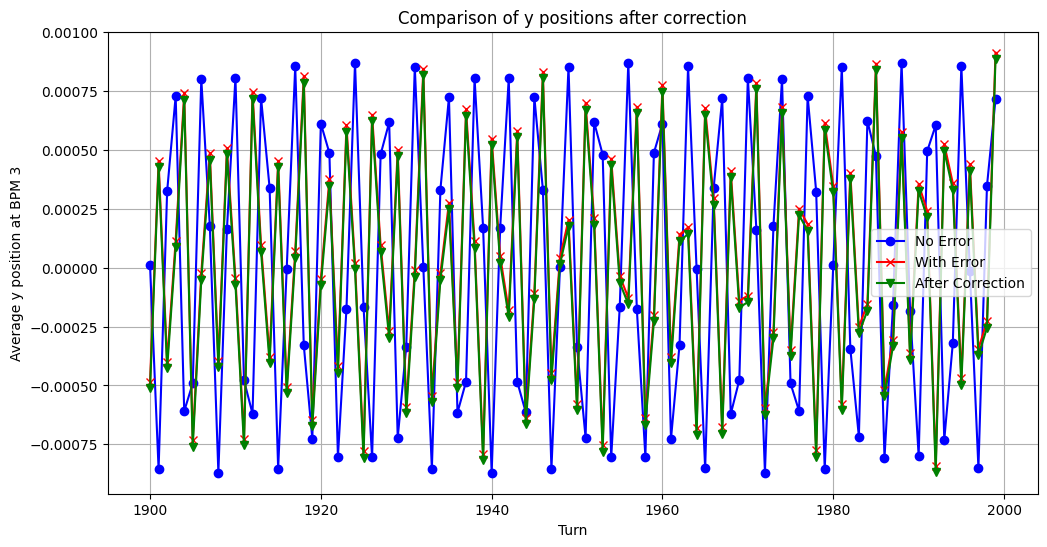

Residual error after correction (mean absolute difference): 6.559372e-04, 655.9371692768215
plot_comparison() - BPM 0/
	 CoM No error: X = -5.646069241528986e-08, Y = 1.3445971394973632e-07
	 CoM With Error: X = -8.796805086798879e-06, Y = -1.855637064472354e-06
----
	 ΔX = -0.0000087 m, -8.74 micron
	 ΔY = -0.0000020 m, -1.99 micron
	 beam epsilon X = 0.0020949 m, 2094.87 micron
	 beam epsilon Y = 0.0014379 m, 1437.87 micron
----
plot_comparison() - BPM 1/
	 CoM No error: X = 1.5147139461417834e-07, Y = 3.9276028378672944e-07
	 CoM With Error: X = 1.0491694401403434e-06, Y = -2.570905619490489e-05
----
	 ΔX = 0.0000009 m, 0.90 micron
	 ΔY = -0.0000261 m, -26.10 micron
	 beam epsilon X = 0.0020949 m, 2094.87 micron
	 beam epsilon Y = 0.0014379 m, 1437.87 micron
----
plot_comparison() - BPM 2/
	 CoM No error: X = 3.1240895843061636e-07, Y = 5.292056193691904e-07
	 CoM With Error: X = 1.4607630022564462e-05, Y = -1.2579292164820014e-05
----
	 ΔX = 0.0000143 m, 14.30 micron
	 ΔY = -0.0000

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


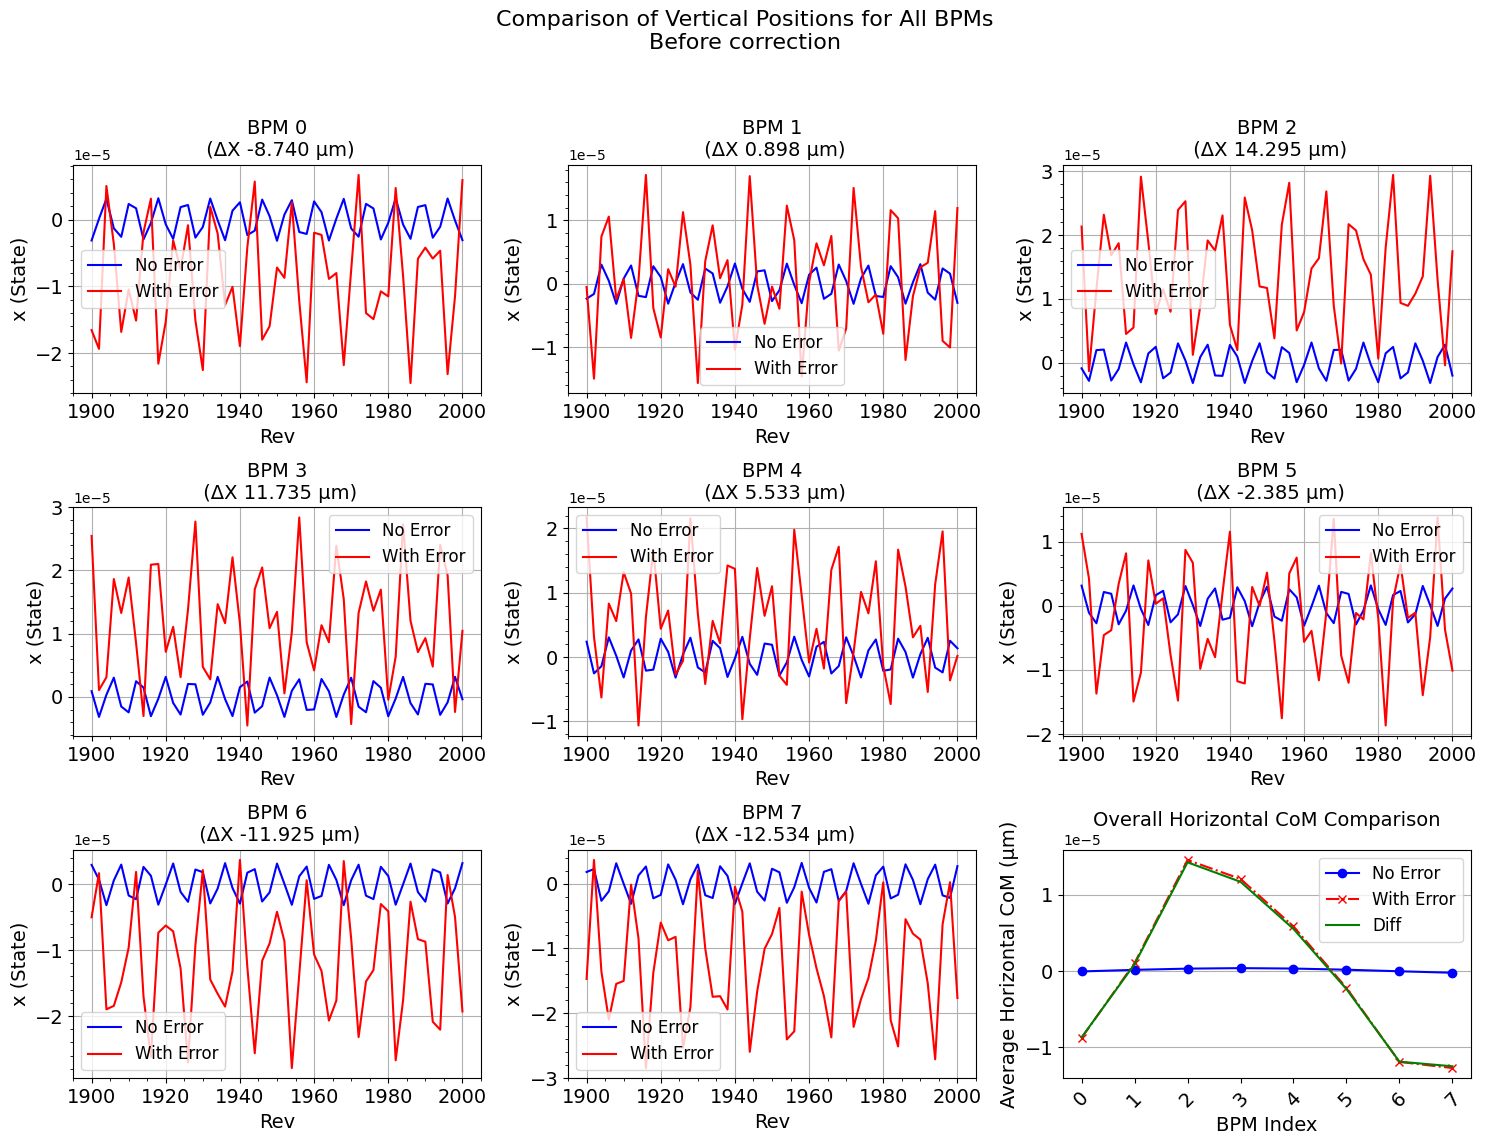

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


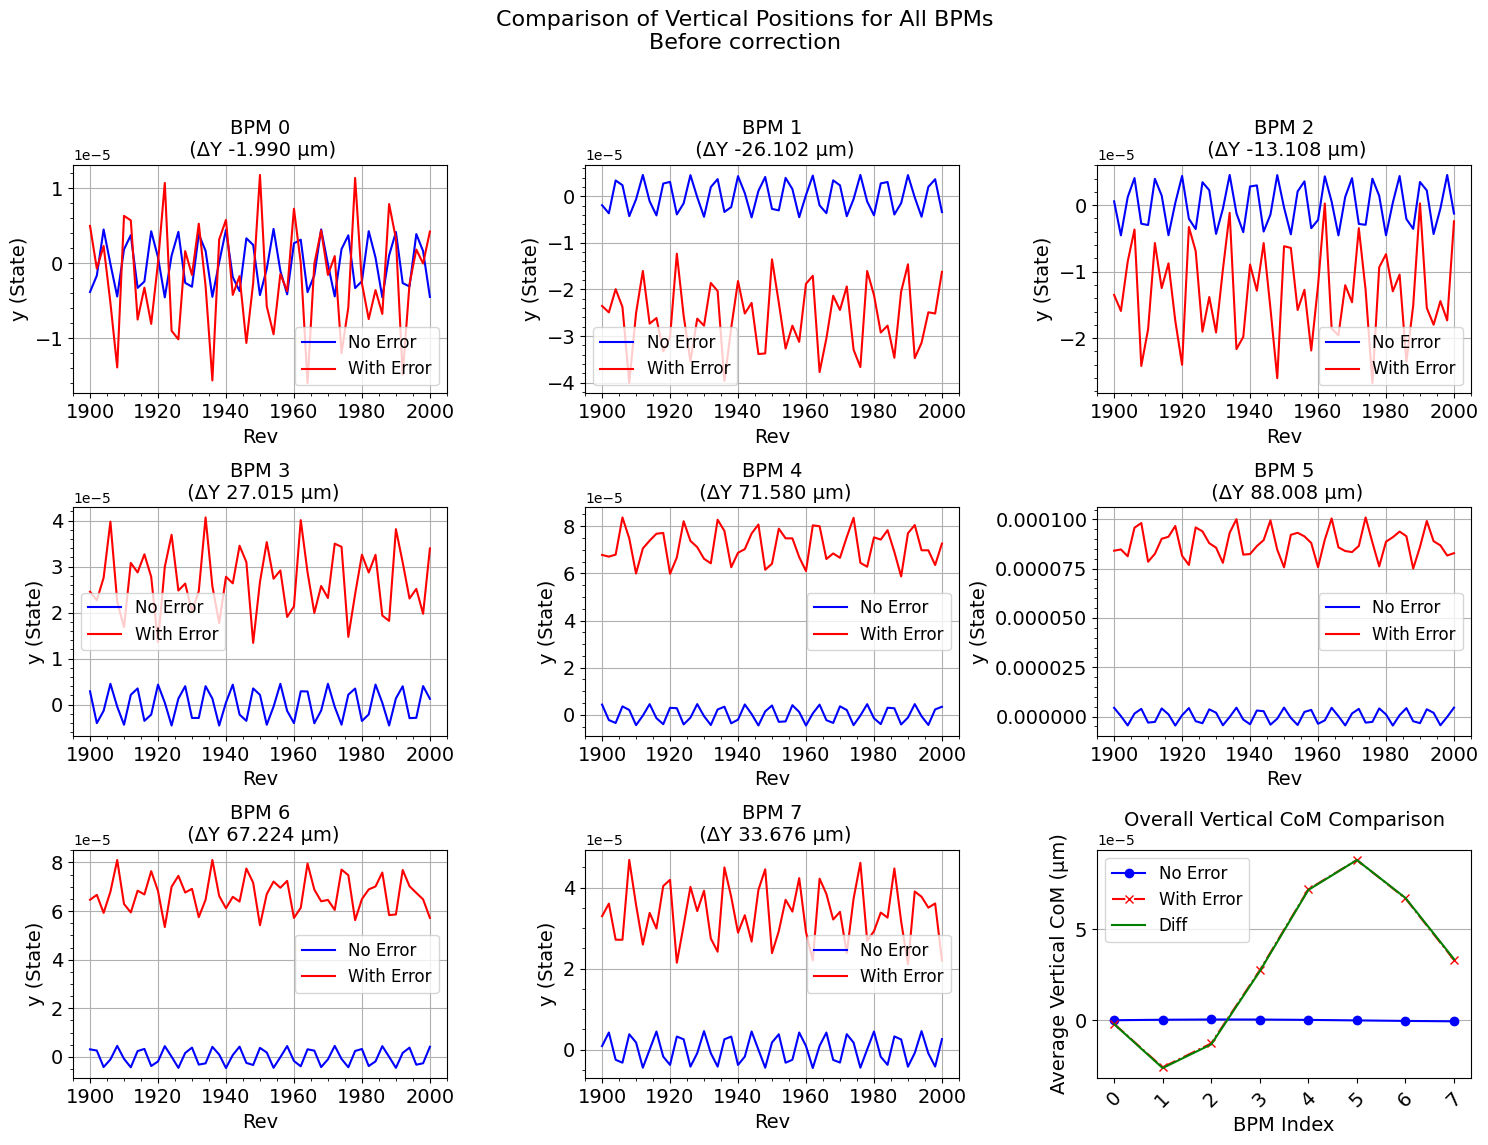

plot_comparison() - BPM 0/
	 CoM No error: X = -5.646069241528986e-08, Y = 1.3445971394973632e-07
	 CoM With Error: X = 4.75849196335958e-07, Y = 4.2838441526990737e-07
----
	 ΔX = 0.0000005 m, 0.53 micron
	 ΔY = 0.0000003 m, 0.29 micron
	 beam epsilon X = 0.0020949 m, 2094.87 micron
	 beam epsilon Y = 0.0014379 m, 1437.87 micron
----
plot_comparison() - BPM 1/
	 CoM No error: X = 1.5147139461417834e-07, Y = 3.9276028378672944e-07
	 CoM With Error: X = 3.58171992011071e-07, Y = 1.2318807409342373e-06
----
	 ΔX = 0.0000002 m, 0.21 micron
	 ΔY = 0.0000008 m, 0.84 micron
	 beam epsilon X = 0.0020949 m, 2094.87 micron
	 beam epsilon Y = 0.0014379 m, 1437.87 micron
----
plot_comparison() - BPM 2/
	 CoM No error: X = 3.1240895843061636e-07, Y = 5.292056193691904e-07
	 CoM With Error: X = -2.069213443945002e-07, Y = 7.846238250034975e-07
----
	 ΔX = -0.0000005 m, -0.52 micron
	 ΔY = 0.0000003 m, 0.26 micron
	 beam epsilon X = 0.0020949 m, 2094.87 micron
	 beam epsilon Y = 0.0014379 m, 1437.87

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


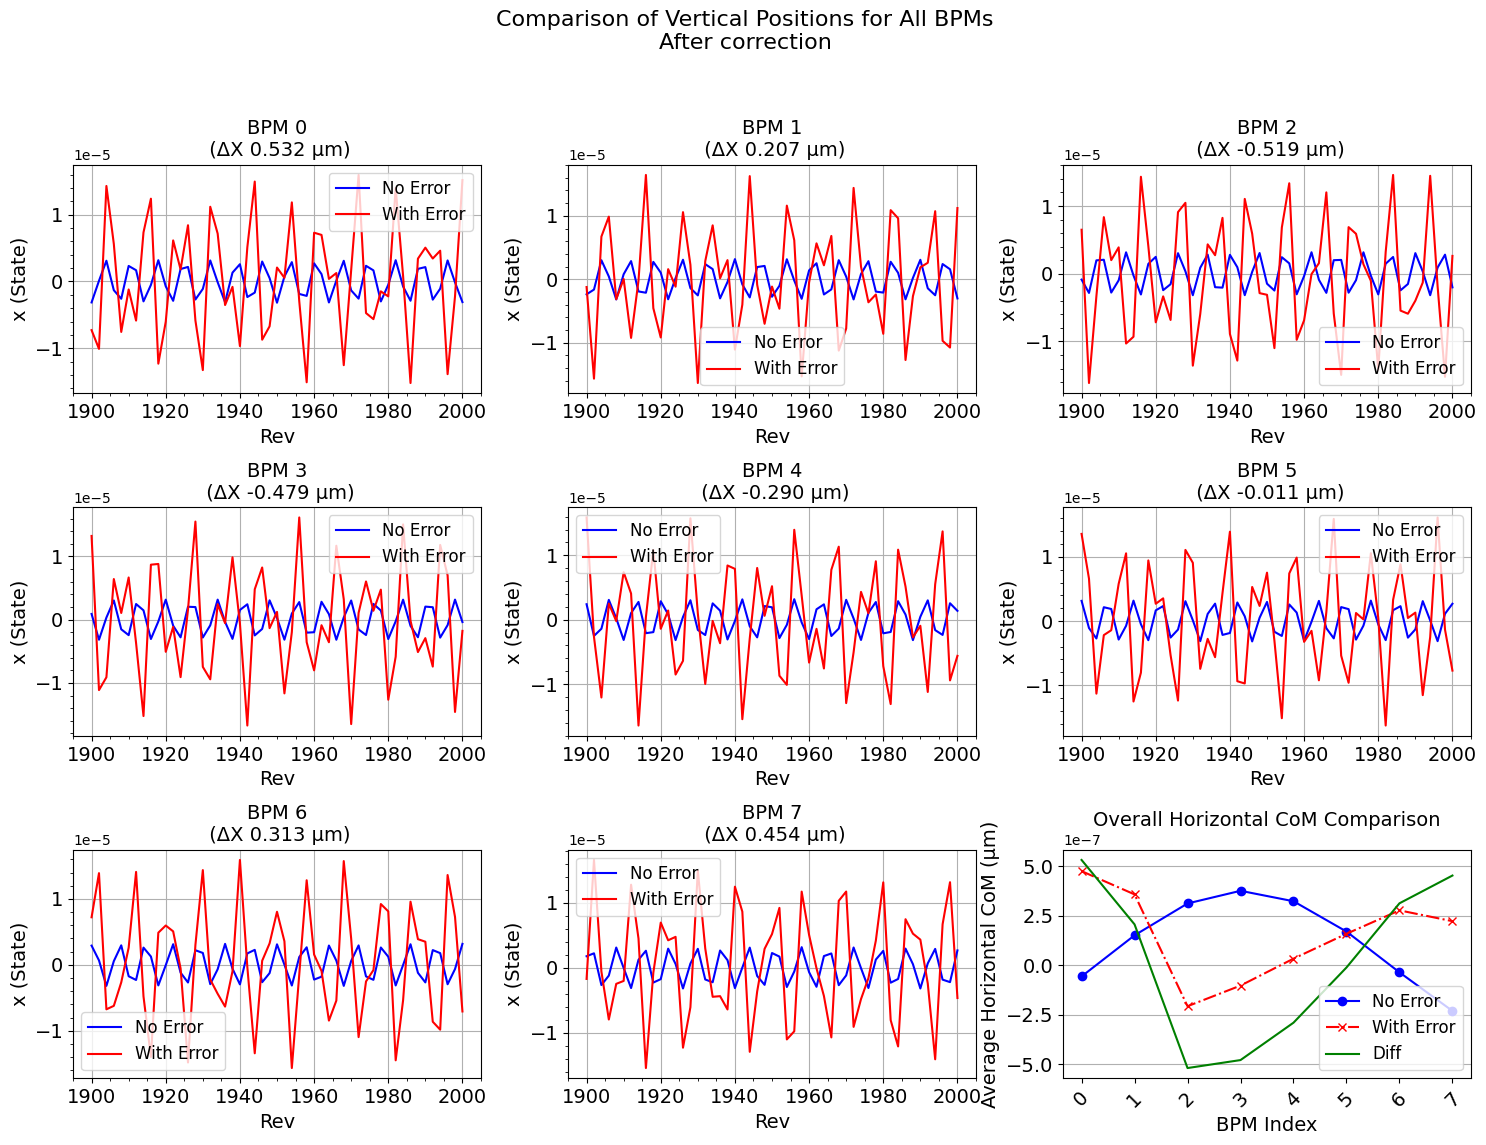

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


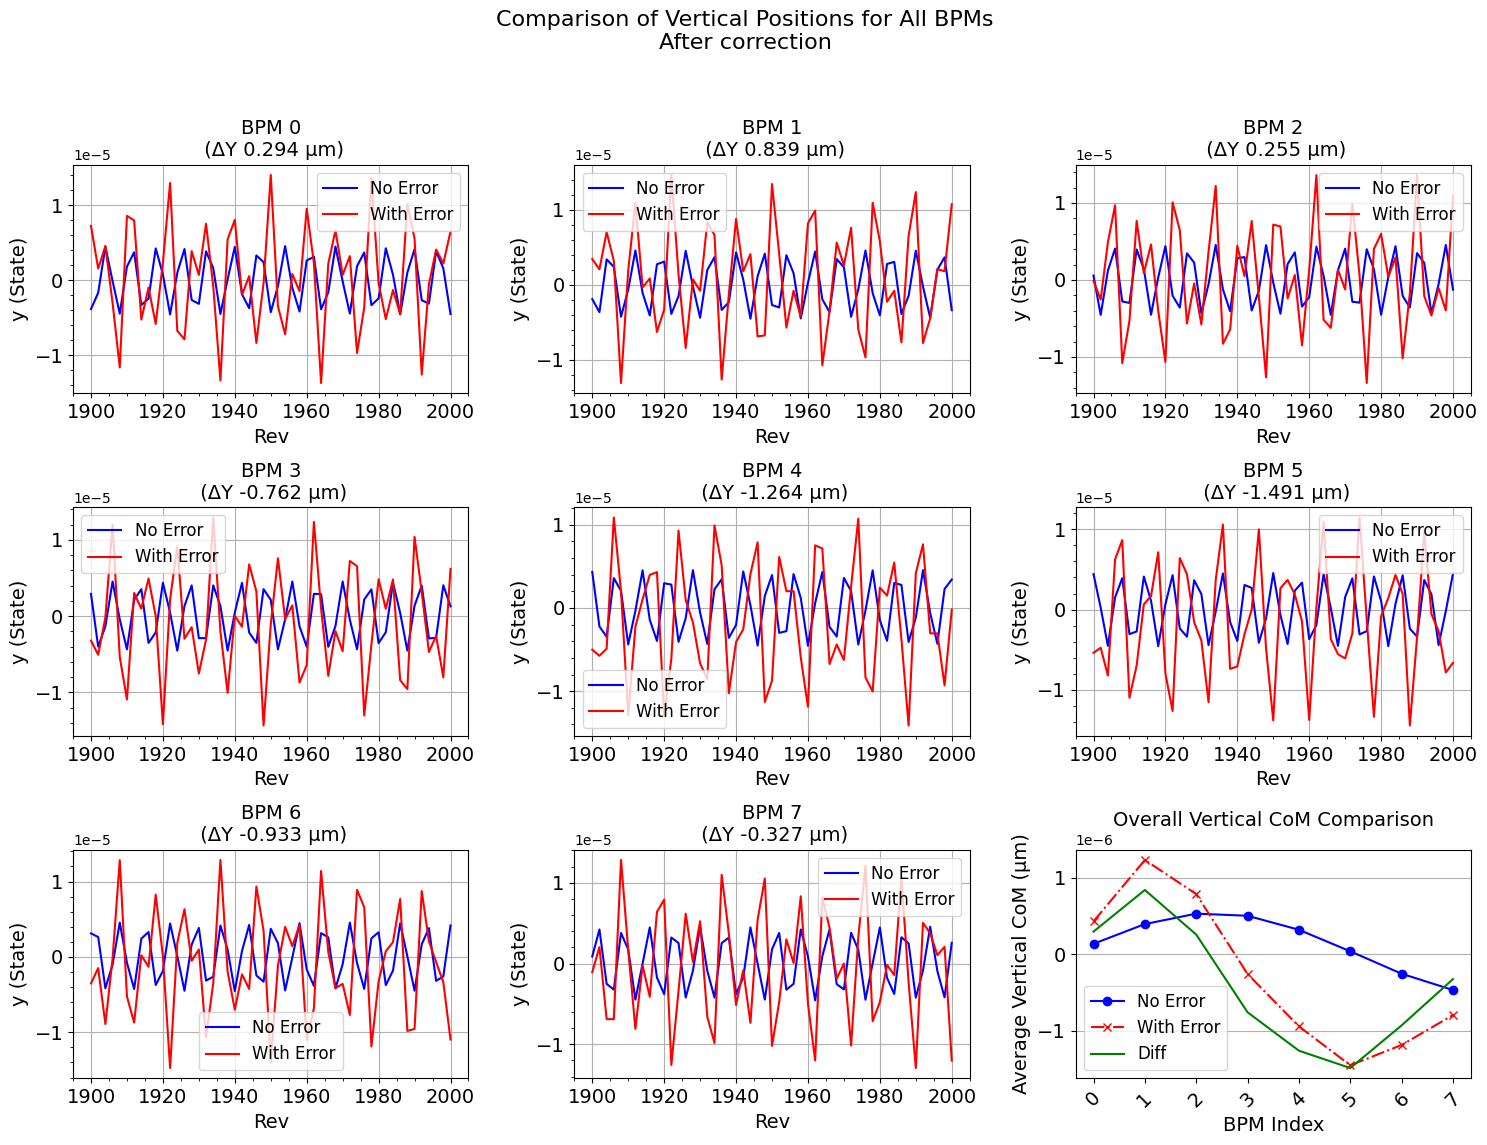

/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:2050: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


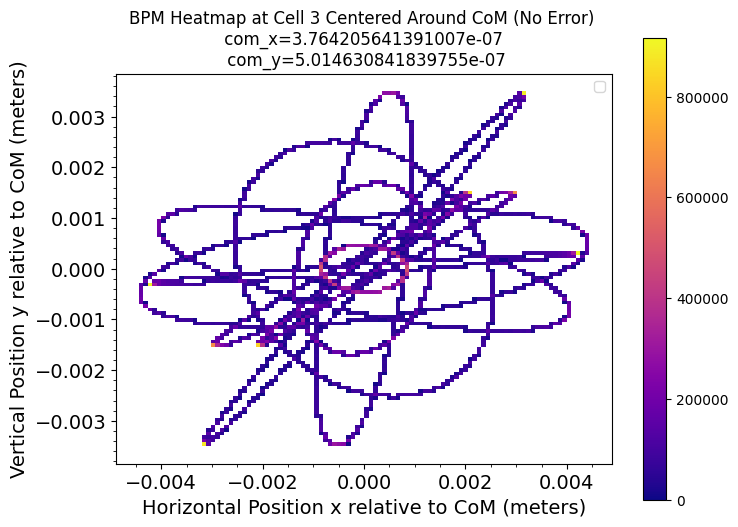

/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:2050: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


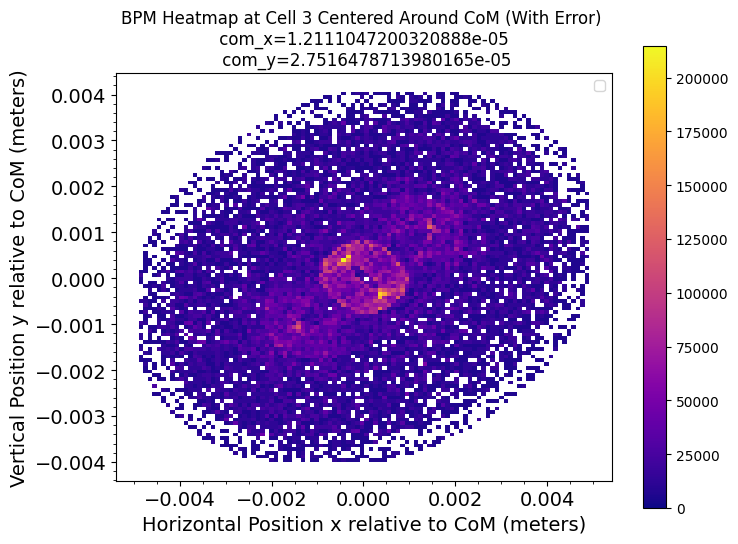

/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:2050: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


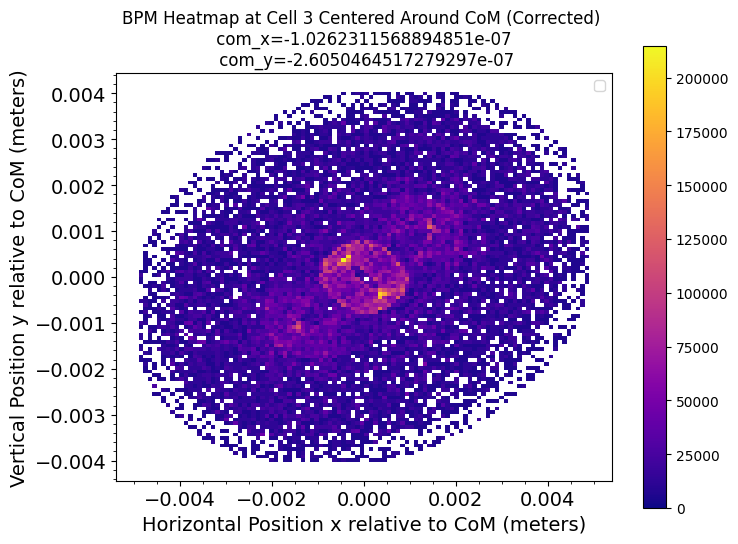

plot_bpm_comparison_last_images()/
	 CoM No error: X = -3.286758258397322e-07, Y = -7.035959548733431e-07
	 CoM With Error: X = 1.1884994490170109e-05, Y = 2.7073387404279612e-05
----
	 f'ΔX = 0.0000122 m, 12.21 micron
	 f'ΔY = 0.0000278 m, 27.78 micron
----


/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:2292: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  legend = plt.legend(facecolor='gray', edgecolor='white', framealpha=0.7)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


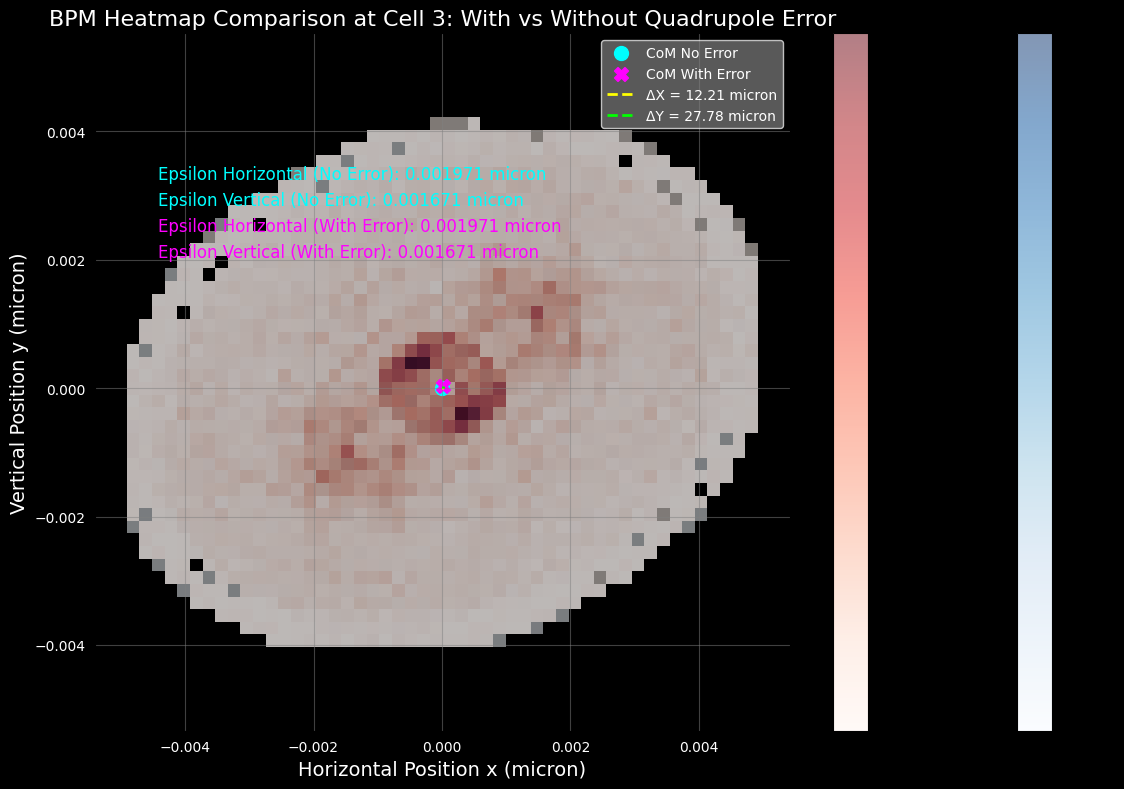

plot_bpm_comparison_last_images()/
	 CoM No error: X = -3.286758258397322e-07, Y = -7.035959548733431e-07
	 CoM With Error: X = 2.146315932272398e-07, Y = 1.4393423501787737e-07
----
	 f'ΔX = 0.0000005 m, 0.54 micron
	 f'ΔY = 0.0000008 m, 0.85 micron
----


/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:2292: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  legend = plt.legend(facecolor='gray', edgecolor='white', framealpha=0.7)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


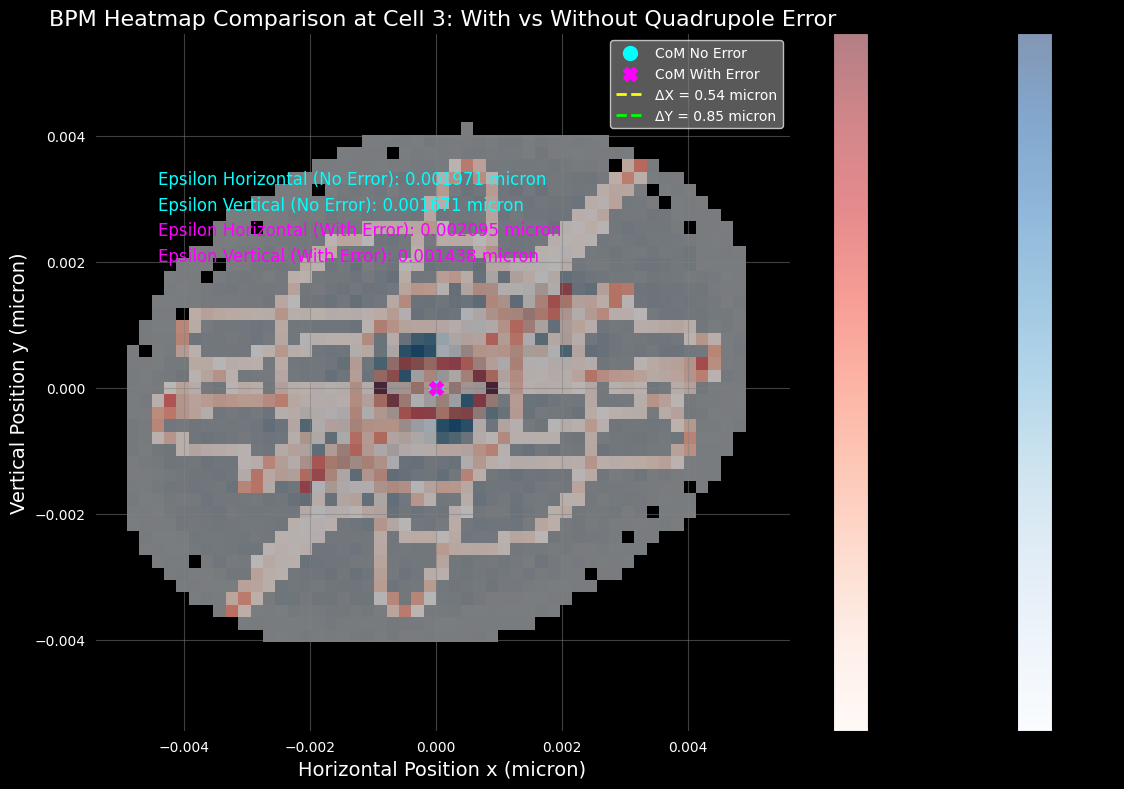

In [275]:

# ------------------------ Main Evaluation Block ------------------------

# Flags for evaluation mode
RUN_BENCHMARK = False  # Set to False to run a single evaluation
RUN_EVALUATE_ONCE = True  # Set to True to run a single evaluation

# Parameters for benchmarking
NOISE_RANGE = 100e-6  # meters
BINS = 11
NOISE_PALLETTE = np.linspace(0, NOISE_RANGE, BINS)  # Converted to micro-units for consistency with example

# Number of runs per noise level
RUNS_PER_NOISE = 50


CANCEL_TILT_ERROR = False
CANCEL_MISALIGN_ERROR = False

base_configurations, common_parameters = split_merged_config(merged_config)
base_configurations = data_automation.overridden_base_config.copy()

# Set up FODO mapping dictionary
# This dictionary maps each prediction output index to the corresponding FODO indices where errors were introduced.
# The target data preparation and network output are ordered according to the configured quad_errors.
fodo_mapping = {}
for qe_ix, qe in enumerate(merged_config['quad_errors']):
    fodo_mapping[qe_ix] = qe['FODO_index']


benchmark_info = {
    "noise_range": NOISE_RANGE,
    "bins": BINS,
    "noise_pallette": NOISE_PALLETTE,
    "runs_per_noise": RUNS_PER_NOISE,
    "fodo_mapping": fodo_mapping,
    "cancel_tilt_error": CANCEL_TILT_ERROR,
    "cancel_misalign_error": CANCEL_MISALIGN_ERROR
}

if CANCEL_TILT_ERROR:
    base_configurations['quad_tilt_errors'] = []
    base_configurations['dipole_tilt_errors'] = []

if CANCEL_MISALIGN_ERROR:
    base_configurations['quad_errors'] = []

if CANCEL_TILT_ERROR and CANCEL_MISALIGN_ERROR:
    common_parameters['target_data'] = False

common_parameters['num_particles'] = 10

# Assume dataset_scalers is defined and contains 'input_scaler' and 'target_scaler'
# dataset_scalers = {'input_scaler': ..., 'target_scaler': ...}

if RUN_EVALUATE_ONCE:
    evaluate_once(model, [base_configurations], common_parameters, dataset_scalers)

if RUN_BENCHMARK:
    if CANCEL_MISALIGN_ERROR and CANCEL_TILT_ERROR:
        print("BENCHMARK was not run!!")
    else:
        stats = benchmark_evaluation(
            model=model,
            base_configurations=[base_configurations],
            common_parameters=common_parameters,
            dataset_scalers=dataset_scalers,
            noise_range=NOISE_RANGE,
            bins=BINS,
            runs=RUNS_PER_NOISE
        )
    
        torch.save(convert_defaultdict_to_dict(stats), "benchmark_stats_MisAlign-True_Tilt_True.pt")
    
        plot_benchmark_stats(stats, benchmark_info)
        

# ------------------------ End of Evaluation Block ------------------------


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


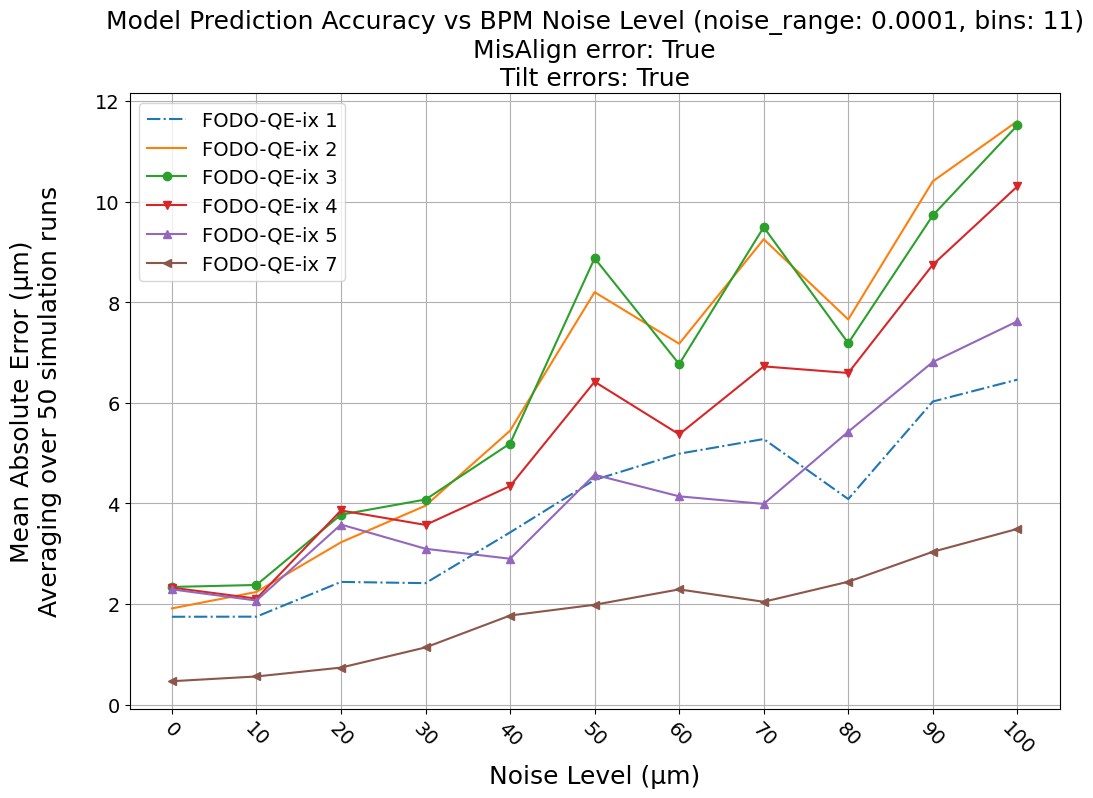

In [383]:
plot_benchmark_stats(stats, benchmark_info)

In [326]:
print(Line2D.markers)

{'.': 'point', ',': 'pixel', 'o': 'circle', 'v': 'triangle_down', '^': 'triangle_up', '<': 'triangle_left', '>': 'triangle_right', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', '4': 'tri_right', '8': 'octagon', 's': 'square', 'p': 'pentagon', '*': 'star', 'h': 'hexagon1', 'H': 'hexagon2', '+': 'plus', 'x': 'x', 'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', '_': 'hline', 'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft', 1: 'tickright', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase', 10: 'caretupbase', 11: 'caretdownbase', 'None': 'nothing', 'none': 'nothing', ' ': 'nothing', '': 'nothing'}


In [378]:
def get_local_plt_markers(nb_binz):
    plt_markers = Line2D.markers.copy()
    plt_markers.pop('')
    plt_markers.pop(' ')
    plt_markers.pop('None')
    plt_markers.pop('none')
    local_plt_markers_list = [pm for pm in plt_markers.keys()]
    
    if nb_binz > len(plt_markers):
        nb_repeat = int(ceil(nb_binz / len(plt_markers)))
        local_plt_markers_list = local_plt_markers_list * nb_repeat
        local_plt_markers_list = local_plt_markers_list[:nb_binz]
    
    return local_plt_markers_list

In [367]:
len(local_plt_markers_list)

54

In [39]:
simulator_no_error.bpm_readings['x'].shape

(1, 2000, 8)

In [39]:
simulator_no_error.bpm_readings['x'][:, 0:1500, 0].shape

(1, 1500)

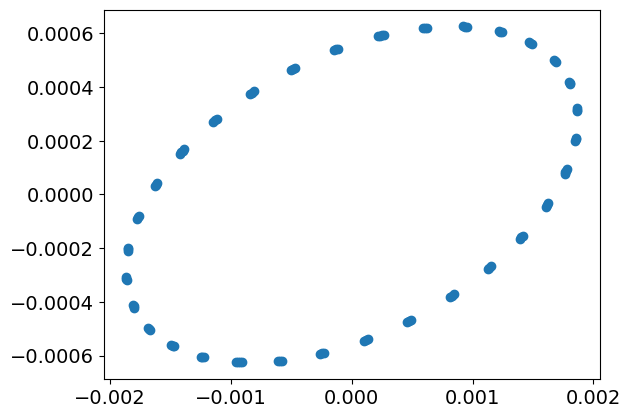

In [355]:
# plot(simulator_no_error.bpm_readings['x'][:, 0:1500, 0].mean(axis=0), '.')
# plot(simulator_no_error.bpm_readings['y'][:, 0:1500, 0].mean(axis=0), '.')
last_turn = 100
plot(simulator_no_error.bpm_readings['y'][:, 0:last_turn, 0].mean(axis=0), simulator_no_error.bpm_readings['yp'][:, 0:last_turn, 0].mean(axis=0), 'o')

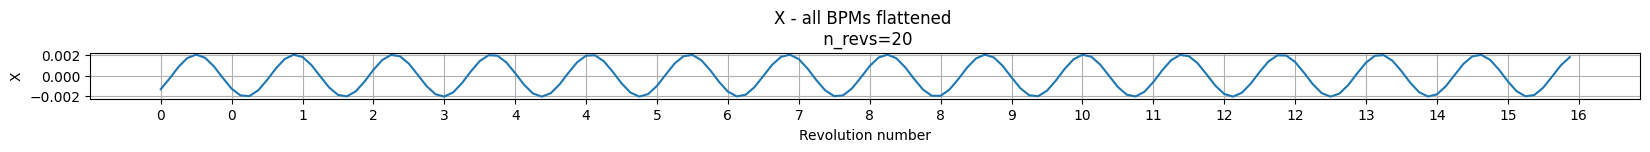

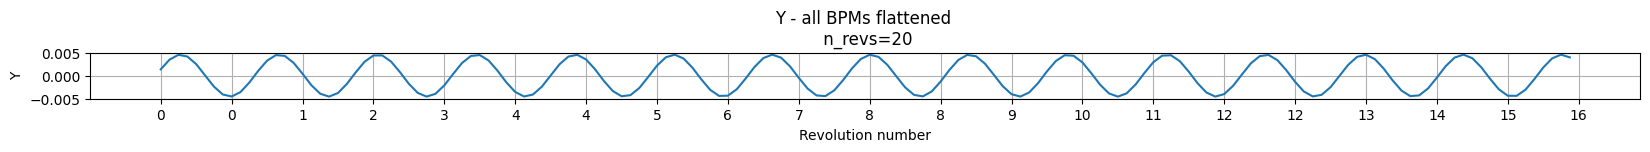

In [62]:
particle_idx = 0
start_idx = 980
end_idx = 1000
cell_idx = 6

simulator_no_error.plot_particle_bpm_readings(particle_idx, start_idx, end_idx)

In [37]:
train_inputs.shape, train_targets.shape

(torch.Size([800, 101, 16]), torch.Size([800, 6]))

/home/aribra/jnps/thesis/lattice_error_net/synchrotron_simulator_gpu_Dataset_4D.py:2050: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


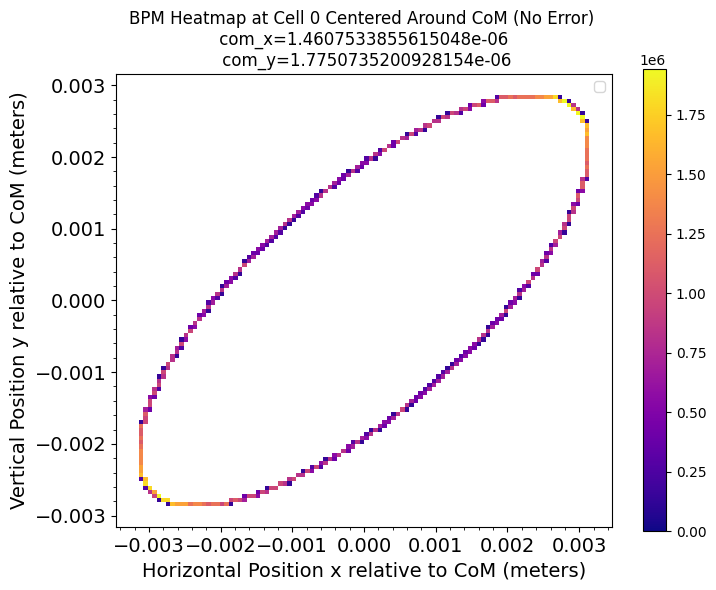

In [88]:
simulator_no_error.plot_bpm_heatmaps(cell_idx=0, save_label='0')

In [88]:
simulator_no_error.compare_bpm_signal_vs_bpm_number(
    other_simulator=simulator_with_error,
    turn=200,
    plane='vertical',
    average_over_particles=True,
    plot_difference=True,
    save_label="1496",
    fontsize=18
    
)


ValueError: Requested turn 200 is out of range for at least one simulator.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


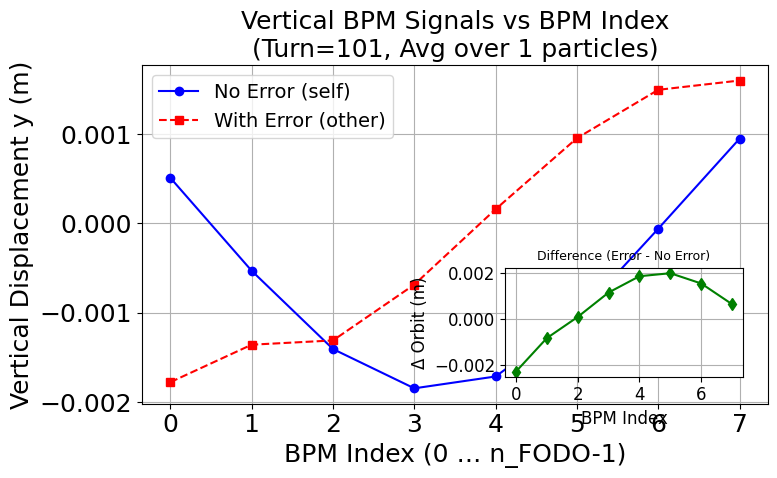

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Vertical BPM Signals vs BPM Index\n(Turn=101, Avg over 1 particles)'}, xlabel='BPM Index (0 … n_FODO-1)', ylabel='Vertical Displacement y (m)'>)

In [322]:
simulator_no_error.compare_bpm_signal_vs_bpm_number(
    other_simulator=simulator_with_error,
    turn=101,
    plane='vertical',
    average_over_particles=True,
    plot_difference=True,
    save_label="None",
    fontsize=18
)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


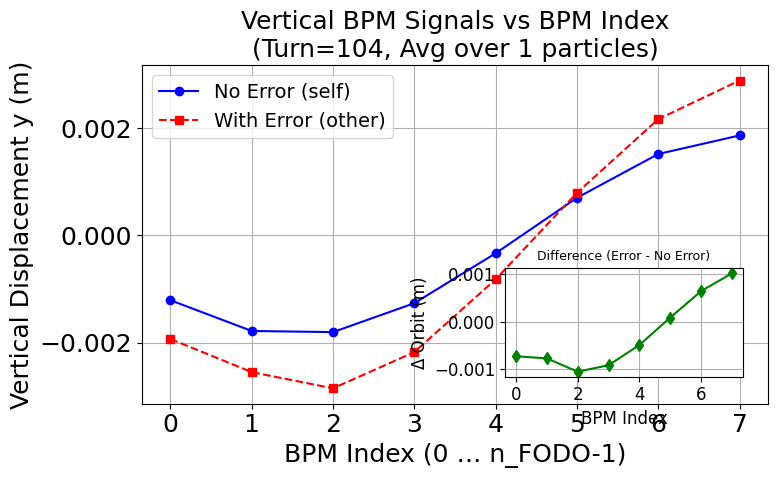

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Vertical BPM Signals vs BPM Index\n(Turn=104, Avg over 1 particles)'}, xlabel='BPM Index (0 … n_FODO-1)', ylabel='Vertical Displacement y (m)'>)

In [325]:
simulator_no_error.compare_bpm_signal_vs_bpm_number(
    other_simulator=simulator_with_error,
    turn=104,
    plane='vertical',
    average_over_particles=True,
    plot_difference=True,
    save_label="None",
    fontsize=18
)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


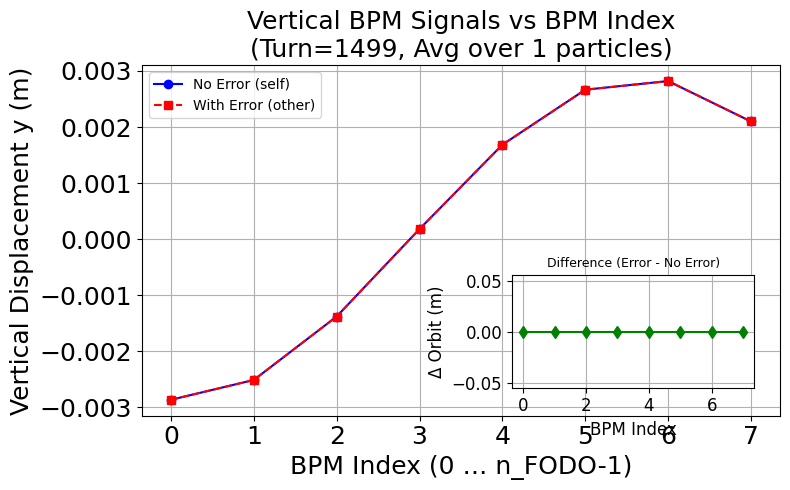

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Vertical BPM Signals vs BPM Index\n(Turn=1499, Avg over 1 particles)'}, xlabel='BPM Index (0 … n_FODO-1)', ylabel='Vertical Displacement y (m)'>)

In [94]:
simulator_no_error.compare_bpm_signal_vs_bpm_number(
    other_simulator=simulator_with_error,
    turn=1499,
    plane='vertical',
    average_over_particles=True,
    plot_difference=True,
    save_label="1499",
    fontsize=18
)
